In [1]:
import os
import glob
import json
import pymworks
import re
import datautils
import copy
import math
import time

import multiprocessing as mp
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import cPickle as pkl
from cPickle import PicklingError

import scipy.stats as spstats
import utils as util
import process_datafiles as processd

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]


/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/pymworks/protocol/__init__.py:15: UserWarning: networkx is required for pymworks.protocols.states
  warnings.warn('networkx is required for pymworks.protocols.states')
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/datautils/__init__.py:22: UserWarning: datautils.mongo failed to import with: No module named pymongo
  warnings.warn('datautils.mongo failed to import with: %s' % E)
utils.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/e

In [2]:
%matplotlib notebook

## 1. Set sources and output dirs:

In [3]:
# Set path params:
rootdir = '/n/coxfs01/behavior-data'
paradigm = 'threeport'

# Set all output dirs
cohort_dirs = [os.path.split(p)[0] for p in glob.glob(os.path.join(rootdir, paradigm, 'cohort_data', 'A*', 'raw'))]
cohort_list = [re.search('(\D{2})', os.path.split(pf)[-1]).group(0) for pf in cohort_dirs]

for cohort in cohort_list:
    working_dir = os.path.join(rootdir, paradigm, 'cohort_data', cohort)   
    output_dir = os.path.join(working_dir, 'processed')
    output_figdir = os.path.join(output_dir, 'figures')
    output_datadir = os.path.join(output_dir, 'data')
    if not os.path.exists(output_figdir): os.makedirs(output_figdir)
    if not os.path.exists(output_datadir): os.makedirs(output_datadir)


# 2. Set extraction info

In [4]:

# Set experiment parsing vars and params:
response_types = ['Announce_AcquirePort1', 'Announce_AcquirePort3', 'ignore']
outcome_types = outcome_types = ['success', 'ignore', 'failure']
ignore_flags = None


# 3. Load metadata

In [5]:
metadata = processd.get_metadata(paradigm, rootdir=rootdir, create_meta=False)


Loading existing metadata...


In [6]:
outdir = os.path.join(rootdir, paradigm, 'processed')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/behavior-data/threeport/processed


###### 

In [85]:
reload(util)
reload(processd)

utils.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 49

<module 'process_datafiles' from 'process_datafiles.pyc'>

In [86]:
cohort = 'AL'
animalid = 'AL11'
session_meta = metadata[metadata.animalid==animalid].copy()


In [87]:
A, new_sessions = processd.load_animal_data(animalid, paradigm, metadata, rootdir=rootdir)

(False, False)
outfile: /n/coxfs01/behavior-data/threeport/cohort_data/AL/processed/data/AL11.pkl
[AL11]: Loaded 0 processed sessions (+0 are None).
[AL11]: Found 53 out of 53 sessions to process.


In [88]:
#AL11_170815

AL10_170822b.mwk

AG1_161012d.mwk

NameError: name 'AL10_170822b' is not defined

In [89]:
session_meta = metadata[(metadata['animalid']=='AL10') & (metadata['session']==20170822)]
session_meta

animalid cohort                                         datasource  \
17     AL10     AL  /n/coxfs01/behavior-data/threeport/cohort_data...   
18     AL10     AL  /n/coxfs01/behavior-data/threeport/cohort_data...   

     session  
17  20170822  
18  20170822

In [90]:
S = util.Session(session_meta)


In [91]:
S.source

['/n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL10_170822.mwk',
 '/n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL10_170822b.mwk']

In [93]:

#### Parse trials and outcomes
trials = []
flags = {}
tmp_flags = []
if isinstance(S.source, list) and len(S.source) > 1:
    for dfn in S.source:
        curr_trials, curr_flags, df = util.parse_trials(dfn, response_types=response_types, 
                                               outcome_types=outcome_types,
                                               ignore_flags=ignore_flags)
        if curr_trials is not None:
            trials.extend(curr_trials)
            tmp_flags.append(curr_flags)

    # Combine flag values across data files:
    if len(tmp_flags) > 0:
        flags = {
            k: [d.get(k) for d in tmp_flags]
            for k in set().union(*tmp_flags)
        }
    for k, v in flags.items():
        if k=='run_bounds':
            # keep separte so we know when datafile splits happen
            continue
        # Combine single-values and get unique
        if len(v)>1:
            u_vals = np.unique([vv for vv in v])
            if len(u_vals)==1:
                u_vals=u_vals[0]
            flags[k] = u_vals 


            

else:
    # Open data file:
    dfn = self.source[0]
    trials, flags, df = util.parse_trials(dfn, response_types=response_types, 
                                 outcome_types=outcome_types,
                                 ignore_flags=ignore_flags)

***** Parsing trials *****
-- finding stop
More than 1 value found for flag: FlagStaircaseProbFreeRew
More than 1 value found for flag: FlagStaircaseSize
More than 1 value found for flag: FlagStaircaseRotCW
More than 1 value found for flag: FlagStaircaseRotACW
More than 1 value found for flag: FlagStaircaseDeptRotRight
More than 1 value found for flag: FlagStaircaseDeptRotLeft
More than 1 value found for flag: FlagShowStimRight
More than 1 value found for flag: FlagShowStimLeft
(274, 274)
N total response events:  265
N total outcome events:  265
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL10_170822.mwk
N valid trials: 265
***** Parsing trials *****
-- finding stop
More than 1 value found for flag: FlagShowStimRight
(144, 150)
N total response events:  138
N total outcome events:  138
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL10_170822b.mwk
N valid trials: 138

In [95]:
flags

{'FlagAddFreeRewardToEarnedReward': 0,
 'FlagAlwaysEnforceMaxSeqLeng': 1,
 'FlagAlwaysReward': 0,
 'FlagAutomaticBiasSuppression': 1,
 'FlagCorrectionTrials': 0,
 'FlagCueStimSound': 0,
 'FlagDiscardHalfOfTheTrials': 1,
 'FlagEnrichSomeStaircases': 0,
 'FlagForceCueStimSoundOff': 0,
 'FlagLongPunishment': 1,
 'FlagPlayOutcomeSound': 1,
 'FlagRepeatedTrial': 0,
 'FlagSampUniformDistr': 0,
 'FlagShowOnlyTrainedAxes': 1,
 'FlagShowStimAfterResponse': 1,
 'FlagShowStimLeft': 1,
 'FlagShowStimRight': array([0, 1]),
 'FlagShowVisualStimuli': 1,
 'FlagStaircaseDeptRotLeft': 0,
 'FlagStaircaseDeptRotRight': array([0, 1]),
 'FlagStaircaseHorizSeparation': 0,
 'FlagStaircasePosHL': 0,
 'FlagStaircasePosHR': 0,
 'FlagStaircasePosVD': 0,
 'FlagStaircasePosVU': 0,
 'FlagStaircaseProbFreeRew': 0,
 'FlagStaircaseRotACW': 0,
 'FlagStaircaseRotCW': 0,
 'FlagStaircaseSize': array([0, 1]),
 'run_bounds': [[(1211356793270, 1217485965050)],
  [(1217503784144, 1222227866277)]]}

In [77]:
bar = {
    k: [d.get(k) for d in tmp_flags]
    for k in set().union(*tmp_flags)
}
bar

{'FlagAddFreeRewardToEarnedReward': [[0], [0]],
 'FlagAlwaysEnforceMaxSeqLeng': [[1], [1]],
 'FlagAlwaysReward': [[0], [0]],
 'FlagAutomaticBiasSuppression': [[1], [1]],
 'FlagCorrectionTrials': [[0], [0]],
 'FlagCueStimSound': [[0], [0]],
 'FlagDiscardHalfOfTheTrials': [[1], [1]],
 'FlagEnrichSomeStaircases': [[0], [0]],
 'FlagForceCueStimSoundOff': [[0], [0]],
 'FlagLongPunishment': [[1], [1]],
 'FlagPlayOutcomeSound': [[1], [1]],
 'FlagRepeatedTrial': [[0], [0]],
 'FlagSampUniformDistr': [[0], [0]],
 'FlagShowOnlyTrainedAxes': [[1], [1]],
 'FlagShowStimAfterResponse': [[1], [1]],
 'FlagShowStimLeft': [[1], [1]],
 'FlagShowStimRight': [[1], [0]],
 'FlagShowVisualStimuli': [[1], [1]],
 'FlagStaircaseDeptRotLeft': [[0], [0]],
 'FlagStaircaseDeptRotRight': [[0], [1]],
 'FlagStaircaseHorizSeparation': [[0], [0]],
 'FlagStaircasePosHL': [[0], [0]],
 'FlagStaircasePosHR': [[0], [0]],
 'FlagStaircasePosVD': [[0], [0]],
 'FlagStaircasePosVU': [[0], [0]],
 'FlagStaircaseProbFreeRew': [[0], [0

In [84]:
for k, v in bar.items():
    if k=='run_bounds':
        continue
    if len(v)>1:
        u_vals = np.unique([vv for vv in v])
        if len(u_vals)==1:
            u_vals=u_vals[0]
        bar[k] = u_vals 
bar

{'FlagAddFreeRewardToEarnedReward': 0,
 'FlagAlwaysEnforceMaxSeqLeng': 1,
 'FlagAlwaysReward': 0,
 'FlagAutomaticBiasSuppression': 1,
 'FlagCorrectionTrials': 0,
 'FlagCueStimSound': 0,
 'FlagDiscardHalfOfTheTrials': 1,
 'FlagEnrichSomeStaircases': 0,
 'FlagForceCueStimSoundOff': 0,
 'FlagLongPunishment': 1,
 'FlagPlayOutcomeSound': 1,
 'FlagRepeatedTrial': 0,
 'FlagSampUniformDistr': 0,
 'FlagShowOnlyTrainedAxes': 1,
 'FlagShowStimAfterResponse': 1,
 'FlagShowStimLeft': 1,
 'FlagShowStimRight': array([0, 1]),
 'FlagShowVisualStimuli': 1,
 'FlagStaircaseDeptRotLeft': 0,
 'FlagStaircaseDeptRotRight': array([0, 1]),
 'FlagStaircaseHorizSeparation': 0,
 'FlagStaircasePosHL': 0,
 'FlagStaircasePosHR': 0,
 'FlagStaircasePosVD': 0,
 'FlagStaircasePosVU': 0,
 'FlagStaircaseProbFreeRew': 0,
 'FlagStaircaseRotACW': 0,
 'FlagStaircaseRotCW': 0,
 'FlagStaircaseSize': array([0, 1]),
 'run_bounds': [[(1211356793270, 1217485965050)],
  [(1217503784144, 1222227866277)]]}

In [82]:
v = bar['FlagStaircaseSize']
v

[[1], [0]]

In [83]:
np.unique([len(vv[0]) for vv in v])

TypeError: object of type 'int' has no len()

In [ ]:

  
for elem in Input2: 
    temp[elem['school_id']].extend(elem['roll_no']) 
  
Output = [{"roll_no":y, "school_id":x} for x, y in temp.items()] 
  

In [96]:
animalid

'AL11'

In [97]:

print("***********************************************")
print("ANIMAL:  %s" % animalid)
print("***********************************************")

A, new_sessions = processd.load_animal_data(animalid, paradigm, session_meta, rootdir=rootdir)

# Process all new sessions:
#session_meta = metadata[(metadata.animalid==animalid)] # & (metadata.session==session)]
processed_sessions = processd.process_sessions_for_animal(animalid, 
                                                     metadata,
                                                     #dst_dir=output_figdir,
                                                     n_processes=1,
                                                          plot_each_session=False,
                                                     ignore_flags=ignore_flags,
                                                     response_types=response_types,
                                                     outcome_types=outcome_types, create_new=True)

# Update animal sessions dict:
for datestr, S in processed_sessions.items():
    A.sessions.update({datestr: S})


***********************************************
ANIMAL:  AL11
***********************************************
(False, False)
outfile: /n/coxfs01/behavior-data/threeport/cohort_data/AL/processed/data/AL11.pkl
[AL11]: Loaded 0 processed sessions (+0 are None).
[AL11]: Found 0 out of 0 sessions to process.
***********************************************
ANIMAL:  AL11
***********************************************
(False, False)
outfile: /n/coxfs01/behavior-data/threeport/cohort_data/AL/processed/data/AL11.pkl
[AL11]: Loaded 0 processed sessions (+0 are None).
[AL11]: Found 53 out of 53 sessions to process.
!!! (Re)processing all sessions.
   animalid cohort                                         datasource  \
59     AL11     AL  /n/coxfs01/behavior-data/threeport/cohort_data...   

     session  
59  20170725  
*[AL11] processing session 20170725
***** Parsing trials *****
-- finding stop
More than 1 value found for flag: FlagAddFreeRewardToEarnedReward
More than 1 value found for flag:

N valid trials: 536
... Getting session summary ...
... Getting stimulus counts ...
   animalid cohort                                         datasource  \
70     AL11     AL  /n/coxfs01/behavior-data/threeport/cohort_data...   

     session  
70  20170810  
*[AL11] processing session 20170810
***** Parsing trials *****
-- finding stop
More than 1 value found for flag: FlagAddFreeRewardToEarnedReward
More than 1 value found for flag: FlagShowStimRight
More than 1 value found for flag: FlagShowStimLeft
(688, 688)
N total response events:  569
N total outcome events:  569
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL11_170810.mwk
N valid trials: 569
... Getting session summary ...
... Getting stimulus counts ...
   animalid cohort                                         datasource  \
71     AL11     AL  /n/coxfs01/behavior-data/threeport/cohort_data...   

     session  
71  20170811  
*[AL11] processing session 20170811
***

N valid trials: 615
... Getting session summary ...
... Getting stimulus counts ...
   animalid cohort                                         datasource  \
83     AL11     AL  /n/coxfs01/behavior-data/threeport/cohort_data...   

     session  
83  20170911  
*[AL11] processing session 20170911
***** Parsing trials *****
-- finding stop
More than 1 value found for flag: FlagForceCueStimSoundOff
(821, 821)
N total response events:  760
N total outcome events:  760
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL11_170911.mwk
N valid trials: 760
... Getting session summary ...
... Getting stimulus counts ...
   animalid cohort                                         datasource  \
84     AL11     AL  /n/coxfs01/behavior-data/threeport/cohort_data...   

     session  
84  20170912  
*[AL11] processing session 20170912
***** Parsing trials *****
-- finding stop
More than 1 value found for flag: FlagForceCueStimSoundOff
(932, 932)


96  20171003  
*[AL11] processing session 20171003
***** Parsing trials *****
-- finding stop
More than 1 value found for flag: FlagForceCueStimSoundOff
(896, 896)
N total response events:  831
N total outcome events:  831
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL11_171003.mwk
N valid trials: 831
... Getting session summary ...
... Getting stimulus counts ...
   animalid cohort                                         datasource  \
97     AL11     AL  /n/coxfs01/behavior-data/threeport/cohort_data...   

     session  
97  20171004  
*[AL11] processing session 20171004
***** Parsing trials *****
-- finding stop
More than 1 value found for flag: FlagForceCueStimSoundOff
(800, 800)
N total response events:  759
N total outcome events:  759
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL11_171004.mwk
N valid trials: 759
... Getting session summary ...
... Getting st

Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL11_180207.mwk
N valid trials: 740
... Getting session summary ...
... Getting stimulus counts ...
    animalid cohort                                         datasource  \
110     AL11     AL  /n/coxfs01/behavior-data/threeport/cohort_data...   

      session  
110  20180208  
*[AL11] processing session 20180208
***** Parsing trials *****
-- finding stop
More than 1 value found for flag: FlagForceCueStimSoundOff
(604, 604)
N total response events:  524
N total outcome events:  524
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL11_180208.mwk
N valid trials: 524
... Getting session summary ...
... Getting stimulus counts ...
    animalid cohort                                         datasource  \
111     AL11     AL  /n/coxfs01/behavior-data/threeport/cohort_data...   

      session  
111  20180213  
*[AL11] processing s

AttributeError: Animal instance has no attribute 'items'

In [100]:
processed_sessions

<utils.Animal instance at 0x7f7d54323440>

In [ ]:

# Save to disk:
try:
    with open(A.path, 'wb') as f:
        pkl.dump(A, f, protocol=pkl.HIGHEST_PROTOCOL)
except PicklingError:
    print("Unable to pkl: New sessions are not the same class as old sessions.")
    print("Reprocessing %i old sessions..." % len(processed_sessions))
    for session in old_sessions:
        curr_sessionmeta = session_meta[session_meta.session==session] #session_info[datestr]
        S = util.process_session(curr_sessionmeta)
        A.sessions[session] = S

    with open(animal_datafile, 'wb') as f:
        pkl.dump(A, f, protocol=pkl.HIGHEST_PROTOCOL)

print("[%s] ~~~ processing complete! ~~~" % A.animalid)



In [ ]:
df, new_s, no_trials = processd.get_animal_df(animalid, paradigm, metadata, create_new=False, rootdir=rootdir)


### Test w. 1 

***********************************************
ANIMAL:  AG1
***********************************************
(False, True)
outfile: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed/data/AG1.pkl
[AG1]: Loaded 0 processed sessions.
[AG1]: Found 205 out of 205 sessions to process.
     animalid cohort                                         datasource  \
4557      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4557  20150202  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
--- no trials ---
     animalid cohort                                         datasource  \
4558      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4558  20150203  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform

<IPython.core.display.Javascript object>


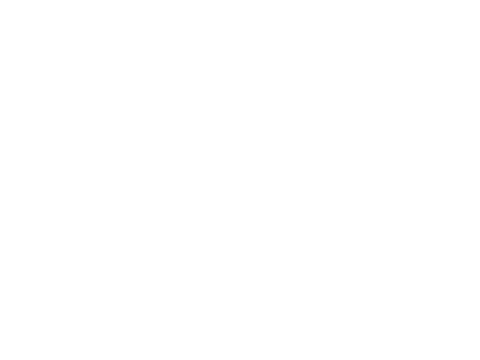

     animalid cohort                                         datasource  \
4559      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4559  20150204  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.25), ('Blob_1_0', 0.8362573099415205)]


<IPython.core.display.Javascript object>


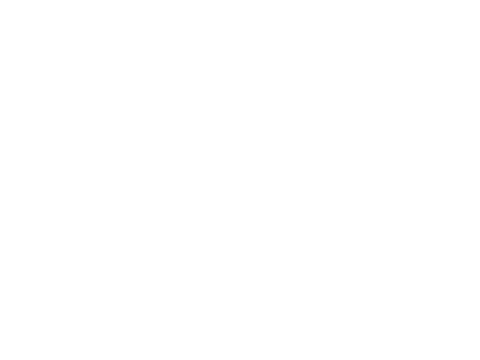

     animalid cohort                                         datasource  \
4560      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4560  20150206  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.3994708994708995), ('Blob_1_0', 0.6454767726161369)]


<IPython.core.display.Javascript object>


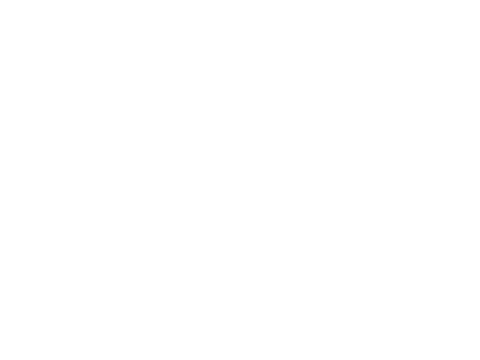

     animalid cohort                                         datasource  \
4561      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4561  20150209  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.6896551724137931), ('Blob_1_0', 0.45188284518828453)]


<IPython.core.display.Javascript object>


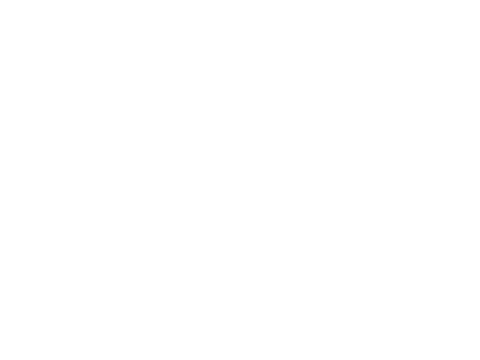

     animalid cohort                                         datasource  \
4562      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4562  20150210  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.7507692307692307), ('Blob_1_0', 0.4642857142857143)]


<IPython.core.display.Javascript object>


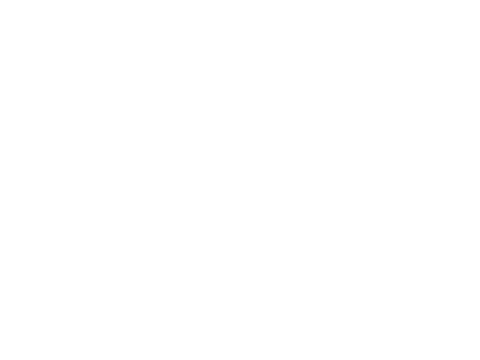

     animalid cohort                                         datasource  \
4563      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4563  20150211  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.7623762376237624), ('Blob_1_0', 0.5907172995780591)]


<IPython.core.display.Javascript object>


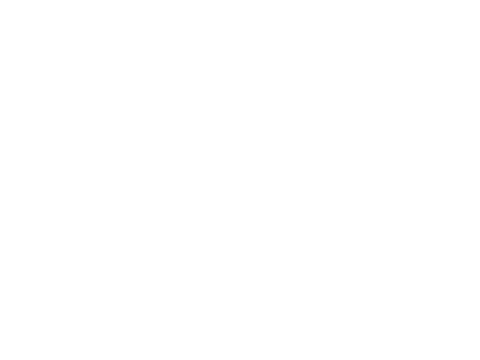

     animalid cohort                                         datasource  \
4564      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4564  20150212  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.7030567685589519), ('Blob_1_0', 0.7142857142857143)]


<IPython.core.display.Javascript object>


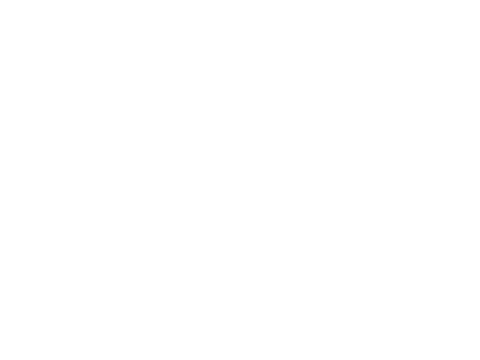

     animalid cohort                                         datasource  \
4565      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4565  20150213  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.7781818181818182), ('Blob_1_0', 0.7708333333333334)]


<IPython.core.display.Javascript object>


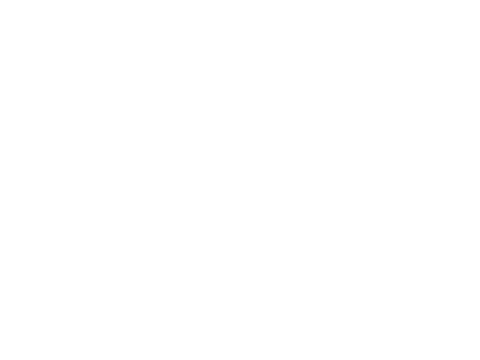

     animalid cohort                                         datasource  \
4566      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4566  20150216  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.7584541062801933), ('Blob_1_0', 0.7151162790697675)]


<IPython.core.display.Javascript object>


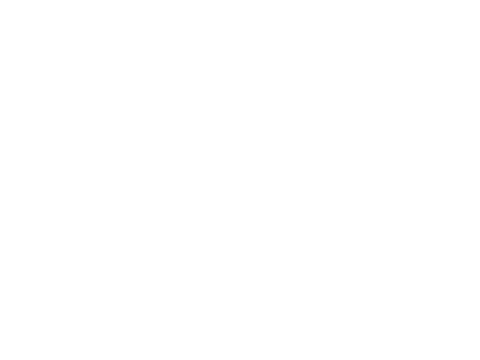

     animalid cohort                                         datasource  \
4567      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4567  20150217  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.8527397260273972), ('Blob_1_0', 0.7361563517915309)]


<IPython.core.display.Javascript object>


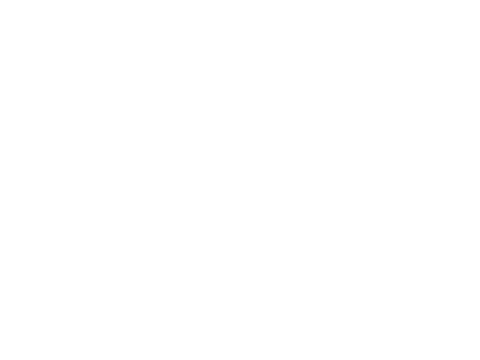

     animalid cohort                                         datasource  \
4568      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4568  20150218  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.8432055749128919), ('Blob_1_0', 0.7347670250896058)]


<IPython.core.display.Javascript object>


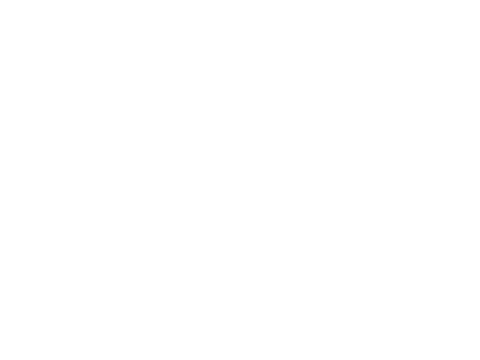

     animalid cohort                                         datasource  \
4569      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4569  20150219  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.8016997167138811), ('Blob_1_0', 0.7186629526462396)]


<IPython.core.display.Javascript object>


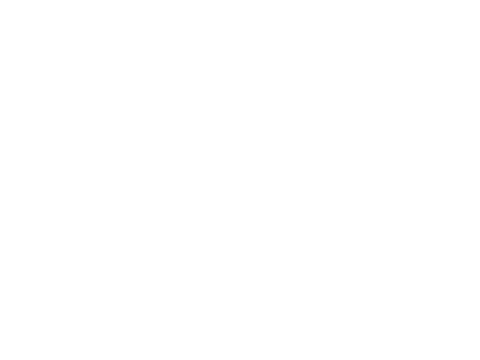

     animalid cohort                                         datasource  \
4570      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4570  20150220  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.8571428571428571), ('Blob_1_0', 0.7915194346289752)]


<IPython.core.display.Javascript object>


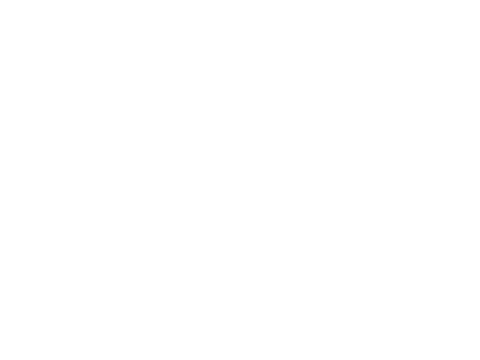

     animalid cohort                                         datasource  \
4571      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4571  20150223  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.7637795275590551), ('Blob_1_0', 0.8059701492537313)]


<IPython.core.display.Javascript object>


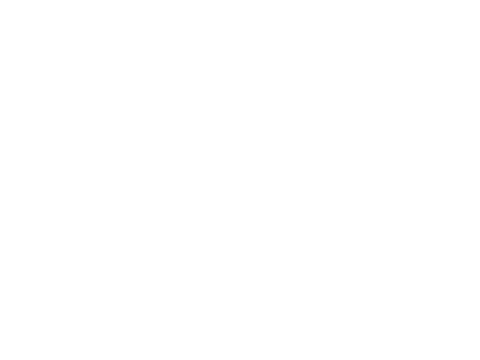

     animalid cohort                                         datasource  \
4572      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4572  20150225  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.8342857142857143), ('Blob_1_0', 0.6984126984126984)]


<IPython.core.display.Javascript object>


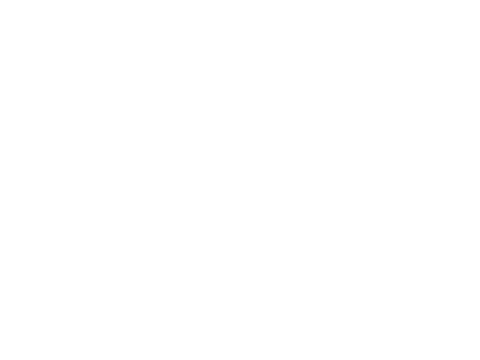

     animalid cohort                                         datasource  \
4573      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4573  20150226  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.8218181818181818), ('Blob_1_0', 0.7508896797153025)]


<IPython.core.display.Javascript object>


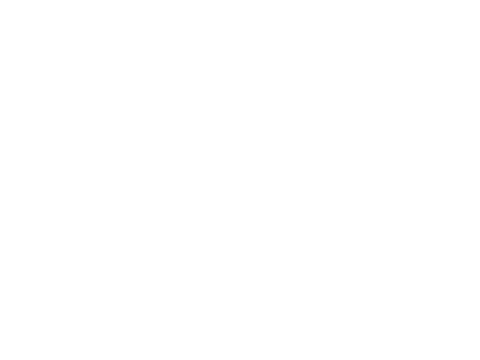

     animalid cohort                                         datasource  \
4574      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4574  20150227  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.7487437185929648), ('Blob_1_0', 0.8458149779735683)]


<IPython.core.display.Javascript object>


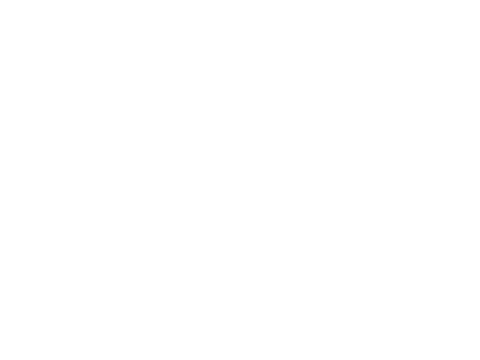

     animalid cohort                                         datasource  \
4575      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4575  20150303  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.7314814814814815), ('Blob_1_0', 0.7836734693877551)]


<IPython.core.display.Javascript object>


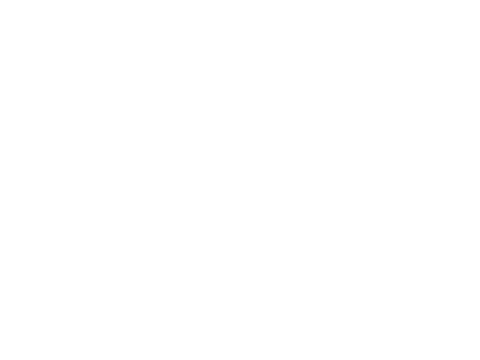

     animalid cohort                                         datasource  \
4576      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4576  20150304  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.7416267942583732), ('Blob_1_0', 0.7288888888888889)]


<IPython.core.display.Javascript object>


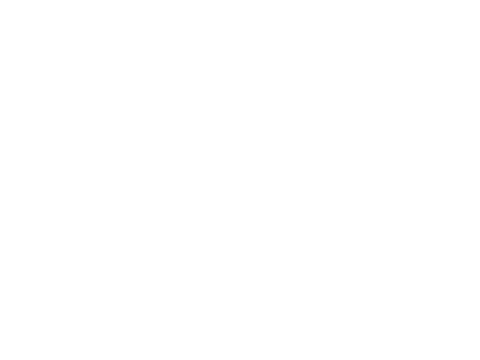

     animalid cohort                                         datasource  \
4577      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4577  20150305  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.842911877394636), ('Blob_1_0', 0.6750902527075813)]


<IPython.core.display.Javascript object>


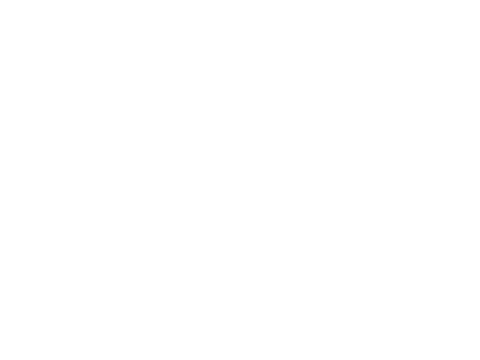

     animalid cohort                                         datasource  \
4578      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4578  20150306  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.7601351351351351), ('Blob_1_0', 0.8098859315589354)]


<IPython.core.display.Javascript object>


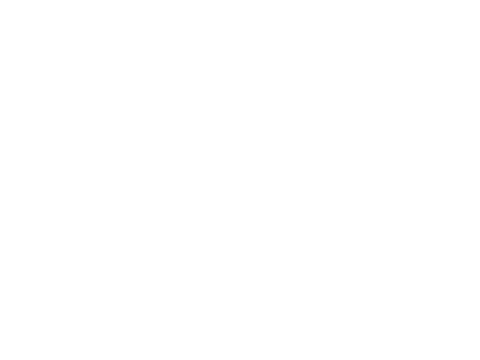

     animalid cohort                                         datasource  \
4579      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4579  20150309  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.7371794871794872), ('Blob_1_0', 0.6628571428571428)]


<IPython.core.display.Javascript object>


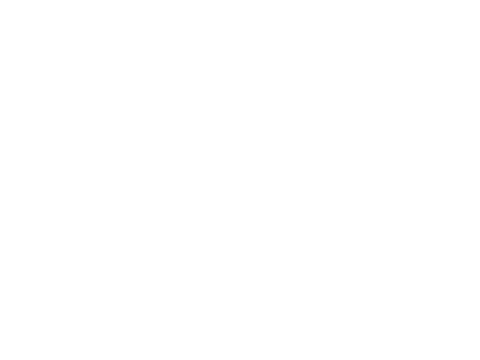

     animalid cohort                                         datasource  \
4580      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4580  20150311  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.75), ('Blob_1_0', 0.8478260869565217)]


<IPython.core.display.Javascript object>


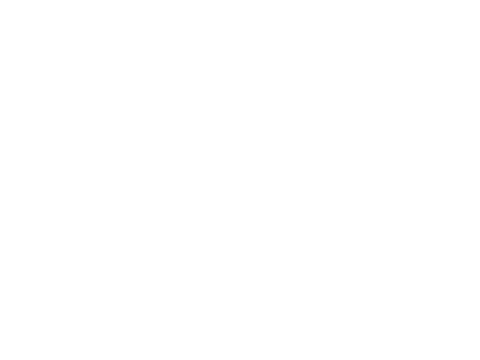

     animalid cohort                                         datasource  \
4581      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4581  20150313  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.7350427350427351), ('Blob_1_0', 0.6790697674418604)]


<IPython.core.display.Javascript object>


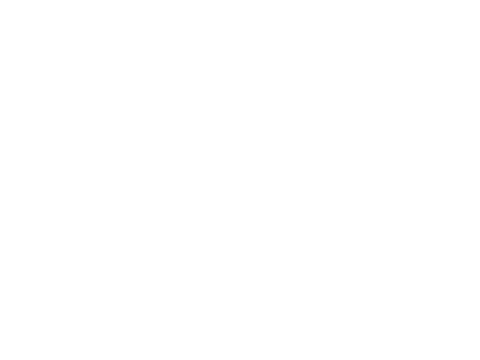

     animalid cohort                                         datasource  \
4582      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4582  20150314  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y0', 0.6735537190082644), ('Blob_N1_y0', 0.8100358422939068)]


<IPython.core.display.Javascript object>


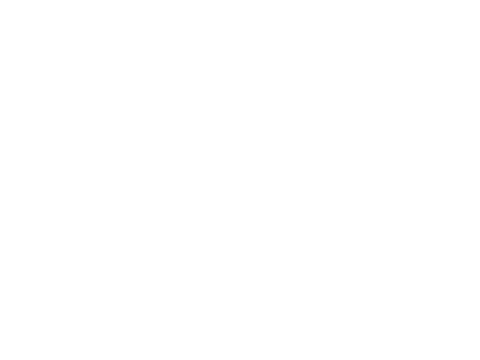

     animalid cohort                                         datasource  \
4583      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4583  20150316  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y0', 0.7319148936170212), ('Blob_N1_y0', 0.7338709677419355)]


<IPython.core.display.Javascript object>


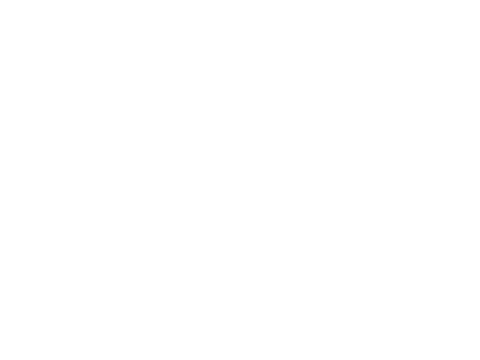

     animalid cohort                                         datasource  \
4584      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4584  20150317  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y0', 0.8113207547169812), ('Blob_N1_y0', 0.61)]


<IPython.core.display.Javascript object>


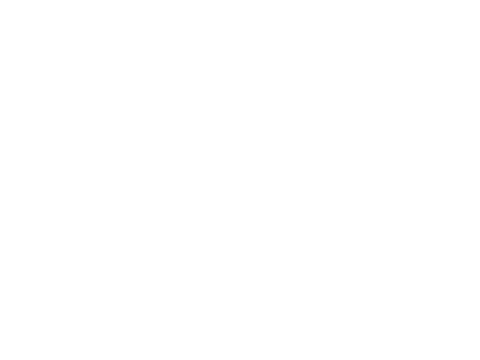

     animalid cohort                                         datasource  \
4585      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4585  20150324  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(333, 339)
N total response events:  323
N total outcome events:  323
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150324.mwk
N valid trials: 323
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y0', 0.7953216374269005), ('Blob_N1_y0', 0.5131578947368421)]


<IPython.core.display.Javascript object>


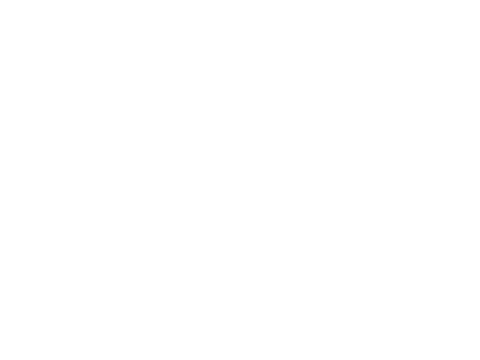

     animalid cohort                                         datasource  \
4586      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4586  20150325  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(336, 342)
N total response events:  310
N total outcome events:  310
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150325.mwk
N valid trials: 310
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y0', 0.7548387096774194), ('Blob_N1_y0', 0.5161290322580645)]


<IPython.core.display.Javascript object>


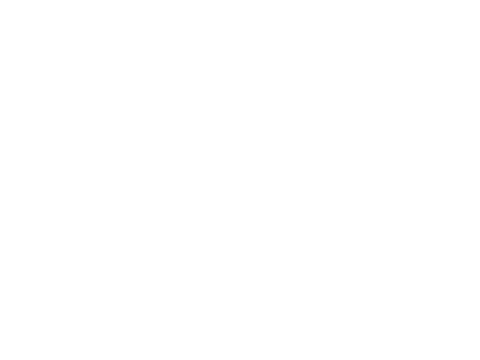

     animalid cohort                                         datasource  \
4587      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4587  20150326  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(342, 348)
N total response events:  322
N total outcome events:  322
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150326.mwk
N valid trials: 322
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y0', 0.7837837837837838), ('Blob_N1_y0', 0.5)]


<IPython.core.display.Javascript object>


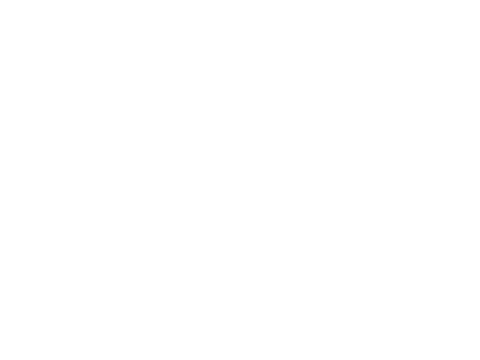

     animalid cohort                                         datasource  \
4588      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4588  20150327  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(341, 347)
N total response events:  324
N total outcome events:  324
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150327.mwk
N valid trials: 324
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y0', 0.8064516129032258), ('Blob_N1_y0', 0.6272189349112426)]


<IPython.core.display.Javascript object>


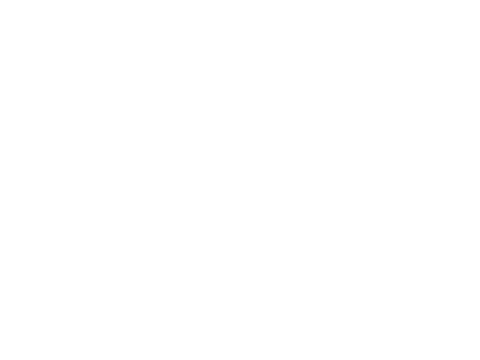

     animalid cohort                                         datasource  \
4589      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4589  20150330  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(270, 276)
N total response events:  265
N total outcome events:  265
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150330.mwk
N valid trials: 265
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y0', 0.7637795275590551), ('Blob_N1_y0', 0.6014492753623188)]


<IPython.core.display.Javascript object>


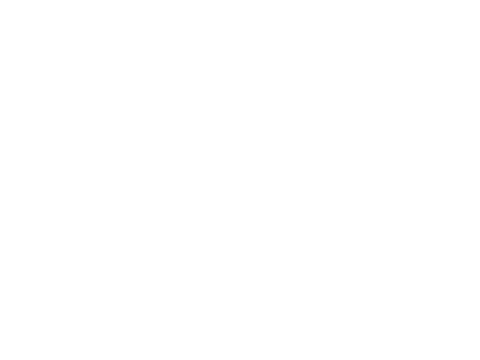

     animalid cohort                                         datasource  \
4590      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4590  20150401  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(354, 360)
N total response events:  346
N total outcome events:  346
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150401.mwk
N valid trials: 346
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y0', 0.8333333333333334), ('Blob_N1_y0', 0.5112359550561798)]


<IPython.core.display.Javascript object>


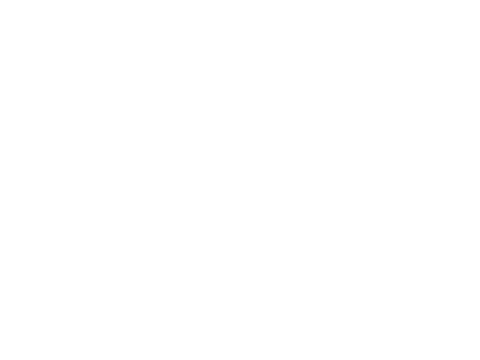

     animalid cohort                                         datasource  \
4591      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4591  20150402  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(331, 337)
N total response events:  322
N total outcome events:  322
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150402.mwk
N valid trials: 322
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y0', 0.6891891891891891), ('Blob_N1_y0', 0.5689655172413793)]


<IPython.core.display.Javascript object>


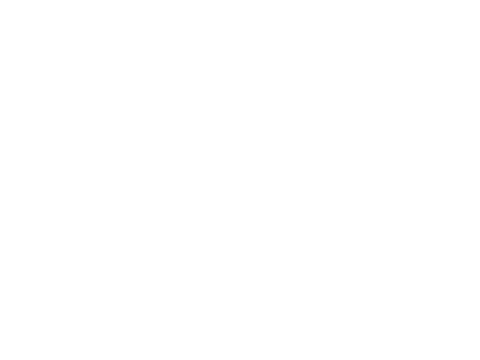

     animalid cohort                                         datasource  \
4592      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4592  20150421  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(262, 268)
N total response events:  246
N total outcome events:  246
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150421.mwk
N valid trials: 246
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y0', 0.7142857142857143), ('Blob_N1_y0', 0.55)]


<IPython.core.display.Javascript object>


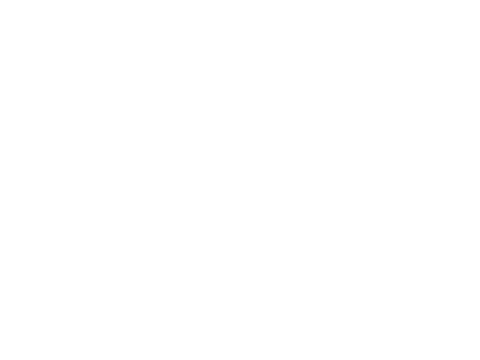

     animalid cohort                                         datasource  \
4593      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4593  20150422  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(371, 377)
N total response events:  360
N total outcome events:  360
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150422.mwk
N valid trials: 360
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y0', 0.7701149425287356), ('Blob_N1_y0', 0.5860215053763441)]


<IPython.core.display.Javascript object>


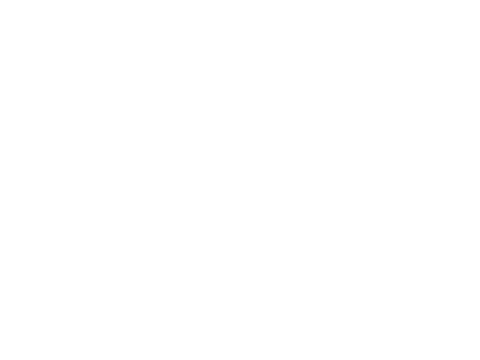

     animalid cohort                                         datasource  \
4594      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4594  20150423  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(398, 404)
N total response events:  380
N total outcome events:  380
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150423.mwk
N valid trials: 380
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y0', 0.7074468085106383), ('Blob_N1_y0', 0.5833333333333334)]


<IPython.core.display.Javascript object>


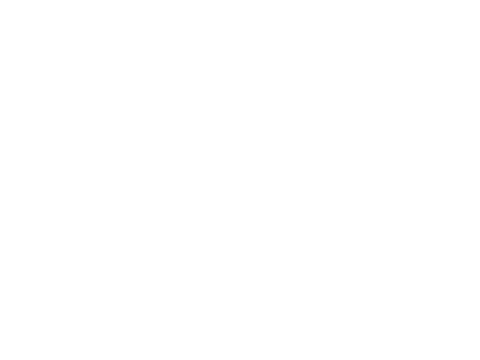

     animalid cohort                                         datasource  \
4595      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4595  20150424  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(42, 48)
N total response events:  31
N total outcome events:  31
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150424.mwk
N valid trials: 31
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y0', 0.8), ('Blob_N1_y0', 0.8125)]


<IPython.core.display.Javascript object>


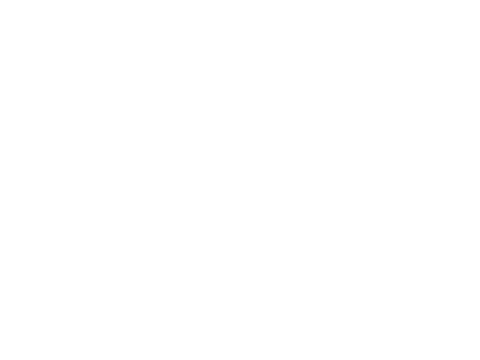

     animalid cohort                                         datasource  \
4596      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4596  20150428  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(319, 325)
N total response events:  313
N total outcome events:  313
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150428.mwk
N valid trials: 313
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N1_y5', 0.6111111111111112), ('Blob_N1_y0', 0.8148148148148148), ('Blob_N2_y5', 0.7692307692307693), ('Blob_N2_y0', 0.5), ('Blob_N1_y35', 0.8888888888888888), ('Blob_N2_y50', 0.14285714285714285), ('Blob_N2_y55', 0.5), ('Blob_N2_y15', 0.6363636363636364), ('Blob_N2_y10', 0.7222222222222222), ('Blob_N2_y30',

<IPython.core.display.Javascript object>


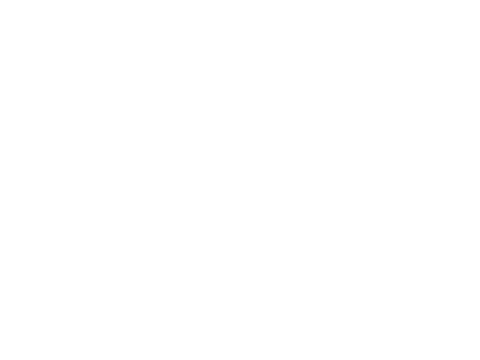

     animalid cohort                                         datasource  \
4597      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4597  20150429  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(384, 390)
N total response events:  366
N total outcome events:  366
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150429.mwk
N valid trials: 366
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y40', 0.7777777777777778), ('Blob_N2_y50', 0.6666666666666666), ('Blob_N2_y60', 0.6911764705882353), ('Blob_N2_y45', 0.7647058823529411), ('Blob_N1_y20', 1.0), ('Blob_N2_y55', 0.7317073170731707), ('Blob_N1_y45', 0.6923076923076923), ('Blob_N1_y5', 0.0), ('Blob_N2_y15', 1.0), ('Blob_N1_y40', 0.5714285714

<IPython.core.display.Javascript object>


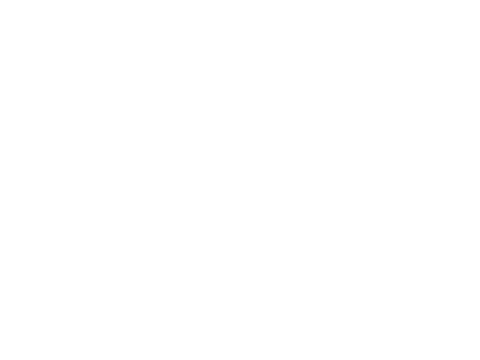

     animalid cohort                                         datasource  \
4598      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4598  20150501  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(465, 471)
N total response events:  457
N total outcome events:  457
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150501.mwk
N valid trials: 457
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y40', 0.7222222222222222), ('Blob_N2_y50', 0.6944444444444444), ('Blob_N2_y45', 0.6956521739130435), ('Blob_N1_y55', 0.7755102040816326), ('Blob_N2_y55', 0.6206896551724138), ('Blob_N1_y45', 0.9090909090909091), ('Blob_N1_y60', 0.8028169014084507), ('Blob_N2_y60', 0.6666666666666666), ('Blob_N1_y40', 0.6

<IPython.core.display.Javascript object>


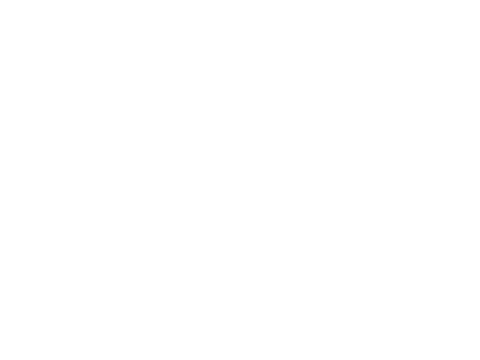

     animalid cohort                                         datasource  \
4599      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4599  20150506  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(240, 246)
N total response events:  225
N total outcome events:  225
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150506.mwk
N valid trials: 225
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y5', 1.0), ('Blob_N1_y35', 1.0), ('Blob_N2_y50', 0.5789473684210527), ('Blob_N2_y55', 0.48148148148148145), ('Blob_N2_y15', 1.0), ('Blob_N2_y10', 1.0), ('Blob_N2_y30', 0.0), ('Blob_N1_y50', 0.75), ('Blob_N1_y30', 1.0), ('Blob_N1_y55', 0.78125), ('Blob_N1_y15', 0.6666666666666666), ('Blob_N2_y35', 0.57142

<IPython.core.display.Javascript object>


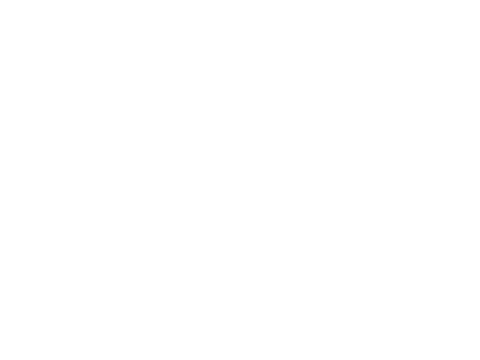

     animalid cohort                                         datasource  \
4600      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4600  20150507  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(373, 379)
N total response events:  351
N total outcome events:  351
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150507.mwk
N valid trials: 351
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y40', 0.5), ('Blob_N2_y50', 0.6842105263157895), ('Blob_N1_y30', 1.0), ('Blob_N2_y45', 0.8260869565217391), ('Blob_N1_y20', 1.0), ('Blob_N2_y55', 0.6346153846153846), ('Blob_N1_y45', 0.7272727272727273), ('Blob_N1_y5', 1.0), ('Blob_N2_y60', 0.7464788732394366), ('Blob_N1_y40', 0.8), ('Blob_N1_y0', 1.0), 

<IPython.core.display.Javascript object>


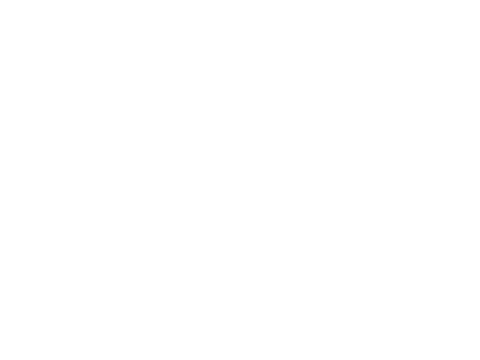

     animalid cohort                                         datasource  \
4601      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4601  20150508  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(347, 353)
N total response events:  334
N total outcome events:  334
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150508.mwk
N valid trials: 334
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y40', 0.5555555555555556), ('Blob_N2_y50', 0.6666666666666666), ('Blob_N2_y60', 0.676923076923077), ('Blob_N2_y45', 0.5), ('Blob_N1_y20', 1.0), ('Blob_N2_y55', 0.7837837837837838), ('Blob_N1_y45', 0.8095238095238095), ('Blob_N1_y5', 0.0), ('Blob_N2_y15', 1.0), ('Blob_N1_y40', 0.75), ('Blob_N2_y10', 1.0),

<IPython.core.display.Javascript object>


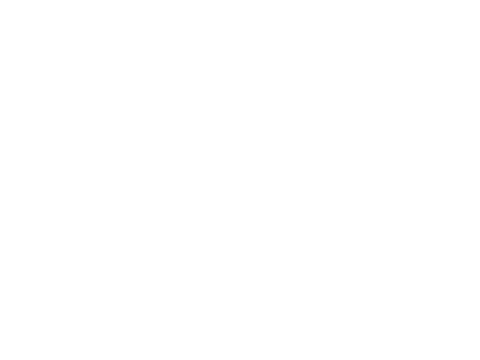

     animalid cohort                                         datasource  \
4602      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4602  20150511  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(286, 292)
N total response events:  281
N total outcome events:  281
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150511.mwk
N valid trials: 281
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N1_y0', 1.0), ('Blob_N2_y5', 1.0), ('Blob_N1_y35', 0.6), ('Blob_N2_y50', 0.6666666666666666), ('Blob_N2_y55', 0.7352941176470589), ('Blob_N2_y15', 0.0), ('Blob_N2_y10', 1.0), ('Blob_N2_y30', 1.0), ('Blob_N1_y50', 0.8125), ('Blob_N1_y30', 0.5), ('Blob_N1_y55', 0.9090909090909091), ('Blob_N1_y15', 1.0), ('Blo

<IPython.core.display.Javascript object>


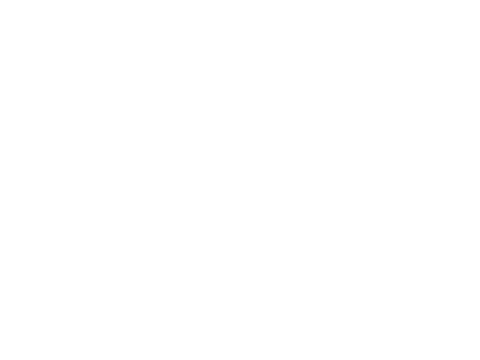

     animalid cohort                                         datasource  \
4603      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4603  20150512  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(273, 279)
N total response events:  265
N total outcome events:  265
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150512.mwk
N valid trials: 265
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y-10', 0.8461538461538461), ('Blob_N2_y-40', 0.8666666666666667), ('Blob_N2_y-15', 1.0), ('Blob_N1_y0', 0.8), ('Blob_N1_y-45', 0.875), ('Blob_N1_y-20', 0.6363636363636364), ('Blob_N2_y0', 0.7692307692307693), ('Blob_N2_y-35', 0.7647058823529411), ('Blob_N1_y-40', 0.8571428571428571), ('Blob_N2_y-25', 1.0

<IPython.core.display.Javascript object>


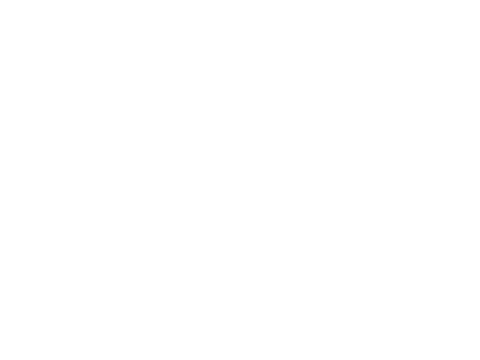

     animalid cohort                                         datasource  \
4604      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4604  20150513  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(188, 194)
N total response events:  181
N total outcome events:  181
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150513.mwk
N valid trials: 181
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y-55', 0.7333333333333333), ('Blob_N1_y-35', 0.6666666666666666), ('Blob_N1_y-50', 0.8), ('Blob_N2_y-40', 0.75), ('Blob_N2_y-25', 0.5), ('Blob_N2_y-20', 1.0), ('Blob_N1_y-15', 1.0), ('Blob_N1_y-30', 1.0), ('Blob_N2_y-15', 1.0), ('Blob_N1_y-45', 0.8666666666666667), ('Blob_N2_y-30', 0.6666666666666666), (

<IPython.core.display.Javascript object>


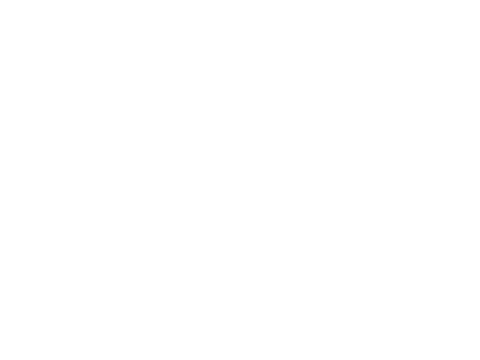

     animalid cohort                                         datasource  \
4605      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4605  20150519  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(228, 234)
N total response events:  219
N total outcome events:  219
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150519.mwk
N valid trials: 219
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N1_y-50', 0.7368421052631579), ('Blob_N2_y-55', 0.8333333333333334), ('Blob_N1_y-35', 1.0), ('Blob_N2_y-30', 0.75), ('Blob_N2_y-40', 0.5555555555555556), ('Blob_N2_y-25', 1.0), ('Blob_N1_y-30', 1.0), ('Blob_N2_y-20', 0.5), ('Blob_N1_y-45', 0.6), ('Blob_N1_y-20', 1.0), ('Blob_N2_y-50', 0.7083333333333334), (

<IPython.core.display.Javascript object>


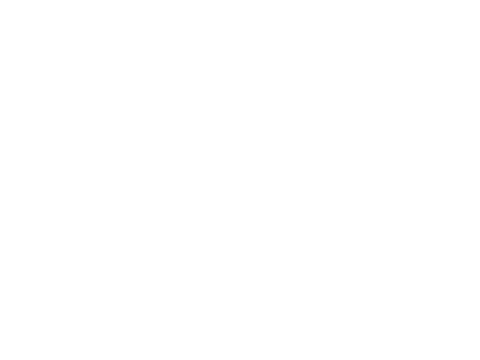

     animalid cohort                                         datasource  \
4606      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4606  20150602  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(283, 289)
N total response events:  275
N total outcome events:  275
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150602.mwk
N valid trials: 275
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N1_y-50', 0.7058823529411765), ('Blob_N2_y-55', 0.6888888888888889), ('Blob_N1_y-35', 0.6666666666666666), ('Blob_N2_y-30', 0.6), ('Blob_N2_y-40', 0.5), ('Blob_N2_y-20', 0.0), ('Blob_N1_y-30', 1.0), ('Blob_N2_y-15', 1.0), ('Blob_N1_y-45', 0.6428571428571429), ('Blob_N1_y-20', 0.6666666666666666), ('Blob_N2_

<IPython.core.display.Javascript object>


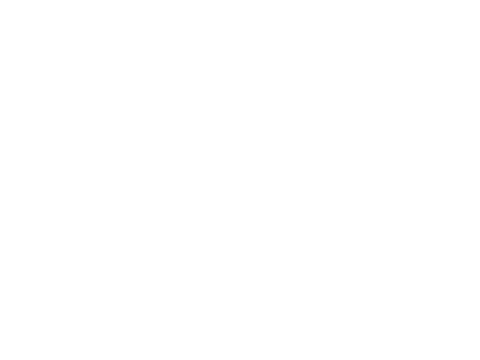

     animalid cohort                                         datasource  \
4607      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4607  20150603  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(511, 517)
N total response events:  487
N total outcome events:  487
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150603.mwk
N valid trials: 487
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y-30', 0.75), ('Blob_N2_y-55', 0.7272727272727273), ('Blob_N1_y-35', 0.5555555555555556), ('Blob_N1_y-50', 0.45), ('Blob_N1_y-10', 0.0), ('Blob_N2_y-25', 1.0), ('Blob_N1_y-30', 0.7272727272727273), ('Blob_N1_y-15', 1.0), ('Blob_N2_y-20', 0.75), ('Blob_N1_y-45', 0.6170212765957447), ('Blob_N1_y-20', 0.5),

<IPython.core.display.Javascript object>


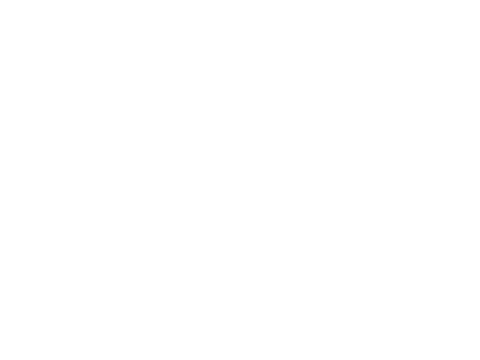

     animalid cohort                                         datasource  \
4608      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4608  20150604  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(547, 553)
N total response events:  534
N total outcome events:  534
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150604.mwk
N valid trials: 534
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N1_y-50', 0.9512195121951219), ('Blob_N2_y-55', 0.7313432835820896), ('Blob_N1_y-35', 1.0), ('Blob_N2_y-30', 0.5), ('Blob_N2_y-40', 0.375), ('Blob_N2_y-25', 0.6666666666666666), ('Blob_N1_y-30', 0.8), ('Blob_N1_y-15', 1.0), ('Blob_N2_y-15', 1.0), ('Blob_N1_y-45', 0.6470588235294118), ('Blob_N1_y-20', 0.0), 

<IPython.core.display.Javascript object>


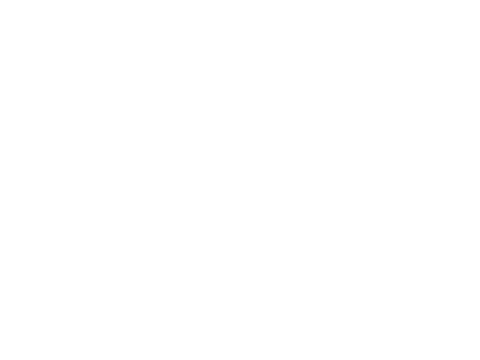

     animalid cohort                                         datasource  \
4609      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4609  20150608  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(433, 439)
N total response events:  417
N total outcome events:  417
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150608.mwk
N valid trials: 417
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.5333333333333333), ('Blob_N2_y45', 0.8666666666666667), ('Blob_N1_y45', 0.7333333333333333), ('Blob_N1_y60', 0.9333333333333333), ('Blob_N2_y15', 0.7857142857142857), ('Blob_N1_y-30', 0.6428571428571429), ('Blob_N1_y-15', 0.9333333333333333), ('Blob_N1_y0', 0.6067415730337079), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


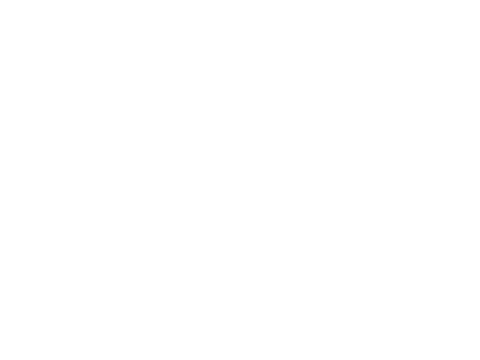

     animalid cohort                                         datasource  \
4610      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4610  20150609  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(548, 554)
N total response events:  533
N total outcome events:  533
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150609.mwk
N valid trials: 533
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.9473684210526315), ('Blob_N2_y45', 0.8947368421052632), ('Blob_N1_y45', 0.8), ('Blob_N1_y60', 0.8421052631578947), ('Blob_N2_y15', 0.7894736842105263), ('Blob_N1_y-30', 0.7894736842105263), ('Blob_N1_y-15', 0.7), ('Blob_N1_y0', 0.5855855855855856), ('Blob_N2_y30', 0.8888888888888888), ('Blob_N1_y

<IPython.core.display.Javascript object>


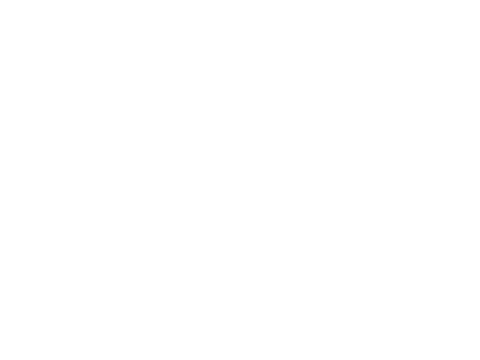

     animalid cohort                                         datasource  \
4611      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4611  20150610  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(705, 711)
N total response events:  695
N total outcome events:  695
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150610.mwk
N valid trials: 695
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8), ('Blob_N2_y45', 0.76), ('Blob_N1_y45', 0.7916666666666666), ('Blob_N1_y60', 0.84), ('Blob_N2_y15', 0.88), ('Blob_N1_y-30', 0.88), ('Blob_N1_y-15', 0.72), ('Blob_N1_y0', 0.5838926174496645), ('Blob_N2_y30', 0.8), ('Blob_N1_y-45', 0.84), ('Blob_N2_y-45', 0.7916666666666666), ('Blob_N2_y0', 0.85

<IPython.core.display.Javascript object>


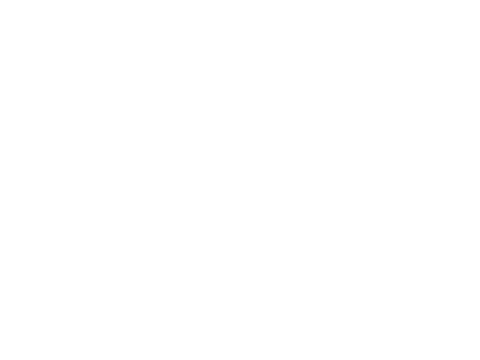

     animalid cohort                                         datasource  \
4612      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4612  20150611  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(702, 708)
N total response events:  695
N total outcome events:  695
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150611.mwk
N valid trials: 695
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7916666666666666), ('Blob_N2_y45', 0.96), ('Blob_N1_y45', 0.8333333333333334), ('Blob_N1_y60', 0.88), ('Blob_N2_y15', 0.88), ('Blob_N1_y-30', 0.88), ('Blob_N1_y-15', 0.48), ('Blob_N1_y0', 0.6778523489932886), ('Blob_N2_y30', 0.88), ('Blob_N1_y-45', 0.88), ('Blob_N2_y-45', 0.7916666666666666), ('B

<IPython.core.display.Javascript object>


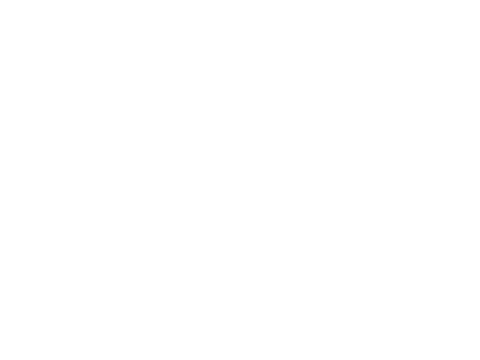

     animalid cohort                                         datasource  \
4613      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4613  20150612  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(602, 608)
N total response events:  592
N total outcome events:  592
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150612.mwk
N valid trials: 592
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.9047619047619048), ('Blob_N2_y45', 0.9090909090909091), ('Blob_N1_y45', 0.8181818181818182), ('Blob_N1_y60', 0.8636363636363636), ('Blob_N2_y15', 0.8), ('Blob_N1_y-30', 0.7619047619047619), ('Blob_N1_y-15', 0.7619047619047619), ('Blob_N1_y0', 0.5793650793650794), ('Blob_N2_y30', 1.0), ('Blob_N1_y

<IPython.core.display.Javascript object>


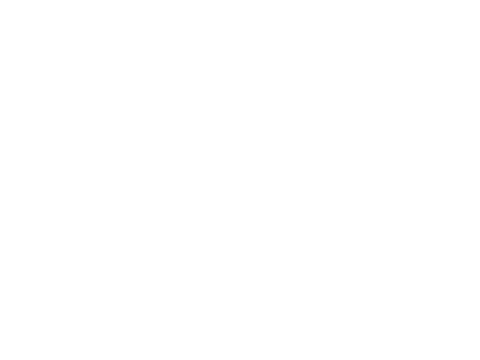

     animalid cohort                                         datasource  \
4614      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4614  20150616  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(435, 441)
N total response events:  427
N total outcome events:  427
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150616.mwk
N valid trials: 427
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7333333333333333), ('Blob_N2_y45', 0.4666666666666667), ('Blob_N1_y45', 0.625), ('Blob_N1_y60', 0.9333333333333333), ('Blob_N2_y15', 0.6666666666666666), ('Blob_N1_y-30', 0.8), ('Blob_N1_y-15', 0.7333333333333333), ('Blob_N1_y0', 0.6847826086956522), ('Blob_N2_y30', 0.8666666666666667), ('Blob_N1

<IPython.core.display.Javascript object>


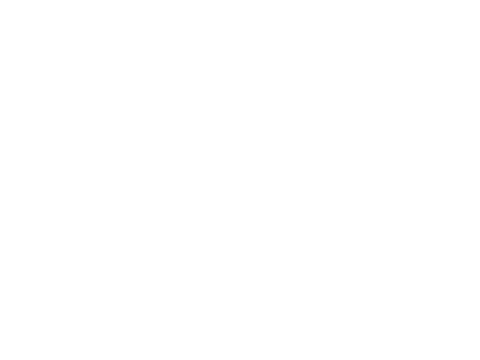

     animalid cohort                                         datasource  \
4615      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4615  20150617  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(630, 636)
N total response events:  622
N total outcome events:  622
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150617.mwk
N valid trials: 622
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8181818181818182), ('Blob_N2_y45', 0.6818181818181818), ('Blob_N1_y45', 0.7272727272727273), ('Blob_N1_y60', 0.8181818181818182), ('Blob_N2_y15', 0.9047619047619048), ('Blob_N1_y-30', 0.7272727272727273), ('Blob_N1_y-15', 0.6363636363636364), ('Blob_N1_y0', 0.6893939393939394), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


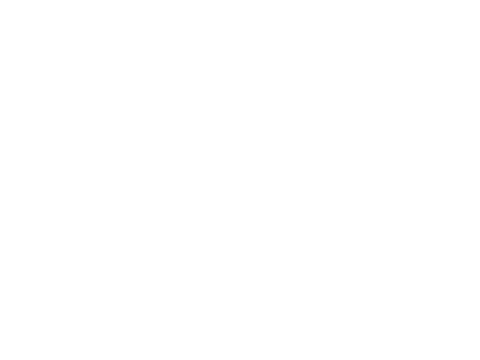

     animalid cohort                                         datasource  \
4616      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4616  20150622  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(391, 397)
N total response events:  382
N total outcome events:  382
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150622.mwk
N valid trials: 382
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8571428571428571), ('Blob_N2_y45', 0.6428571428571429), ('Blob_N1_y45', 0.9285714285714286), ('Blob_N1_y60', 0.8571428571428571), ('Blob_N2_y15', 0.8571428571428571), ('Blob_N1_y-30', 0.5), ('Blob_N1_y-15', 0.8571428571428571), ('Blob_N1_y0', 0.575), ('Blob_N2_y30', 0.7142857142857143), ('Blob_N1

<IPython.core.display.Javascript object>


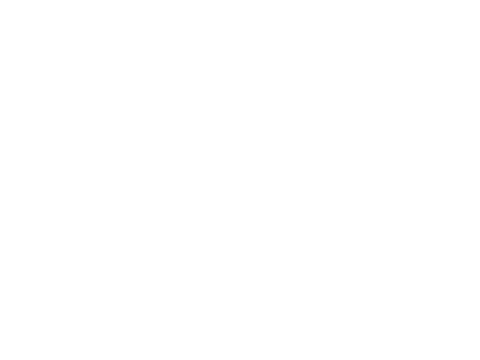

     animalid cohort                                         datasource  \
4617      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4617  20150625  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(689, 695)
N total response events:  680
N total outcome events:  680
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150625.mwk
N valid trials: 680
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.76), ('Blob_N2_y45', 0.9166666666666666), ('Blob_N1_y45', 0.8333333333333334), ('Blob_N1_y60', 0.8333333333333334), ('Blob_N2_y15', 0.72), ('Blob_N1_y-30', 0.8333333333333334), ('Blob_N1_y-15', 0.7916666666666666), ('Blob_N1_y0', 0.722972972972973), ('Blob_N2_y30', 0.875), ('Blob_N1_y-45', 0.72),

<IPython.core.display.Javascript object>


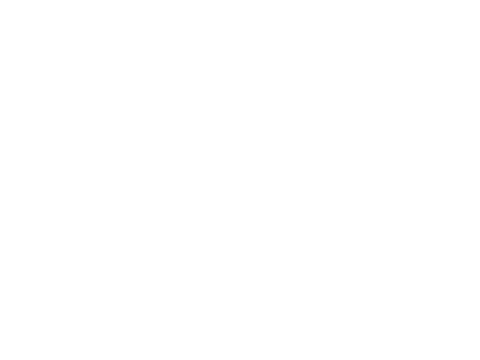

     animalid cohort                                         datasource  \
4618      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4618  20150626  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(535, 541)
N total response events:  527
N total outcome events:  527
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150626.mwk
N valid trials: 527
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8947368421052632), ('Blob_N2_y45', 0.8947368421052632), ('Blob_N1_y45', 0.8421052631578947), ('Blob_N1_y60', 0.7368421052631579), ('Blob_N2_y15', 0.8421052631578947), ('Blob_N1_y-30', 0.8421052631578947), ('Blob_N1_y-15', 0.8947368421052632), ('Blob_N1_y0', 0.7747747747747747), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


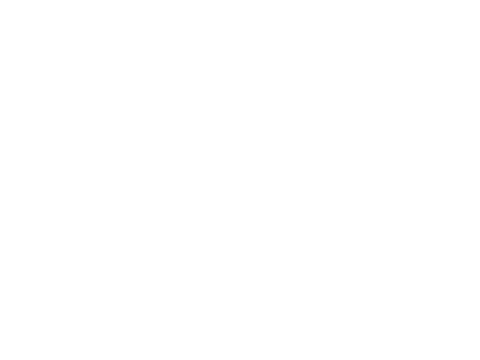

     animalid cohort                                         datasource  \
4619      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4619  20150707  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(424, 430)
N total response events:  416
N total outcome events:  416
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150707.mwk
N valid trials: 416
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.9333333333333333), ('Blob_N2_y45', 0.7333333333333333), ('Blob_N1_y45', 0.9333333333333333), ('Blob_N1_y60', 0.7333333333333333), ('Blob_N2_y15', 0.7333333333333333), ('Blob_N1_y-30', 0.8571428571428571), ('Blob_N1_y-15', 0.6666666666666666), ('Blob_N1_y0', 0.6818181818181818), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


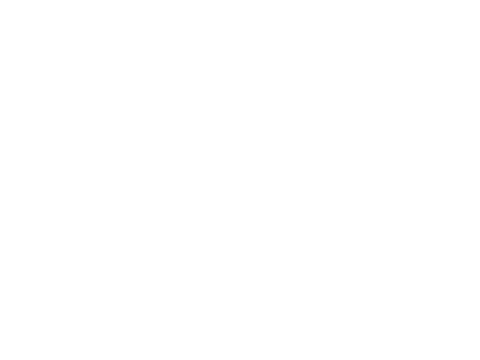

     animalid cohort                                         datasource  \
4620      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4620  20150708  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(504, 510)
N total response events:  492
N total outcome events:  492
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150708.mwk
N valid trials: 492
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.6111111111111112), ('Blob_N2_y45', 0.75), ('Blob_N1_y45', 0.8888888888888888), ('Blob_N1_y60', 0.7777777777777778), ('Blob_N2_y15', 0.6470588235294118), ('Blob_N1_y-30', 0.9444444444444444), ('Blob_N1_y-15', 0.7647058823529411), ('Blob_N1_y0', 0.7904761904761904), ('Blob_N2_y30', 0.77777777777777

<IPython.core.display.Javascript object>


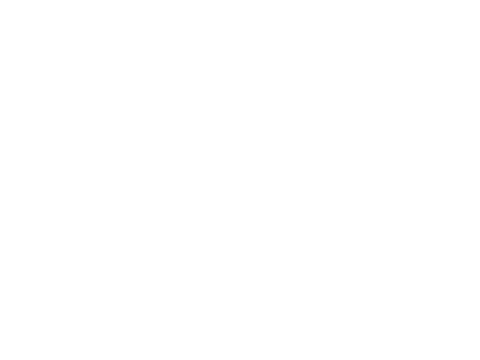

     animalid cohort                                         datasource  \
4621      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4621  20150709  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(552, 558)
N total response events:  542
N total outcome events:  542
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150709.mwk
N valid trials: 542
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.85), ('Blob_N2_y45', 0.85), ('Blob_N1_y45', 0.9473684210526315), ('Blob_N1_y60', 0.9473684210526315), ('Blob_N2_y15', 0.8421052631578947), ('Blob_N1_y-30', 0.7368421052631579), ('Blob_N1_y-15', 0.65), ('Blob_N1_y0', 0.6578947368421053), ('Blob_N2_y30', 0.7), ('Blob_N1_y-45', 0.9), ('Blob_N2_y-45'

<IPython.core.display.Javascript object>


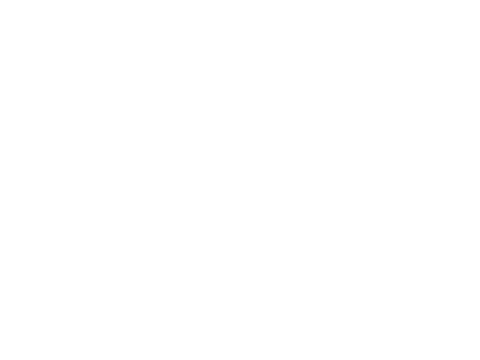

     animalid cohort                                         datasource  \
4622      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4622  20150710  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(572, 578)
N total response events:  566
N total outcome events:  566
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150710.mwk
N valid trials: 566
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8), ('Blob_N2_y45', 0.8421052631578947), ('Blob_N1_y45', 0.8), ('Blob_N1_y60', 0.7), ('Blob_N2_y15', 0.7619047619047619), ('Blob_N1_y-30', 0.7619047619047619), ('Blob_N1_y-15', 0.8), ('Blob_N1_y0', 0.7833333333333333), ('Blob_N2_y30', 0.7), ('Blob_N1_y-45', 0.85), ('Blob_N2_y-45', 0.85), ('Blob_N

<IPython.core.display.Javascript object>


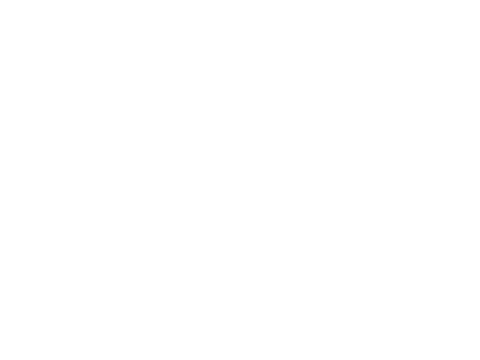

     animalid cohort                                         datasource  \
4623      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4623  20150713  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(269, 275)
N total response events:  263
N total outcome events:  263
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150713.mwk
N valid trials: 263
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 1.0), ('Blob_N2_y45', 0.4444444444444444), ('Blob_N1_y45', 1.0), ('Blob_N1_y60', 0.8888888888888888), ('Blob_N2_y15', 0.8888888888888888), ('Blob_N1_y-30', 0.9), ('Blob_N1_y-15', 0.8888888888888888), ('Blob_N1_y0', 0.6551724137931034), ('Blob_N2_y30', 0.8888888888888888), ('Blob_N1_y-45', 0.7777777

<IPython.core.display.Javascript object>


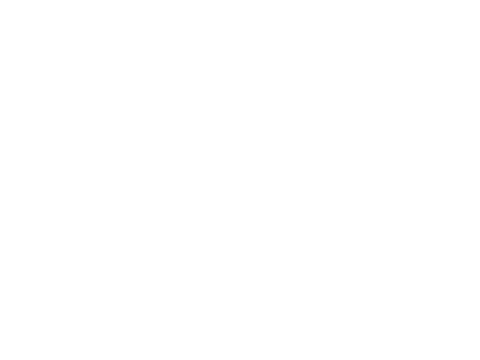

     animalid cohort                                         datasource  \
4624      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4624  20150714  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(432, 438)
N total response events:  425
N total outcome events:  425
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150714.mwk
N valid trials: 425
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.875), ('Blob_N2_y45', 0.8666666666666667), ('Blob_N1_y45', 0.8666666666666667), ('Blob_N1_y60', 0.7333333333333333), ('Blob_N2_y15', 0.75), ('Blob_N1_y-30', 0.8), ('Blob_N1_y-15', 0.875), ('Blob_N1_y0', 0.7444444444444445), ('Blob_N2_y30', 0.875), ('Blob_N1_y-45', 0.9333333333333333), ('Blob_N2_y

<IPython.core.display.Javascript object>


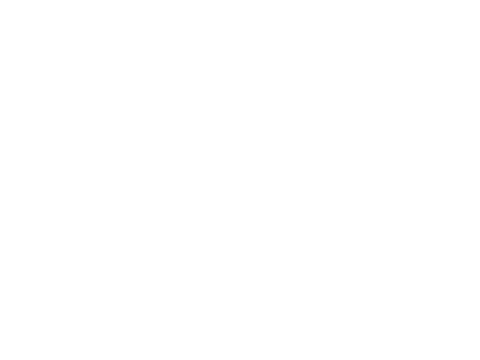

     animalid cohort                                         datasource  \
4625      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4625  20150715  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(645, 651)
N total response events:  637
N total outcome events:  637
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150715.mwk
N valid trials: 637
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8695652173913043), ('Blob_N2_y45', 0.782608695652174), ('Blob_N1_y45', 0.8181818181818182), ('Blob_N1_y60', 0.9130434782608695), ('Blob_N2_y15', 0.6956521739130435), ('Blob_N1_y-30', 0.8181818181818182), ('Blob_N1_y-15', 0.8260869565217391), ('Blob_N1_y0', 0.7279411764705882), ('Blob_N2_y30', 0.8

<IPython.core.display.Javascript object>


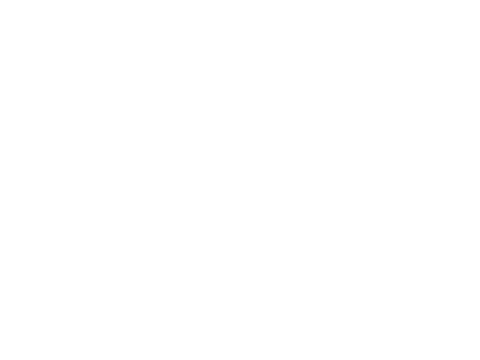

     animalid cohort                                         datasource  \
4626      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4626  20150716  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(571, 577)
N total response events:  561
N total outcome events:  561
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150716.mwk
N valid trials: 561
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8947368421052632), ('Blob_N2_y45', 0.85), ('Blob_N1_y45', 1.0), ('Blob_N1_y60', 1.0), ('Blob_N2_y15', 0.85), ('Blob_N1_y-30', 0.85), ('Blob_N1_y-15', 0.85), ('Blob_N1_y0', 0.6859504132231405), ('Blob_N2_y30', 0.75), ('Blob_N1_y-45', 0.8095238095238095), ('Blob_N2_y-45', 0.75), ('Blob_N2_y0', 0.74

<IPython.core.display.Javascript object>


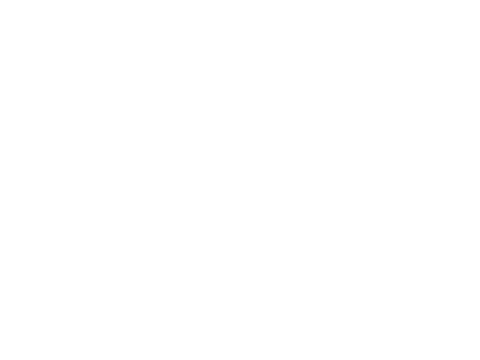

     animalid cohort                                         datasource  \
4627      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4627  20150721  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(347, 353)
N total response events:  340
N total outcome events:  340
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150721.mwk
N valid trials: 340
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.9166666666666666), ('Blob_N2_y45', 0.75), ('Blob_N1_y45', 0.9166666666666666), ('Blob_N1_y60', 0.8333333333333334), ('Blob_N2_y15', 0.8333333333333334), ('Blob_N1_y-30', 0.75), ('Blob_N1_y-15', 0.6666666666666666), ('Blob_N1_y0', 0.5753424657534246), ('Blob_N2_y30', 0.6923076923076923), ('Blob_N1

<IPython.core.display.Javascript object>


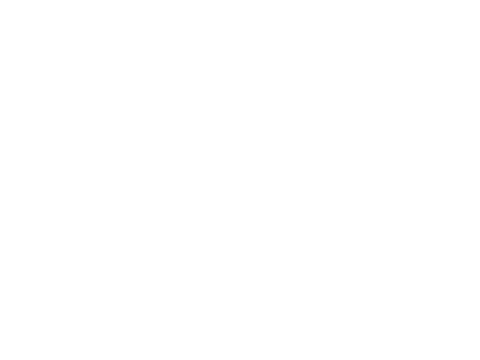

     animalid cohort                                         datasource  \
4628      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4628  20150722  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(538, 544)
N total response events:  534
N total outcome events:  534
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150722.mwk
N valid trials: 534
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8947368421052632), ('Blob_N2_y45', 0.8947368421052632), ('Blob_N1_y45', 0.9473684210526315), ('Blob_N1_y60', 1.0), ('Blob_N2_y15', 0.7368421052631579), ('Blob_N1_y-30', 0.8421052631578947), ('Blob_N1_y-15', 0.7368421052631579), ('Blob_N1_y0', 0.6491228070175439), ('Blob_N2_y30', 0.894736842105263

<IPython.core.display.Javascript object>


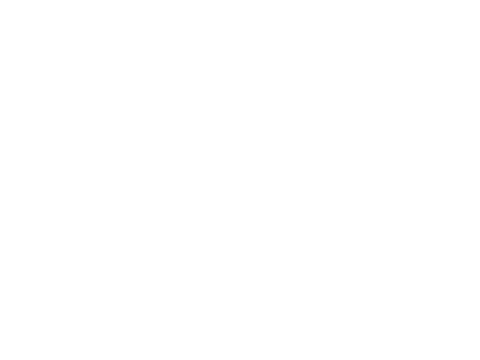

     animalid cohort                                         datasource  \
4629      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4629  20150723  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(524, 530)
N total response events:  516
N total outcome events:  516
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150723.mwk
N valid trials: 516
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7894736842105263), ('Blob_N2_y45', 0.8947368421052632), ('Blob_N1_y45', 0.9473684210526315), ('Blob_N1_y60', 0.8947368421052632), ('Blob_N2_y15', 0.9473684210526315), ('Blob_N1_y-30', 0.8333333333333334), ('Blob_N1_y-15', 0.8888888888888888), ('Blob_N1_y0', 0.7387387387387387), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


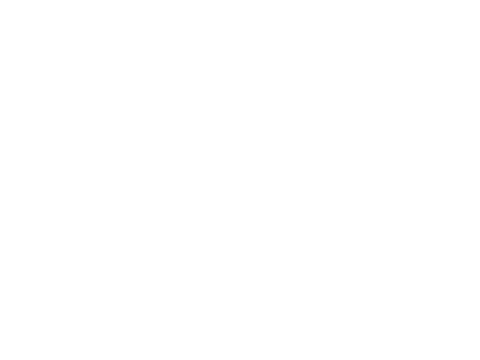

     animalid cohort                                         datasource  \
4630      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4630  20150724  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(508, 514)
N total response events:  504
N total outcome events:  504
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150724.mwk
N valid trials: 504
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.9444444444444444), ('Blob_N2_y45', 0.7777777777777778), ('Blob_N1_y45', 0.8888888888888888), ('Blob_N1_y60', 0.9444444444444444), ('Blob_N2_y15', 0.6666666666666666), ('Blob_N1_y-30', 0.7777777777777778), ('Blob_N1_y-15', 0.7777777777777778), ('Blob_N1_y0', 0.6574074074074074), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


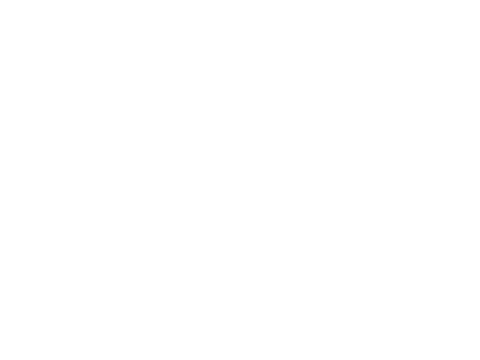

     animalid cohort                                         datasource  \
4631      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4631  20150728  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(386, 392)
N total response events:  380
N total outcome events:  380
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150728.mwk
N valid trials: 380
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7692307692307693), ('Blob_N2_y45', 0.8571428571428571), ('Blob_N1_y45', 0.8571428571428571), ('Blob_N1_y60', 0.6428571428571429), ('Blob_N2_y15', 0.9230769230769231), ('Blob_N1_y-30', 0.6428571428571429), ('Blob_N1_y-15', 0.7142857142857143), ('Blob_N1_y0', 0.6125), ('Blob_N2_y30', 0.692307692307

<IPython.core.display.Javascript object>


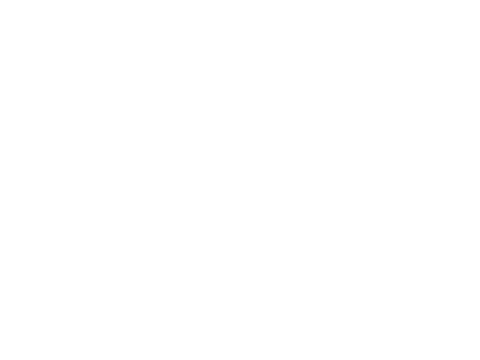

     animalid cohort                                         datasource  \
4632      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4632  20150729  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(562, 568)
N total response events:  556
N total outcome events:  556
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150729.mwk
N valid trials: 556
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.6842105263157895), ('Blob_N2_y45', 0.7), ('Blob_N1_y45', 0.8), ('Blob_N1_y60', 0.95), ('Blob_N2_y15', 1.0), ('Blob_N1_y-30', 0.85), ('Blob_N1_y-15', 0.85), ('Blob_N1_y0', 0.6916666666666667), ('Blob_N2_y30', 0.8), ('Blob_N1_y-45', 1.0), ('Blob_N2_y-45', 0.6), ('Blob_N2_y0', 0.8487394957983193), (

<IPython.core.display.Javascript object>


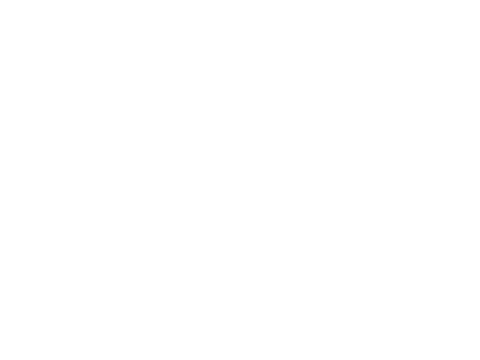

     animalid cohort                                         datasource  \
4633      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4633  20150730  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(684, 692)
N total response events:  676
N total outcome events:  676
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150730.mwk
N valid trials: 676
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7083333333333334), ('Blob_N2_y45', 0.8), ('Blob_N1_y45', 0.8), ('Blob_N1_y60', 1.0), ('Blob_N2_y15', 0.75), ('Blob_N1_y-30', 0.9583333333333334), ('Blob_N1_y-15', 0.84), ('Blob_N1_y0', 0.7972027972027972), ('Blob_N2_y30', 0.75), ('Blob_N1_y-45', 0.9583333333333334), ('Blob_N2_y-45', 0.625), ('Blo

<IPython.core.display.Javascript object>


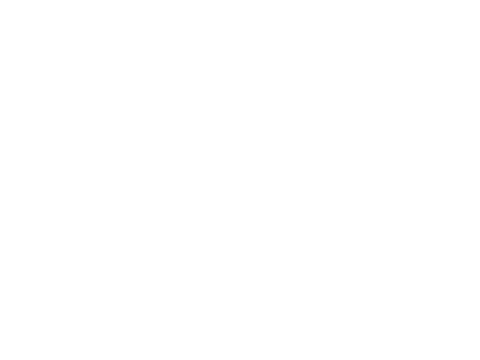

     animalid cohort                                         datasource  \
4634      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4634  20150803  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(294, 300)
N total response events:  287
N total outcome events:  287
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150803.mwk
N valid trials: 287
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8), ('Blob_N2_y45', 0.6), ('Blob_N1_y45', 0.8), ('Blob_N1_y60', 1.0), ('Blob_N2_y15', 0.8), ('Blob_N1_y-30', 0.9), ('Blob_N1_y-15', 0.9090909090909091), ('Blob_N1_y0', 0.6721311475409836), ('Blob_N2_y30', 0.7), ('Blob_N1_y-45', 1.0), ('Blob_N2_y-45', 0.8181818181818182), ('Blob_N2_y0', 0.60655737

<IPython.core.display.Javascript object>


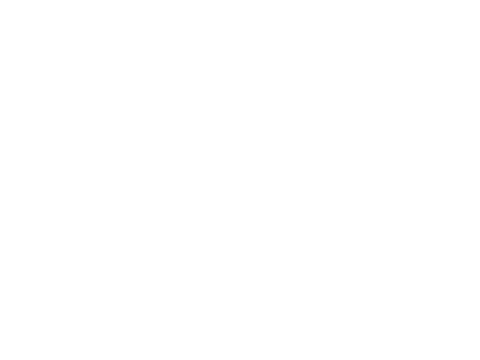

     animalid cohort                                         datasource  \
4635      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4635  20150804  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(489, 495)
N total response events:  482
N total outcome events:  482
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150804.mwk
N valid trials: 482
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.6111111111111112), ('Blob_N2_y45', 0.7647058823529411), ('Blob_N1_y45', 0.7647058823529411), ('Blob_N1_y60', 0.9411764705882353), ('Blob_N2_y15', 0.8823529411764706), ('Blob_N1_y-30', 0.7777777777777778), ('Blob_N1_y-15', 0.6111111111111112), ('Blob_N1_y0', 0.5865384615384616), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


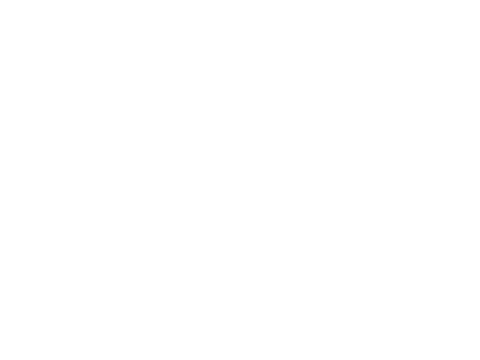

     animalid cohort                                         datasource  \
4636      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4636  20150805  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(627, 633)
N total response events:  621
N total outcome events:  621
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150805.mwk
N valid trials: 621
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7272727272727273), ('Blob_N2_y45', 0.782608695652174), ('Blob_N1_y45', 0.8181818181818182), ('Blob_N1_y60', 0.9090909090909091), ('Blob_N2_y15', 0.7727272727272727), ('Blob_N1_y-30', 0.7727272727272727), ('Blob_N1_y-15', 0.8181818181818182), ('Blob_N1_y0', 0.5909090909090909), ('Blob_N2_y30', 0.9

<IPython.core.display.Javascript object>


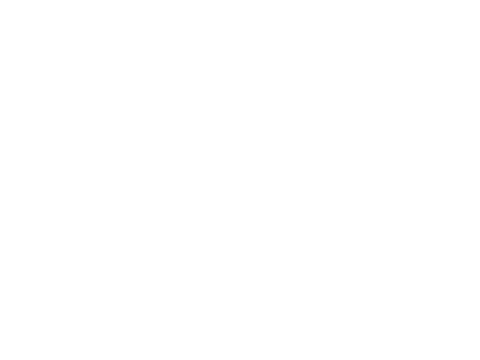

     animalid cohort                                         datasource  \
4637      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4637  20150901  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(343, 349)
N total response events:  332
N total outcome events:  332
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150901.mwk
N valid trials: 332
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.5454545454545454), ('Blob_N2_y45', 0.75), ('Blob_N1_y45', 0.9166666666666666), ('Blob_N1_y60', 1.0), ('Blob_N2_y15', 0.8333333333333334), ('Blob_N1_y-30', 0.6666666666666666), ('Blob_N1_y-15', 0.8333333333333334), ('Blob_N1_y0', 0.6527777777777778), ('Blob_N2_y30', 0.8181818181818182), ('Blob_N1_

<IPython.core.display.Javascript object>


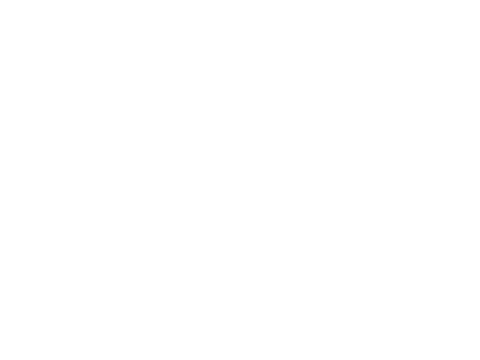

     animalid cohort                                         datasource  \
4638      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4638  20150902  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(546, 552)
N total response events:  539
N total outcome events:  539
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150902.mwk
N valid trials: 539
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8421052631578947), ('Blob_N2_y45', 0.7894736842105263), ('Blob_N1_y45', 0.7894736842105263), ('Blob_N1_y60', 0.8947368421052632), ('Blob_N2_y15', 0.7), ('Blob_N1_y-30', 0.75), ('Blob_N1_y-15', 0.8), ('Blob_N1_y0', 0.6923076923076923), ('Blob_N2_y30', 0.9473684210526315), ('Blob_N1_y-45', 0.842105

<IPython.core.display.Javascript object>


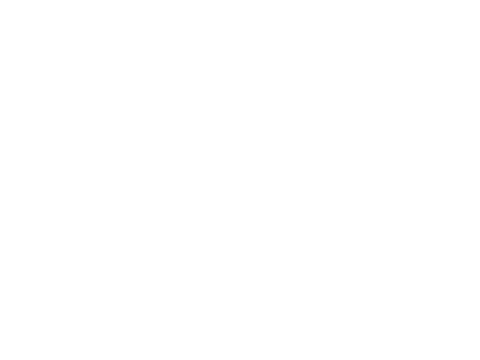

     animalid cohort                                         datasource  \
4639      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4639  20150903  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(615, 621)
N total response events:  608
N total outcome events:  608
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150903.mwk
N valid trials: 608
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8181818181818182), ('Blob_N2_y45', 0.7727272727272727), ('Blob_N1_y45', 0.9545454545454546), ('Blob_N1_y60', 0.9523809523809523), ('Blob_N2_y15', 0.7272727272727273), ('Blob_N1_y-30', 0.9523809523809523), ('Blob_N1_y-15', 0.8636363636363636), ('Blob_N1_y0', 0.7461538461538462), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


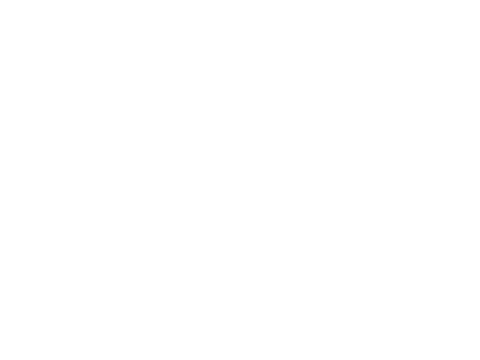

     animalid cohort                                         datasource  \
4640      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4640  20150914  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(364, 370)
N total response events:  359
N total outcome events:  359
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150914.mwk
N valid trials: 359
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7692307692307693), ('Blob_N2_y45', 0.7692307692307693), ('Blob_N1_y45', 0.8461538461538461), ('Blob_N1_y60', 1.0), ('Blob_N2_y15', 0.7692307692307693), ('Blob_N1_y-30', 0.7692307692307693), ('Blob_N1_y-15', 0.9230769230769231), ('Blob_N1_y0', 0.7792207792207793), ('Blob_N2_y30', 0.692307692307692

<IPython.core.display.Javascript object>


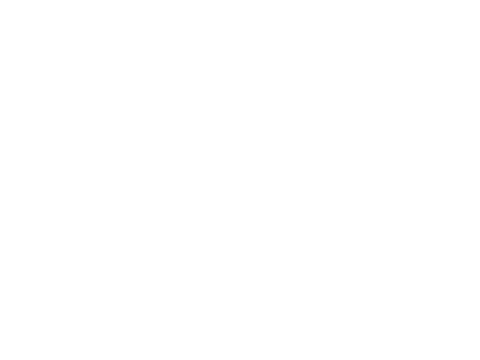

     animalid cohort                                         datasource  \
4641      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4641  20150915  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(642, 648)
N total response events:  636
N total outcome events:  636
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150915.mwk
N valid trials: 636
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.782608695652174), ('Blob_N2_y45', 0.8181818181818182), ('Blob_N1_y45', 0.9565217391304348), ('Blob_N1_y60', 0.9565217391304348), ('Blob_N2_y15', 1.0), ('Blob_N1_y-30', 0.9130434782608695), ('Blob_N1_y-15', 0.8260869565217391), ('Blob_N1_y0', 0.625), ('Blob_N2_y30', 0.7391304347826086), ('Blob_N1_

<IPython.core.display.Javascript object>


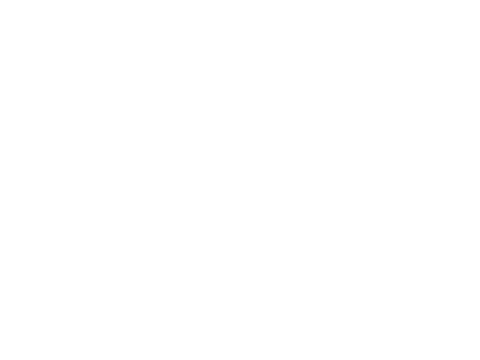

     animalid cohort                                         datasource  \
4642      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4642  20150917  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(947, 953)
N total response events:  930
N total outcome events:  930
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150917.mwk
N valid trials: 930
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.6666666666666666), ('Blob_N2_y45', 0.8181818181818182), ('Blob_N1_y45', 0.9696969696969697), ('Blob_N1_y60', 0.9393939393939394), ('Blob_N2_y15', 0.7352941176470589), ('Blob_N1_y-30', 0.9117647058823529), ('Blob_N1_y-15', 0.8823529411764706), ('Blob_N1_y0', 0.7688442211055276), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


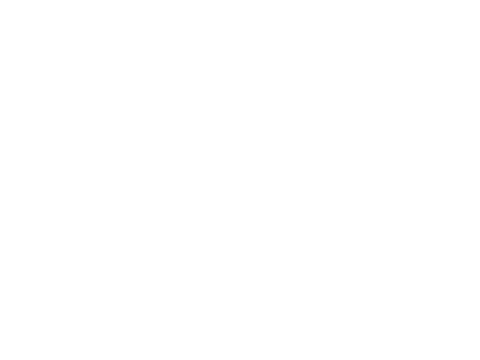

     animalid cohort                                         datasource  \
4643      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4643  20150918  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(582, 588)
N total response events:  574
N total outcome events:  574
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150918.mwk
N valid trials: 574
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8095238095238095), ('Blob_N2_y45', 0.9), ('Blob_N1_y45', 0.9047619047619048), ('Blob_N1_y60', 0.95), ('Blob_N2_y15', 0.9047619047619048), ('Blob_N1_y-30', 1.0), ('Blob_N1_y-15', 1.0), ('Blob_N1_y0', 0.7235772357723578), ('Blob_N2_y30', 0.8571428571428571), ('Blob_N1_y-45', 1.0), ('Blob_N2_y-45', 

<IPython.core.display.Javascript object>


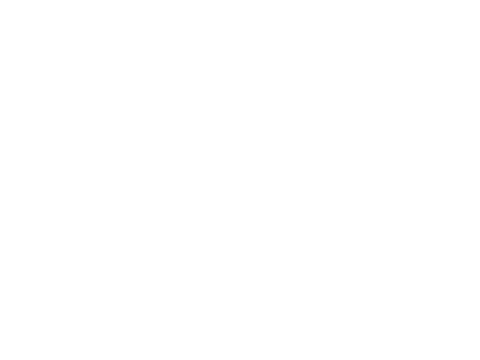

     animalid cohort                                         datasource  \
4644      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4644  20150928  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(438, 444)
N total response events:  431
N total outcome events:  431
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150928.mwk
N valid trials: 431
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.6666666666666666), ('Blob_N2_y45', 0.8), ('Blob_N1_y45', 1.0), ('Blob_N1_y60', 0.8666666666666667), ('Blob_N2_y15', 0.8666666666666667), ('Blob_N1_y-30', 0.875), ('Blob_N1_y-15', 0.8666666666666667), ('Blob_N1_y0', 0.6847826086956522), ('Blob_N2_y30', 0.625), ('Blob_N1_y-45', 0.8125), ('Blob_N2_y

<IPython.core.display.Javascript object>


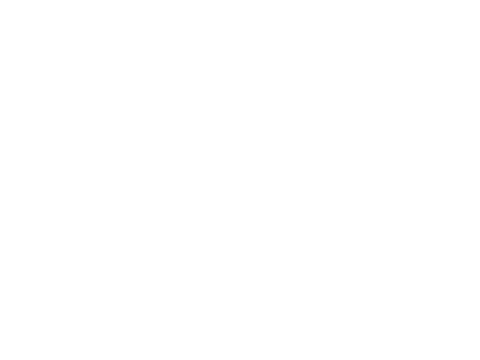

     animalid cohort                                         datasource  \
4645      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4645  20151028  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(423, 429)
N total response events:  416
N total outcome events:  416
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151028.mwk
N valid trials: 416
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.4666666666666667), ('Blob_N2_y45', 0.6666666666666666), ('Blob_N1_y45', 0.8666666666666667), ('Blob_N1_y60', 0.6), ('Blob_N2_y15', 0.8), ('Blob_N1_y-30', 0.8666666666666667), ('Blob_N1_y-15', 0.6), ('Blob_N1_y0', 0.5730337078651685), ('Blob_N2_y30', 0.8666666666666667), ('Blob_N1_y-45', 0.5333333

<IPython.core.display.Javascript object>


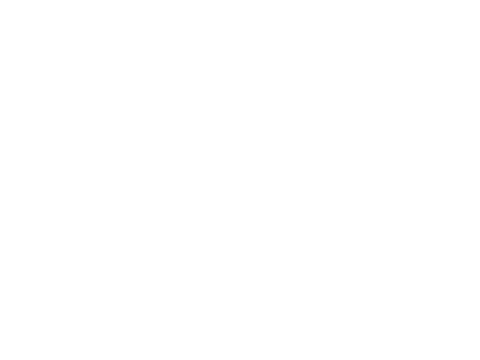

     animalid cohort                                         datasource  \
4646      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4646  20151029  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(545, 551)
N total response events:  532
N total outcome events:  532
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151029.mwk
N valid trials: 532
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8421052631578947), ('Blob_N2_y45', 0.5789473684210527), ('Blob_N1_y45', 0.9473684210526315), ('Blob_N1_y60', 0.8421052631578947), ('Blob_N2_y15', 0.7368421052631579), ('Blob_N1_y-30', 0.9473684210526315), ('Blob_N1_y-15', 0.7222222222222222), ('Blob_N1_y0', 0.6902654867256637), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


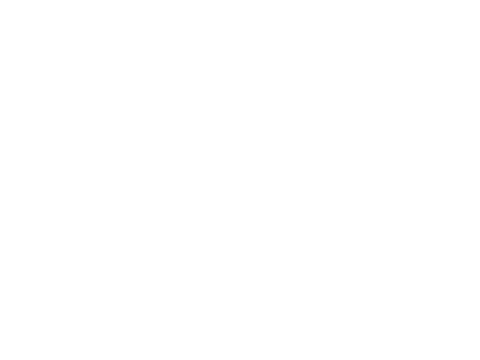

     animalid cohort                                         datasource  \
4647      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4647  20151030  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(664, 670)
N total response events:  658
N total outcome events:  658
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151030.mwk
N valid trials: 658
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7916666666666666), ('Blob_N2_y45', 0.8260869565217391), ('Blob_N1_y45', 1.0), ('Blob_N1_y60', 0.9583333333333334), ('Blob_N2_y15', 0.9583333333333334), ('Blob_N1_y-30', 0.9130434782608695), ('Blob_N1_y-15', 0.75), ('Blob_N1_y0', 0.7428571428571429), ('Blob_N2_y30', 0.9166666666666666), ('Blob_N1_

<IPython.core.display.Javascript object>


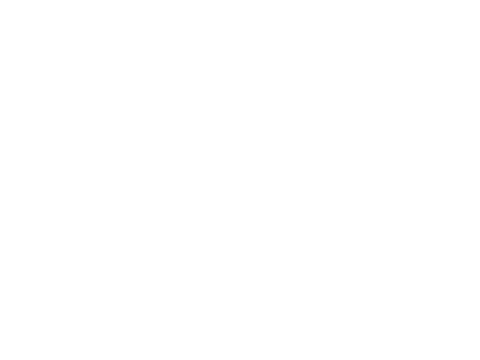

     animalid cohort                                         datasource  \
4648      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4648  20151102  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(259, 265)
N total response events:  251
N total outcome events:  251
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151102.mwk
N valid trials: 251
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8888888888888888), ('Blob_N2_y45', 0.7777777777777778), ('Blob_N1_y45', 0.8888888888888888), ('Blob_N1_y60', 1.0), ('Blob_N2_y15', 0.8888888888888888), ('Blob_N1_y-30', 0.6666666666666666), ('Blob_N1_y-15', 0.7777777777777778), ('Blob_N1_y0', 0.7592592592592593), ('Blob_N2_y30', 1.0), ('Blob_N1_y

<IPython.core.display.Javascript object>


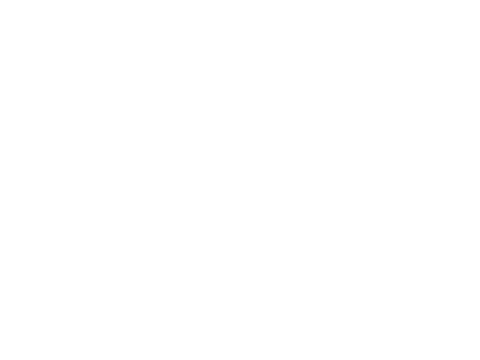

     animalid cohort                                         datasource  \
4649      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4649  20151110  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(448, 454)
N total response events:  445
N total outcome events:  445
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151110.mwk
N valid trials: 445
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.75), ('Blob_N2_y45', 0.6666666666666666), ('Blob_N1_y45', 1.0), ('Blob_N1_y60', 0.9375), ('Blob_N2_y15', 0.5), ('Blob_N1_y-30', 1.0), ('Blob_N1_y-15', 1.0), ('Blob_N1_y0', 0.6947368421052632), ('Blob_N2_y30', 0.6875), ('Blob_N1_y-45', 0.9375), ('Blob_N2_y-45', 0.5), ('Blob_N2_y0', 0.6875), ('Blob

<IPython.core.display.Javascript object>


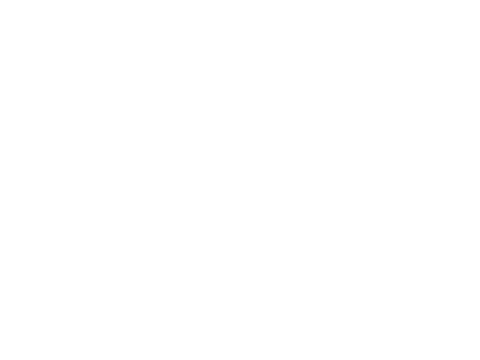

     animalid cohort                                         datasource  \
4650      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4650  20151112  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(485, 491)
N total response events:  480
N total outcome events:  480
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151112.mwk
N valid trials: 480
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.5294117647058824), ('Blob_N2_y45', 0.8235294117647058), ('Blob_N1_y45', 1.0), ('Blob_N1_y60', 0.9444444444444444), ('Blob_N2_y15', 0.8235294117647058), ('Blob_N1_y-30', 0.8235294117647058), ('Blob_N1_y-15', 0.8333333333333334), ('Blob_N1_y0', 0.6116504854368932), ('Blob_N2_y30', 0.823529411764705

<IPython.core.display.Javascript object>


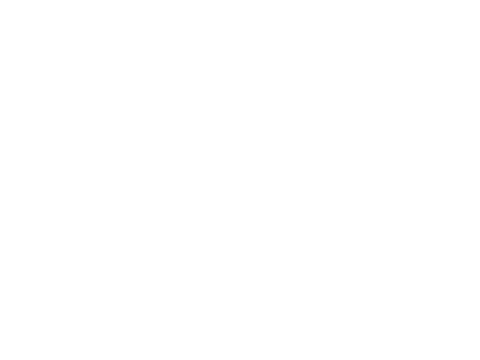

     animalid cohort                                         datasource  \
4651      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4651  20151117  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
... Getting session summary ...
... Getting stimulus counts ...
--- no trials ---
     animalid cohort                                         datasource  \
4652      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4652  20151118  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
... Getting session summary ...
... Getting stimulus counts ...
--- no trials ---
     animalid cohort                                         datasource  \
4653      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

   

<IPython.core.display.Javascript object>


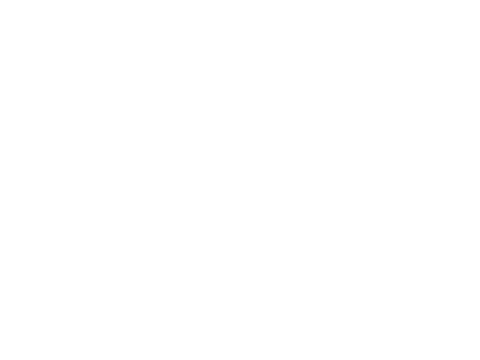

     animalid cohort                                         datasource  \
4654      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4654  20151120  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(633, 639)
N total response events:  625
N total outcome events:  625
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151120.mwk
N valid trials: 625
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8484848484848485), ('Blob_N2_y45', 0.75), ('Blob_N1_y45', 0.6666666666666666), ('Blob_N1_y60', 0.65625), ('Blob_N2_y15', 0.8611111111111112), ('Blob_N1_y-30', 0.5294117647058824), ('Blob_N1_y-15', 0.5714285714285714), ('Blob_N1_y0', 0.6857142857142857), ('Blob_N2_y30', 0.7428571428571429), ('Blob

<IPython.core.display.Javascript object>


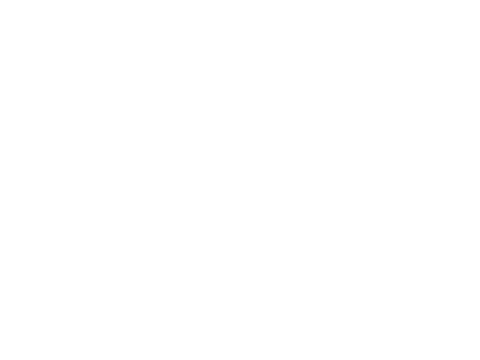

     animalid cohort                                         datasource  \
4655      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4655  20151121  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(874, 880)
N total response events:  867
N total outcome events:  867
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151121.mwk
N valid trials: 867
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7708333333333334), ('Blob_N2_y45', 0.8163265306122449), ('Blob_N1_y45', 0.6458333333333334), ('Blob_N1_y60', 0.7872340425531915), ('Blob_N2_y15', 0.7959183673469388), ('Blob_N1_y-30', 0.7291666666666666), ('Blob_N1_y-15', 0.6458333333333334), ('Blob_N1_y0', 0.6875), ('Blob_N2_y30', 0.857142857142

<IPython.core.display.Javascript object>


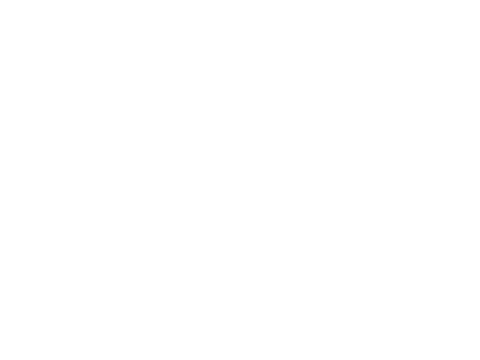

     animalid cohort                                         datasource  \
4656      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4656  20151123  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(388, 394)
N total response events:  378
N total outcome events:  378
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151123.mwk
N valid trials: 378
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8095238095238095), ('Blob_N2_y45', 0.8421052631578947), ('Blob_N1_y45', 0.8095238095238095), ('Blob_N1_y60', 0.7619047619047619), ('Blob_N2_y15', 0.7727272727272727), ('Blob_N1_y-30', 0.625), ('Blob_N1_y-15', 0.7222222222222222), ('Blob_N1_y0', 0.7), ('Blob_N2_y30', 1.0), ('Blob_N1_y-45', 0.63636

<IPython.core.display.Javascript object>


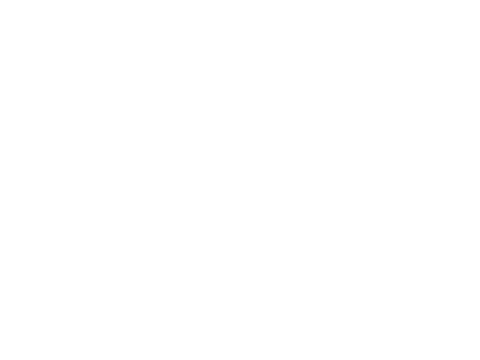

     animalid cohort                                         datasource  \
4657      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4657  20151201  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(556, 562)
N total response events:  548
N total outcome events:  548
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151201.mwk
N valid trials: 548
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7), ('Blob_N2_y45', 0.8), ('Blob_N1_y45', 0.6333333333333333), ('Blob_N1_y60', 0.7419354838709677), ('Blob_N2_y15', 0.9), ('Blob_N1_y-30', 0.6129032258064516), ('Blob_N1_y-15', 0.6666666666666666), ('Blob_N1_y0', 0.7666666666666667), ('Blob_N2_y30', 0.7), ('Blob_N1_y-45', 0.7666666666666667), ('B

<IPython.core.display.Javascript object>


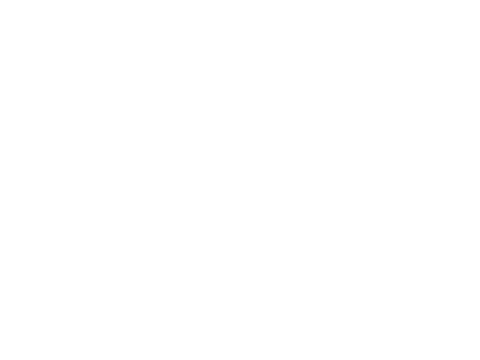

     animalid cohort                                         datasource  \
4658      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4658  20151202  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(798, 804)
N total response events:  793
N total outcome events:  793
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151202.mwk
N valid trials: 793
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.75), ('Blob_N2_y45', 0.6739130434782609), ('Blob_N1_y45', 0.6744186046511628), ('Blob_N1_y60', 0.7674418604651163), ('Blob_N2_y15', 0.7906976744186046), ('Blob_N1_y-30', 0.7209302325581395), ('Blob_N1_y-15', 0.6521739130434783), ('Blob_N1_y0', 0.6666666666666666), ('Blob_N2_y30', 0.77777777777777

<IPython.core.display.Javascript object>


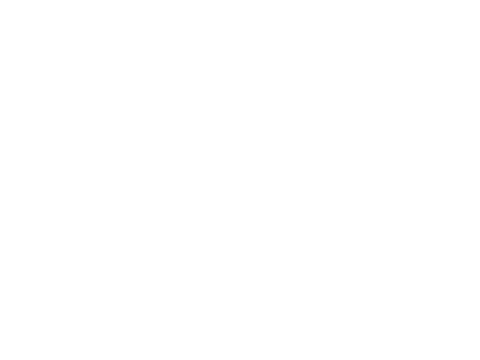

     animalid cohort                                         datasource  \
4659      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4659  20151203  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(935, 941)
N total response events:  927
N total outcome events:  927
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151203.mwk
N valid trials: 927
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.6923076923076923), ('Blob_N2_y45', 0.803921568627451), ('Blob_N1_y45', 0.7450980392156863), ('Blob_N1_y60', 0.8518518518518519), ('Blob_N2_y15', 0.8846153846153846), ('Blob_N1_y-30', 0.66), ('Blob_N1_y-15', 0.6862745098039216), ('Blob_N1_y0', 0.62), ('Blob_N2_y30', 0.9038461538461539), ('Blob_N1_

<IPython.core.display.Javascript object>


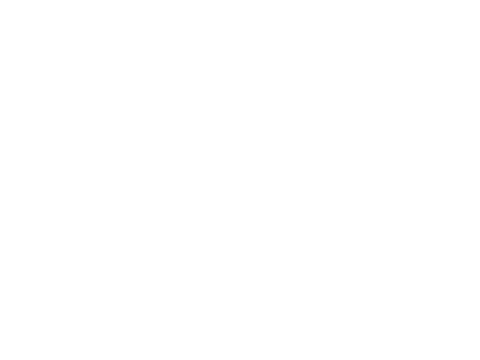

     animalid cohort                                         datasource  \
4660      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4660  20151204  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(998, 1004)
N total response events:  994
N total outcome events:  994
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151204.mwk
N valid trials: 994
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7017543859649122), ('Blob_N2_y45', 0.7962962962962963), ('Blob_N1_y45', 0.8214285714285714), ('Blob_N1_y60', 0.7222222222222222), ('Blob_N2_y15', 0.8518518518518519), ('Blob_N1_y-30', 0.7636363636363637), ('Blob_N1_y-15', 0.7017543859649122), ('Blob_N1_y0', 0.6545454545454545), ('Blob_N2_y30', 0

<IPython.core.display.Javascript object>


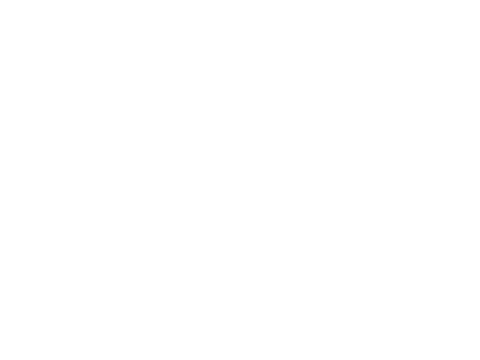

     animalid cohort                                         datasource  \
4661      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4661  20151208  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(506, 512)
N total response events:  500
N total outcome events:  500
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151208.mwk
N valid trials: 500
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.6785714285714286), ('Blob_N2_y45', 0.7777777777777778), ('Blob_N1_y45', 0.7857142857142857), ('Blob_N1_y60', 0.7586206896551724), ('Blob_N2_y15', 0.8666666666666667), ('Blob_N1_y-30', 0.7241379310344828), ('Blob_N1_y-15', 0.5555555555555556), ('Blob_N1_y0', 0.7307692307692307), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


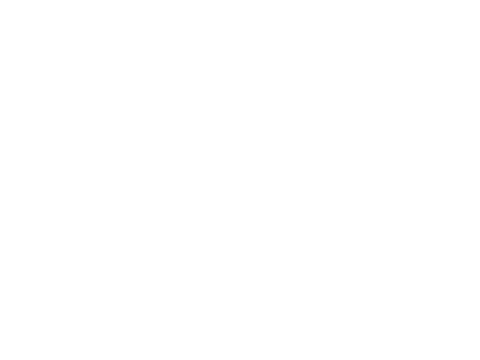

     animalid cohort                                         datasource  \
4662      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4662  20151209  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(777, 783)
N total response events:  771
N total outcome events:  771
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151209.mwk
N valid trials: 771
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7380952380952381), ('Blob_N2_y45', 0.7727272727272727), ('Blob_N1_y45', 0.8181818181818182), ('Blob_N1_y60', 0.7906976744186046), ('Blob_N2_y15', 0.813953488372093), ('Blob_N1_y-30', 0.7674418604651163), ('Blob_N1_y-15', 0.6666666666666666), ('Blob_N1_y0', 0.7209302325581395), ('Blob_N2_y30', 0.9

<IPython.core.display.Javascript object>


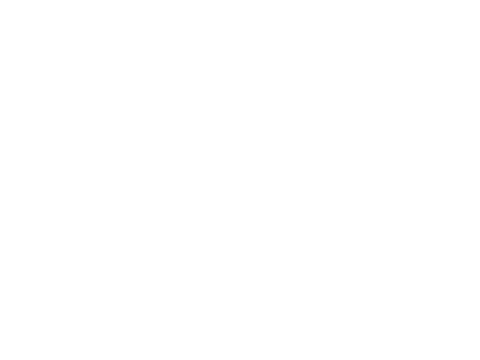

     animalid cohort                                         datasource  \
4663      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4663  20151215  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(329, 335)
N total response events:  320
N total outcome events:  320
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151215.mwk
N valid trials: 320
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7777777777777778), ('Blob_N2_y45', 0.7222222222222222), ('Blob_N1_y45', 0.6111111111111112), ('Blob_N1_y60', 0.8888888888888888), ('Blob_N2_y15', 0.8888888888888888), ('Blob_N1_y-30', 0.5555555555555556), ('Blob_N1_y-15', 0.7058823529411765), ('Blob_N1_y0', 0.375), ('Blob_N2_y30', 0.8888888888888

<IPython.core.display.Javascript object>


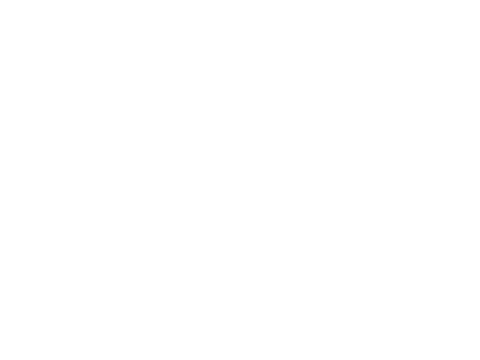

     animalid cohort                                         datasource  \
4664      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4664  20151216  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(788, 794)
N total response events:  783
N total outcome events:  783
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151216.mwk
N valid trials: 783
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7674418604651163), ('Blob_N2_y45', 0.813953488372093), ('Blob_N1_y45', 0.6511627906976745), ('Blob_N1_y60', 0.7272727272727273), ('Blob_N2_y15', 0.8636363636363636), ('Blob_N1_y-30', 0.627906976744186), ('Blob_N1_y-15', 0.46511627906976744), ('Blob_N1_y0', 0.6744186046511628), ('Blob_N2_y30', 0.8

<IPython.core.display.Javascript object>


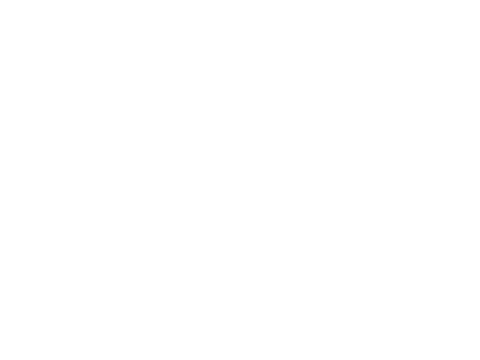

     animalid cohort                                         datasource  \
4665      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4665  20151217  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(819, 825)
N total response events:  801
N total outcome events:  801
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_151217.mwk
N valid trials: 801
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.6956521739130435), ('Blob_N2_y45', 0.7608695652173914), ('Blob_N1_y45', 0.7272727272727273), ('Blob_N1_y60', 0.7333333333333333), ('Blob_N2_y15', 0.8913043478260869), ('Blob_N1_y-30', 0.627906976744186), ('Blob_N1_y-15', 0.6136363636363636), ('Blob_N1_y0', 0.6444444444444445), ('Blob_N2_y30', 0.7

<IPython.core.display.Javascript object>


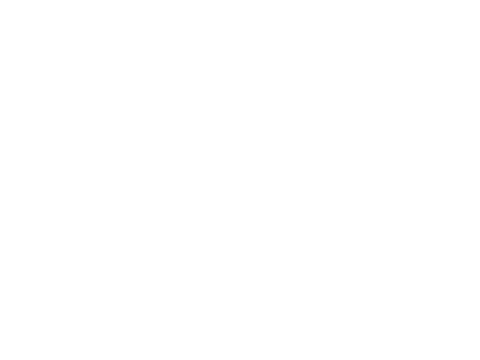

     animalid cohort                                         datasource  \
4666      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4666  20160111  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(304, 310)
N total response events:  295
N total outcome events:  295
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160111.mwk
N valid trials: 295
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.6875), ('Blob_N2_y45', 0.8235294117647058), ('Blob_N1_y45', 0.6875), ('Blob_N1_y60', 0.75), ('Blob_N2_y15', 0.8235294117647058), ('Blob_N1_y-30', 0.625), ('Blob_N1_y-15', 0.4375), ('Blob_N1_y0', 0.6111111111111112), ('Blob_N2_y30', 0.9285714285714286), ('Blob_N1_y-45', 0.6111111111111112), ('Blob

<IPython.core.display.Javascript object>


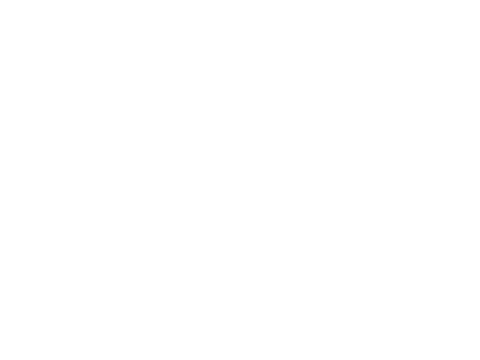

     animalid cohort                                         datasource  \
4667      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4667  20160113  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(679, 685)
N total response events:  676
N total outcome events:  676
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160113.mwk
N valid trials: 676
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.825), ('Blob_N2_y45', 0.8421052631578947), ('Blob_N1_y45', 0.7567567567567568), ('Blob_N1_y60', 0.7105263157894737), ('Blob_N2_y15', 0.8888888888888888), ('Blob_N1_y-30', 0.6216216216216216), ('Blob_N1_y-15', 0.4722222222222222), ('Blob_N1_y0', 0.5675675675675675), ('Blob_N2_y30', 0.9189189189189

<IPython.core.display.Javascript object>


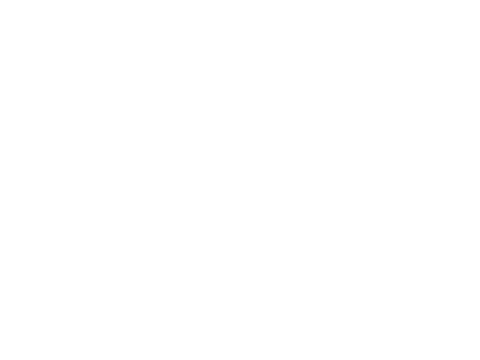

     animalid cohort                                         datasource  \
4668      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4668  20160121  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(408, 414)
N total response events:  398
N total outcome events:  398
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160121.mwk
N valid trials: 398
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8181818181818182), ('Blob_N2_y45', 0.782608695652174), ('Blob_N1_y45', 0.7391304347826086), ('Blob_N1_y60', 0.6818181818181818), ('Blob_N2_y15', 0.9166666666666666), ('Blob_N1_y-30', 0.7391304347826086), ('Blob_N1_y-15', 0.42857142857142855), ('Blob_N1_y0', 0.45454545454545453), ('Blob_N2_y30', 0

<IPython.core.display.Javascript object>


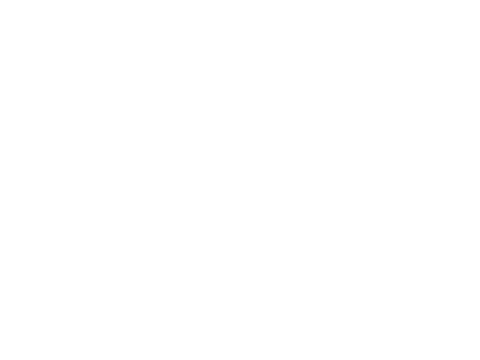

     animalid cohort                                         datasource  \
4669      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4669  20160122  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(667, 673)
N total response events:  662
N total outcome events:  662
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160122.mwk
N valid trials: 662
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.6756756756756757), ('Blob_N2_y45', 0.7777777777777778), ('Blob_N1_y45', 0.8648648648648649), ('Blob_N1_y60', 0.8378378378378378), ('Blob_N2_y15', 0.8648648648648649), ('Blob_N1_y-30', 0.5789473684210527), ('Blob_N1_y-15', 0.4722222222222222), ('Blob_N1_y0', 0.6578947368421053), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


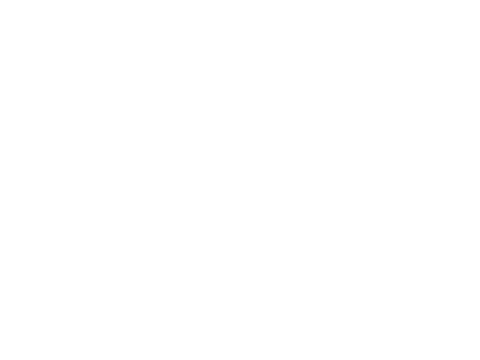

     animalid cohort                                         datasource  \
4670      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4670  20160125  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(425, 431)
N total response events:  419
N total outcome events:  419
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160125.mwk
N valid trials: 419
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.782608695652174), ('Blob_N2_y45', 0.7391304347826086), ('Blob_N1_y45', 0.8333333333333334), ('Blob_N1_y60', 0.8695652173913043), ('Blob_N2_y15', 0.875), ('Blob_N1_y-30', 0.6521739130434783), ('Blob_N1_y-15', 0.5), ('Blob_N1_y0', 0.43478260869565216), ('Blob_N2_y30', 0.8333333333333334), ('Blob_N1

<IPython.core.display.Javascript object>


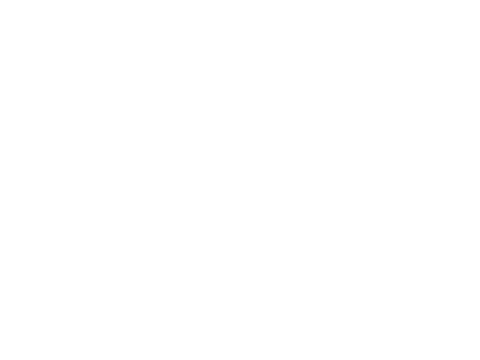

     animalid cohort                                         datasource  \
4671      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4671  20160126  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(608, 614)
N total response events:  604
N total outcome events:  604
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160126.mwk
N valid trials: 604
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8823529411764706), ('Blob_N2_y45', 0.84375), ('Blob_N1_y45', 0.6571428571428571), ('Blob_N1_y60', 0.7575757575757576), ('Blob_N2_y15', 0.8484848484848485), ('Blob_N1_y-30', 0.7352941176470589), ('Blob_N1_y-15', 0.59375), ('Blob_N1_y0', 0.5757575757575758), ('Blob_N2_y30', 0.9142857142857143), ('B

<IPython.core.display.Javascript object>


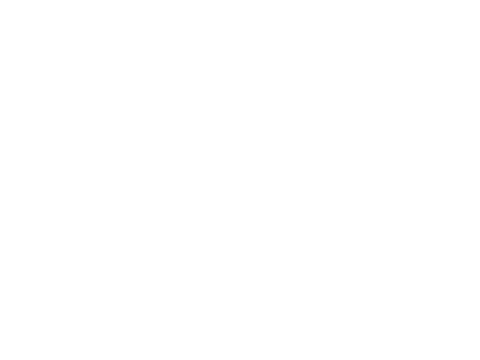

     animalid cohort                                         datasource  \
4672      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4672  20160127  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(771, 777)
N total response events:  765
N total outcome events:  765
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160127.mwk
N valid trials: 765
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y45', 0.8888888888888888), ('Blob_N1_y60', 0.8333333333333334), ('Blob_N1_y-15', 0.7222222222222222), ('Blob_N2_y-30', 0.9411764705882353), ('Blob_N1_y45', 0.5882352941176471), ('Blob_N1_y-15', 0.47058823529411764), ('Blob_N2_y-15', 0.8181818181818182), ('Blob_N2_y30', 0.6), ('Blob_N2_y0', 0.944444444444

<IPython.core.display.Javascript object>


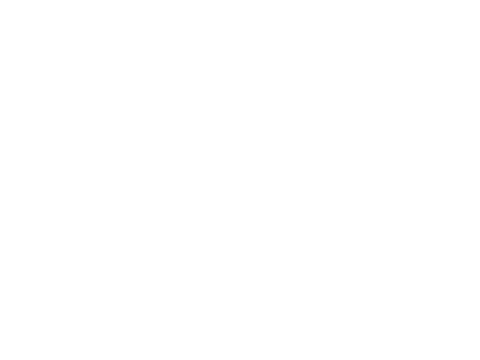

     animalid cohort                                         datasource  \
4673      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4673  20160128  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(764, 770)
N total response events:  761
N total outcome events:  761
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160128.mwk
N valid trials: 761
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y45', 0.8235294117647058), ('Blob_N1_y60', 0.8125), ('Blob_N1_y-15', 0.875), ('Blob_N2_y-30', 0.8421052631578947), ('Blob_N1_y45', 0.9411764705882353), ('Blob_N1_y-15', 0.5714285714285714), ('Blob_N2_y-15', 0.7142857142857143), ('Blob_N2_y30', 0.6153846153846154), ('Blob_N2_y0', 1.0), ('Blob_N1_y0', 0.66

<IPython.core.display.Javascript object>


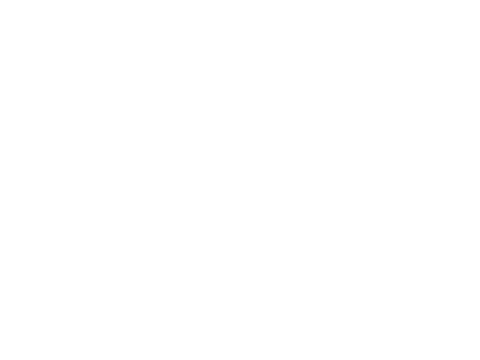

     animalid cohort                                         datasource  \
4674      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4674  20160202  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(732, 738)
N total response events:  728
N total outcome events:  728
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160202.mwk
N valid trials: 728
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y45', 0.9444444444444444), ('Blob_N1_y60', 0.8666666666666667), ('Blob_N1_y-15', 0.8235294117647058), ('Blob_N2_y-30', 0.8), ('Blob_N1_y45', 0.7368421052631579), ('Blob_N1_y-15', 0.631578947368421), ('Blob_N2_y-15', 0.8571428571428571), ('Blob_N2_y30', 0.7142857142857143), ('Blob_N2_y0', 0.88888888888888

<IPython.core.display.Javascript object>


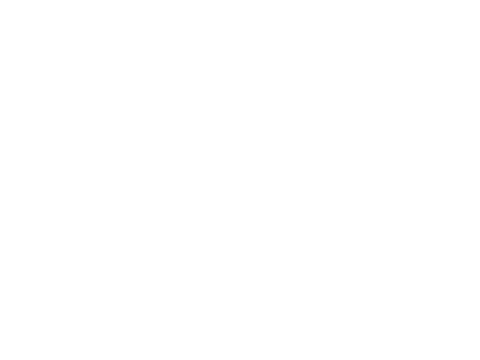

     animalid cohort                                         datasource  \
4675      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4675  20160203  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(763, 769)
N total response events:  759
N total outcome events:  759
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160203.mwk
N valid trials: 759
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y45', 0.9444444444444444), ('Blob_N1_y60', 0.8571428571428571), ('Blob_N1_y-15', 0.8333333333333334), ('Blob_N2_y-30', 0.8421052631578947), ('Blob_N1_y45', 0.6), ('Blob_N1_y-15', 0.5555555555555556), ('Blob_N2_y-15', 0.8823529411764706), ('Blob_N2_y30', 0.7692307692307693), ('Blob_N2_y0', 0.9), ('Blob_N1

<IPython.core.display.Javascript object>


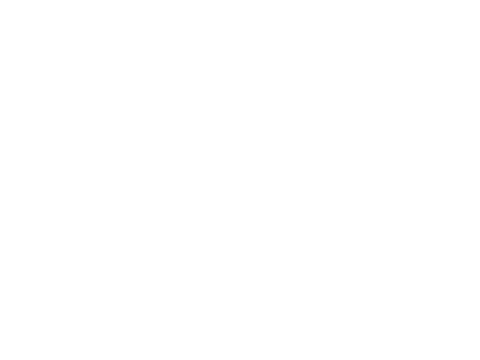

     animalid cohort                                         datasource  \
4676      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4676  20160204  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(843, 849)
N total response events:  839
N total outcome events:  839
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160204.mwk
N valid trials: 839
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y45', 0.95), ('Blob_N1_y60', 0.9090909090909091), ('Blob_N1_y-15', 0.6153846153846154), ('Blob_N2_y-30', 1.0), ('Blob_N1_y45', 0.75), ('Blob_N1_y-15', 0.46153846153846156), ('Blob_N2_y-15', 0.8695652173913043), ('Blob_N2_y30', 0.9090909090909091), ('Blob_N2_y0', 0.9642857142857143), ('Blob_N1_y0', 0.6666

<IPython.core.display.Javascript object>


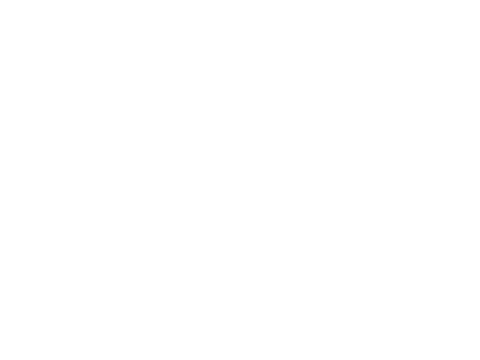

     animalid cohort                                         datasource  \
4677      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4677  20160205  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(757, 763)
N total response events:  753
N total outcome events:  753
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160205.mwk
N valid trials: 753
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y45', 1.0), ('Blob_N1_y60', 0.7857142857142857), ('Blob_N1_y-15', 0.46153846153846156), ('Blob_N2_y-30', 0.8333333333333334), ('Blob_N1_y45', 0.8823529411764706), ('Blob_N1_y-15', 0.6111111111111112), ('Blob_N2_y-15', 1.0), ('Blob_N2_y30', 0.9545454545454546), ('Blob_N2_y0', 0.8333333333333334), ('Blob_N

<IPython.core.display.Javascript object>


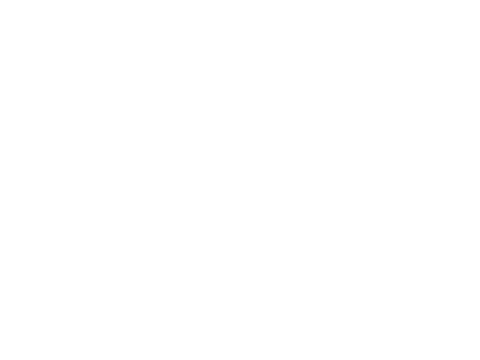

     animalid cohort                                         datasource  \
4678      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4678  20160208  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(381, 387)
N total response events:  376
N total outcome events:  376
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160208.mwk
N valid trials: 376
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y45', 1.0), ('Blob_N1_y60', 0.6666666666666666), ('Blob_N1_y-15', 0.375), ('Blob_N2_y-30', 0.9230769230769231), ('Blob_N1_y45', 0.6666666666666666), ('Blob_N1_y-15', 0.5714285714285714), ('Blob_N2_y-15', 0.6), ('Blob_N2_y30', 0.8), ('Blob_N2_y0', 1.0), ('Blob_N1_y0', 0.7777777777777778), ('Blob_N2_y-30',

<IPython.core.display.Javascript object>


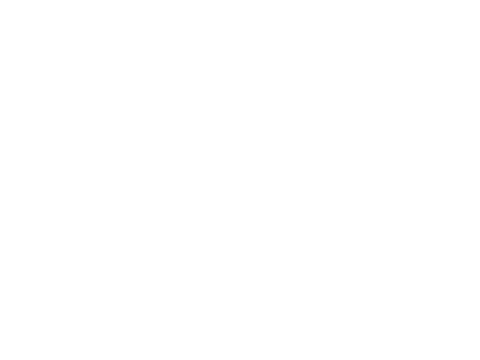

     animalid cohort                                         datasource  \
4679      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4679  20160209  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(777, 783)
N total response events:  772
N total outcome events:  772
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160209.mwk
N valid trials: 772
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y45', 0.875), ('Blob_N1_y60', 0.6842105263157895), ('Blob_N1_y-15', 0.5625), ('Blob_N2_y-30', 1.0), ('Blob_N1_y45', 0.782608695652174), ('Blob_N1_y-15', 0.42105263157894735), ('Blob_N2_y-15', 0.8823529411764706), ('Blob_N2_y30', 0.9), ('Blob_N2_y0', 0.9375), ('Blob_N1_y0', 0.5454545454545454), ('Blob_N2_

<IPython.core.display.Javascript object>


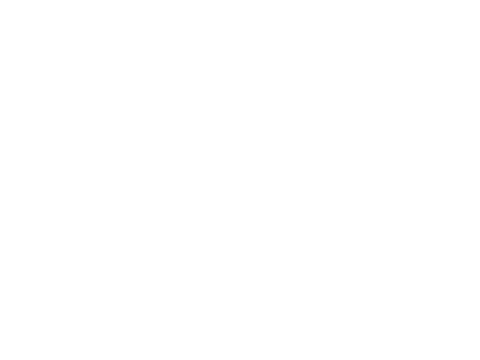

     animalid cohort                                         datasource  \
4680      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4680  20160210  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(740, 746)
N total response events:  735
N total outcome events:  735
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160210.mwk
N valid trials: 735
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y45', 0.8125), ('Blob_N1_y60', 0.8421052631578947), ('Blob_N1_y-15', 0.5789473684210527), ('Blob_N2_y-30', 0.8666666666666667), ('Blob_N1_y45', 0.9285714285714286), ('Blob_N1_y-15', 0.5), ('Blob_N2_y-15', 0.75), ('Blob_N2_y30', 0.8333333333333334), ('Blob_N2_y0', 1.0), ('Blob_N1_y0', 0.75), ('Blob_N2_y-3

<IPython.core.display.Javascript object>


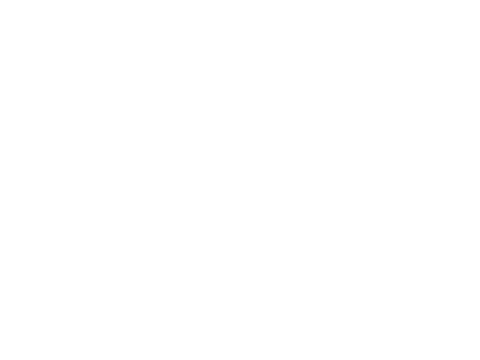

     animalid cohort                                         datasource  \
4681      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4681  20160211  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(894, 900)
N total response events:  887
N total outcome events:  887
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160211.mwk
N valid trials: 887
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y45', 0.9411764705882353), ('Blob_N1_y60', 0.8888888888888888), ('Blob_N1_y-15', 0.5454545454545454), ('Blob_N2_y-30', 0.8636363636363636), ('Blob_N1_y45', 0.7894736842105263), ('Blob_N1_y-15', 0.5652173913043478), ('Blob_N2_y-15', 0.9166666666666666), ('Blob_N2_y30', 0.7391304347826086), ('Blob_N2_y0', 

<IPython.core.display.Javascript object>


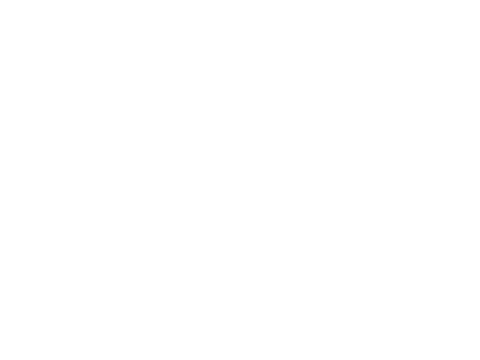

     animalid cohort                                         datasource  \
4682      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4683      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4682  20160212  
4683  20160212  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(984, 990)
N total response events:  979
N total outcome events:  979
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160212.mwk
N valid trials: 979
***** Parsing trials *****
(181, 187)
N total response events:  177
N total outcome events:  177
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160212b.mwk
N valid trials: 177
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by 

<IPython.core.display.Javascript object>


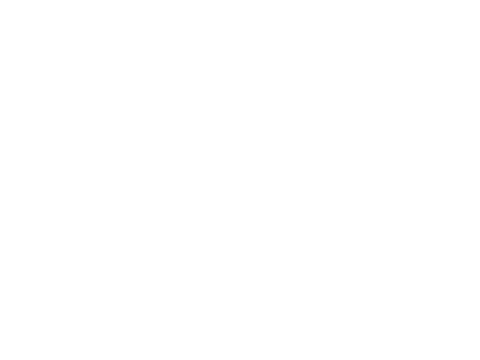

     animalid cohort                                         datasource  \
4682      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4683      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4682  20160212  
4683  20160212  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7777777777777778), ('Blob_N2_y-60', 0.7083333333333334), ('Blob_N1_y60', 0.7647058823529411), ('Blob_N1_y15', 0.6111111111111112), ('Blob_N2_y-15', 0.7777777777777778), ('Blob_N2_y-30', 0.8), ('Blob_N1_y0', 0.4444444444444444), ('Blob_N1_y45', 0.7894736842105263), ('Blob_N2_y-30', 0.5714285714285714), ('Blob_N1_y30', 0.4), ('Blob_N1_y-15', 0.5294117647058824), ('Blob_N2_y-15', 0.7727272727272727), ('Blob_N2_y30', 0.9090909090909091), ('Blob_N2_y0', 0.8928571428571429), ('Blob_N1_y0', 0.666666666666666

<IPython.core.display.Javascript object>


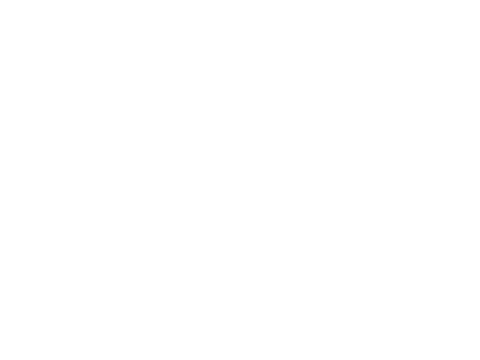

     animalid cohort                                         datasource  \
4684      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4684  20160213  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(796, 799)
N total response events:  793
N total outcome events:  793
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160213b.mwk
N valid trials: 793
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8085106382978723), ('Blob_N2_y45', 0.9285714285714286), ('Blob_N1_y45', 0.8936170212765957), ('Blob_N1_y60', 0.975), ('Blob_N2_y15', 0.8536585365853658), ('Blob_N1_y-30', 0.8666666666666667), ('Blob_N1_y-15', 0.5555555555555556), ('Blob_N1_y0', 0.6136363636363636), ('Blob_N2_y30', 0.866666666666

<IPython.core.display.Javascript object>


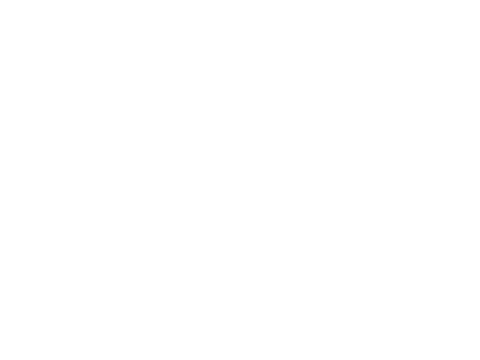

     animalid cohort                                         datasource  \
4685      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4685  20160215  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(607, 610)
N total response events:  603
N total outcome events:  603
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160215b.mwk
N valid trials: 603
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8484848484848485), ('Blob_N2_y45', 0.9354838709677419), ('Blob_N1_y45', 0.8), ('Blob_N1_y60', 0.9090909090909091), ('Blob_N2_y15', 0.9142857142857143), ('Blob_N1_y-30', 0.6764705882352942), ('Blob_N1_y-15', 0.65625), ('Blob_N1_y0', 0.45714285714285713), ('Blob_N2_y30', 0.9696969696969697), ('Blo

<IPython.core.display.Javascript object>


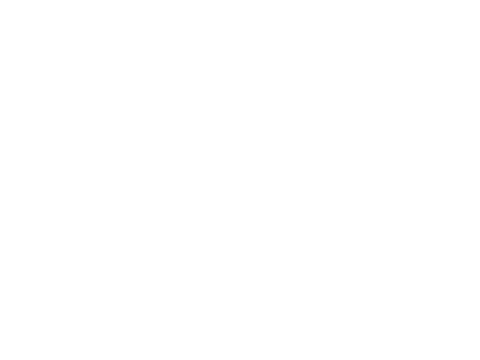

     animalid cohort                                         datasource  \
4686      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4686  20160216  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(843, 849)
N total response events:  839
N total outcome events:  839
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160216r.mwk
N valid trials: 839
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y-30', 0.8571428571428571), ('Blob_N2_y30', 0.8421052631578947), ('Blob_N2_y60', 1.0), ('Blob_N2_y-15', 0.8666666666666667), ('Blob_N1_y-15', 0.42857142857142855), ('Blob_N1_y0', 0.65), ('Blob_N2_y45', 0.7647058823529411), ('Blob_N1_y45', 0.7222222222222222), ('Blob_N2_y0', 1.0), ('Blob_N2_y45', 0.71428

<IPython.core.display.Javascript object>


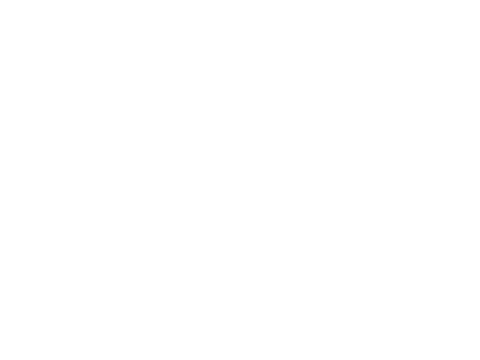

     animalid cohort                                         datasource  \
4687      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4687  20160217  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(730, 736)
N total response events:  727
N total outcome events:  727
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160217.mwk
N valid trials: 727
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y-30', 0.8181818181818182), ('Blob_N2_y30', 1.0), ('Blob_N2_y60', 0.6470588235294118), ('Blob_N2_y-15', 0.8333333333333334), ('Blob_N1_y-15', 0.5), ('Blob_N1_y0', 0.4), ('Blob_N2_y45', 0.8333333333333334), ('Blob_N1_y45', 0.8333333333333334), ('Blob_N2_y0', 1.0), ('Blob_N2_y45', 0.6153846153846154), ('Bl

<IPython.core.display.Javascript object>


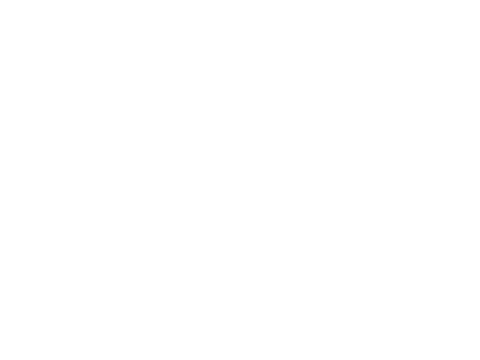

     animalid cohort                                         datasource  \
4688      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4688  20160218  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(885, 891)
N total response events:  880
N total outcome events:  880
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160218.mwk
N valid trials: 880
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y-30', 0.8823529411764706), ('Blob_N2_y30', 0.9375), ('Blob_N2_y60', 0.9), ('Blob_N2_y-15', 0.9), ('Blob_N1_y-15', 0.5555555555555556), ('Blob_N1_y0', 0.5789473684210527), ('Blob_N2_y45', 0.875), ('Blob_N1_y45', 0.8947368421052632), ('Blob_N2_y0', 1.0), ('Blob_N2_y45', 0.9047619047619048), ('Blob_N1_y0',

<IPython.core.display.Javascript object>


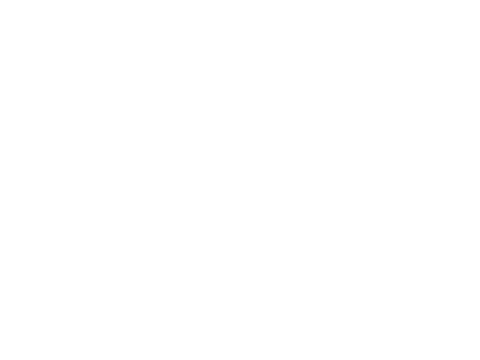

     animalid cohort                                         datasource  \
4689      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4689  20160223  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(383, 389)
N total response events:  378
N total outcome events:  378
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160223.mwk
N valid trials: 378
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y-30', 0.75), ('Blob_N2_y30', 1.0), ('Blob_N2_y60', 1.0), ('Blob_N2_y-15', 1.0), ('Blob_N1_y-15', 0.375), ('Blob_N1_y0', 0.45454545454545453), ('Blob_N2_y45', 0.6666666666666666), ('Blob_N1_y45', 0.5), ('Blob_N2_y0', 1.0), ('Blob_N2_y45', 0.7692307692307693), ('Blob_N1_y0', 0.4), ('Blob_N2_y-15', 0.85714

<IPython.core.display.Javascript object>


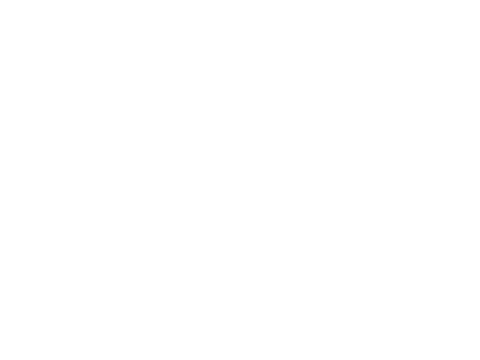

     animalid cohort                                         datasource  \
4690      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4690  20160225  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(685, 691)
N total response events:  679
N total outcome events:  679
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160225.mwk
N valid trials: 679
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y-30', 0.9), ('Blob_N2_y30', 0.8), ('Blob_N2_y60', 0.7647058823529411), ('Blob_N2_y-15', 1.0), ('Blob_N1_y-15', 0.5), ('Blob_N1_y0', 0.6363636363636364), ('Blob_N2_y45', 0.9), ('Blob_N1_y45', 0.7894736842105263), ('Blob_N2_y0', 1.0), ('Blob_N2_y45', 0.7368421052631579), ('Blob_N1_y0', 0.6428571428571429)

<IPython.core.display.Javascript object>


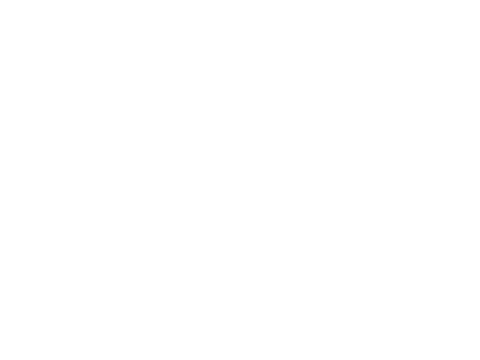

     animalid cohort                                         datasource  \
4691      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4691  20160226  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(848, 854)
N total response events:  843
N total outcome events:  843
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160226.mwk
N valid trials: 843
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y-30', 1.0), ('Blob_N2_y30', 0.9411764705882353), ('Blob_N2_y60', 0.8095238095238095), ('Blob_N2_y-15', 0.9333333333333333), ('Blob_N1_y-15', 0.375), ('Blob_N1_y0', 0.4375), ('Blob_N2_y45', 0.8181818181818182), ('Blob_N1_y45', 0.7083333333333334), ('Blob_N2_y0', 0.95), ('Blob_N2_y45', 0.7777777777777778)

<IPython.core.display.Javascript object>


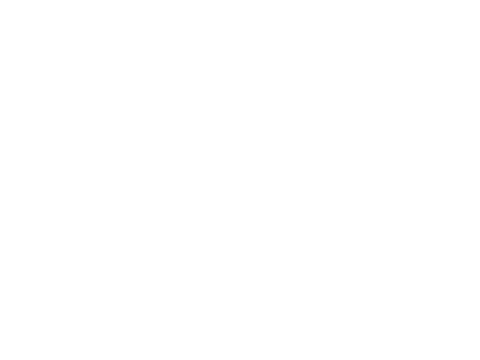

     animalid cohort                                         datasource  \
4692      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4692  20160310  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(448, 454)
N total response events:  442
N total outcome events:  442
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160310.mwk
N valid trials: 442
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y-30', 1.0), ('Blob_N2_y30', 0.8), ('Blob_N2_y60', 1.0), ('Blob_N2_y-15', 0.8888888888888888), ('Blob_N1_y-15', 0.6), ('Blob_N1_y0', 0.5714285714285714), ('Blob_N2_y45', 1.0), ('Blob_N1_y45', 0.7142857142857143), ('Blob_N2_y0', 0.8333333333333334), ('Blob_N2_y45', 1.0), ('Blob_N1_y0', 0.4166666666666667)

<IPython.core.display.Javascript object>


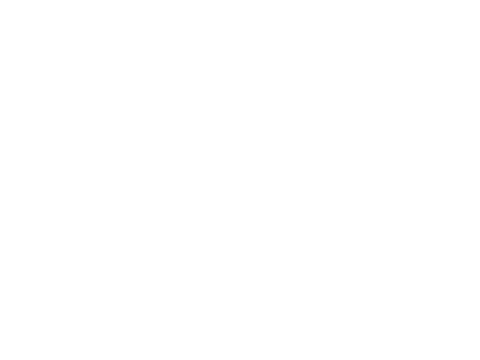

     animalid cohort                                         datasource  \
4693      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4693  20160311  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(728, 734)
N total response events:  724
N total outcome events:  724
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160311.mwk
N valid trials: 724
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y-30', 0.5), ('Blob_N2_y30', 0.5555555555555556), ('Blob_N2_y60', 0.6), ('Blob_N2_y-15', 0.38461538461538464), ('Blob_N1_y-15', 0.5333333333333333), ('Blob_N1_y0', 0.36363636363636365), ('Blob_N2_y45', 0.38461538461538464), ('Blob_N1_y45', 0.42857142857142855), ('Blob_N2_y0', 0.21428571428571427), ('Blob

<IPython.core.display.Javascript object>


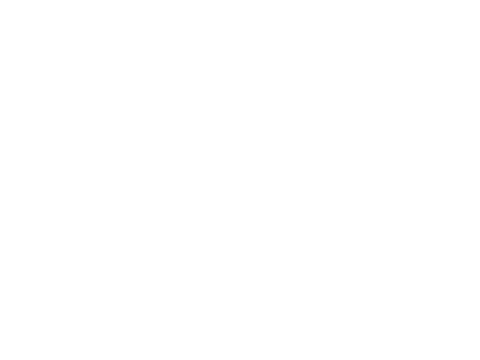

     animalid cohort                                         datasource  \
4694      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4694  20160314  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(596, 602)
N total response events:  591
N total outcome events:  591
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160314.mwk
N valid trials: 591
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y-30', 0.6111111111111112), ('Blob_N2_y30', 0.7142857142857143), ('Blob_N2_y60', 1.0), ('Blob_N2_y-15', 0.625), ('Blob_N1_y-15', 0.4166666666666667), ('Blob_N1_y0', 0.5833333333333334), ('Blob_N2_y45', 0.9333333333333333), ('Blob_N1_y45', 0.25), ('Blob_N2_y0', 0.6666666666666666), ('Blob_N2_y45', 0.9), (

<IPython.core.display.Javascript object>


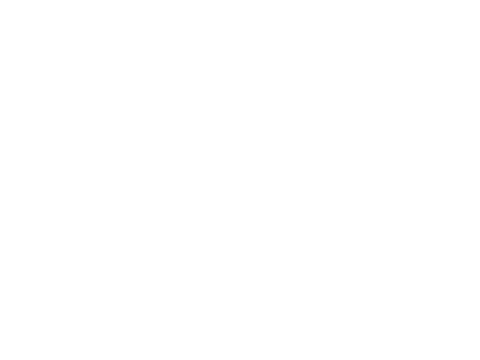

     animalid cohort                                         datasource  \
4695      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4695  20160315  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1005, 1011)
N total response events:  1001
N total outcome events:  1001
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160315.mwk
N valid trials: 1001
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y-30', 0.4117647058823529), ('Blob_N2_y30', 0.5789473684210527), ('Blob_N2_y60', 0.7391304347826086), ('Blob_N2_y-15', 0.5294117647058824), ('Blob_N1_y-15', 0.4375), ('Blob_N1_y0', 0.4444444444444444), ('Blob_N2_y45', 0.65), ('Blob_N1_y45', 0.5294117647058824), ('Blob_N2_y0', 0.6190476190476191), ('

<IPython.core.display.Javascript object>


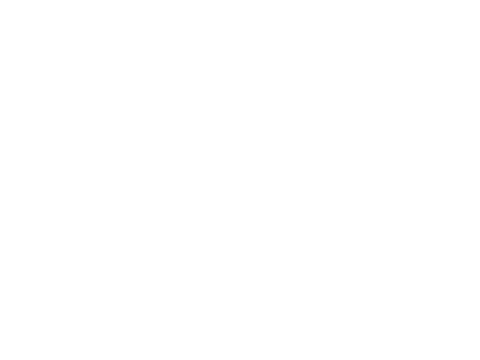

     animalid cohort                                         datasource  \
4696      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4696  20160316  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(879, 885)
N total response events:  871
N total outcome events:  871
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160316.mwk
N valid trials: 871
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y0', 0.7310344827586207), ('Blob_N1_y0', 0.7844036697247706)]


<IPython.core.display.Javascript object>


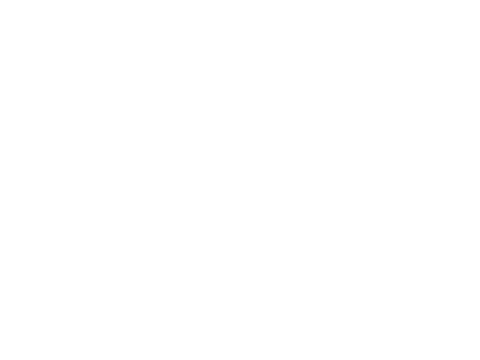

     animalid cohort                                         datasource  \
4697      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4697  20160317  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(904, 910)
N total response events:  896
N total outcome events:  896
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160317.mwk
N valid trials: 896
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.48), ('Blob_N2_y45', 0.6274509803921569), ('Blob_N1_y45', 0.6470588235294118), ('Blob_N1_y60', 0.62), ('Blob_N2_y15', 0.5918367346938775), ('Blob_N1_y-30', 0.6530612244897959), ('Blob_N1_y-15', 0.8), ('Blob_N1_y0', 0.8431372549019608), ('Blob_N2_y30', 0.6458333333333334), ('Blob_N1_y-45', 0.625),

<IPython.core.display.Javascript object>


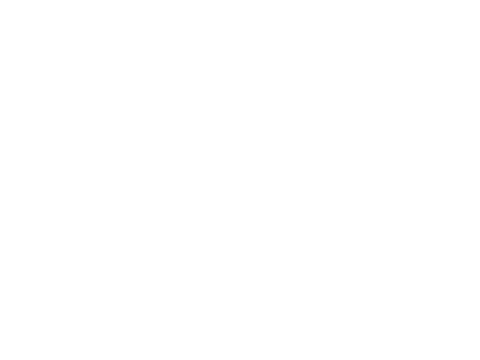

     animalid cohort                                         datasource  \
4698      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4698  20160318  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(969, 975)
N total response events:  965
N total outcome events:  965
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160318.mwk
N valid trials: 965
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.5849056603773585), ('Blob_N2_y45', 0.7222222222222222), ('Blob_N1_y45', 0.6071428571428571), ('Blob_N1_y60', 0.5), ('Blob_N2_y15', 0.7169811320754716), ('Blob_N1_y-30', 0.7407407407407407), ('Blob_N1_y-15', 0.7894736842105263), ('Blob_N1_y0', 0.9444444444444444), ('Blob_N2_y30', 0.648148148148148

<IPython.core.display.Javascript object>


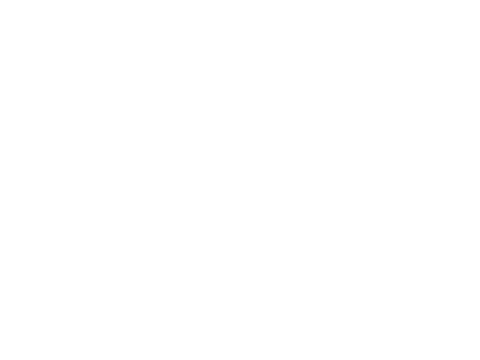

     animalid cohort                                         datasource  \
4699      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4699  20160328  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(457, 463)
N total response events:  452
N total outcome events:  452
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160328.mwk
N valid trials: 452
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.84), ('Blob_N2_y45', 0.8), ('Blob_N1_y45', 0.32), ('Blob_N1_y60', 0.32), ('Blob_N2_y15', 0.7916666666666666), ('Blob_N1_y-30', 0.3333333333333333), ('Blob_N1_y-15', 0.5185185185185185), ('Blob_N1_y0', 0.6923076923076923), ('Blob_N2_y30', 0.84), ('Blob_N1_y-45', 0.4230769230769231), ('Blob_N2_y-45

<IPython.core.display.Javascript object>


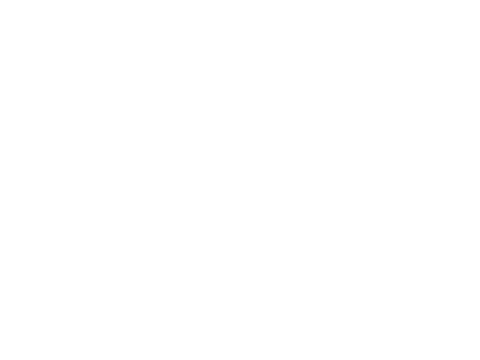

     animalid cohort                                         datasource  \
4700      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4700  20160329  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(877, 883)
N total response events:  869
N total outcome events:  869
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160329.mwk
N valid trials: 869
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.5833333333333334), ('Blob_N2_y45', 0.6530612244897959), ('Blob_N1_y45', 0.5102040816326531), ('Blob_N1_y60', 0.22448979591836735), ('Blob_N2_y15', 0.8541666666666666), ('Blob_N1_y-30', 0.6875), ('Blob_N1_y-15', 0.6458333333333334), ('Blob_N1_y0', 0.8163265306122449), ('Blob_N2_y30', 0.75510204081

<IPython.core.display.Javascript object>


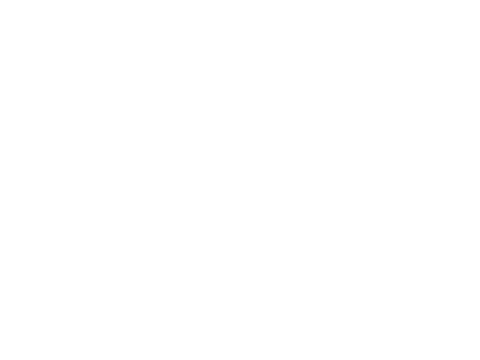

     animalid cohort                                         datasource  \
4701      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4701  20160330  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(980, 986)
N total response events:  977
N total outcome events:  977
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160330.mwk
N valid trials: 977
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7636363636363637), ('Blob_N2_y45', 0.7777777777777778), ('Blob_N1_y45', 0.5849056603773585), ('Blob_N1_y60', 0.3584905660377358), ('Blob_N2_y15', 0.8113207547169812), ('Blob_N1_y-30', 0.7592592592592593), ('Blob_N1_y-15', 0.8360655737704918), ('Blob_N1_y0', 0.7450980392156863), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


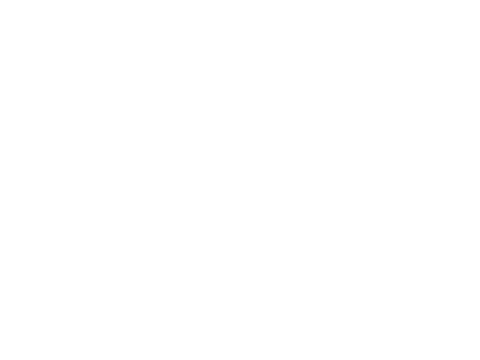

     animalid cohort                                         datasource  \
4702      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4702  20160331  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(810, 816)
N total response events:  804
N total outcome events:  804
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160331.mwk
N valid trials: 804
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8043478260869565), ('Blob_N2_y45', 0.8571428571428571), ('Blob_N1_y45', 0.5217391304347826), ('Blob_N1_y60', 0.3488372093023256), ('Blob_N2_y15', 0.7391304347826086), ('Blob_N1_y-30', 0.5813953488372093), ('Blob_N1_y-15', 0.8444444444444444), ('Blob_N1_y0', 0.8181818181818182), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


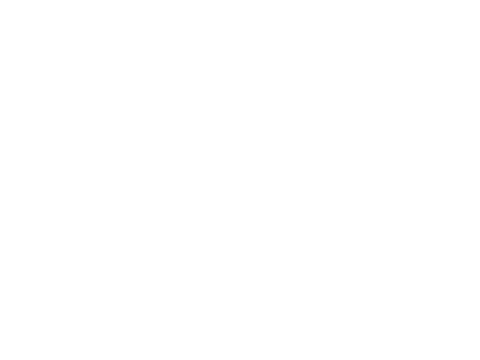

     animalid cohort                                         datasource  \
4703      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4703  20160404  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(462, 468)
N total response events:  453
N total outcome events:  453
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160404.mwk
N valid trials: 453
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8), ('Blob_N2_y45', 0.8333333333333334), ('Blob_N1_y45', 0.5833333333333334), ('Blob_N1_y60', 0.46153846153846156), ('Blob_N2_y15', 0.8), ('Blob_N1_y-30', 0.5833333333333334), ('Blob_N1_y-15', 0.6666666666666666), ('Blob_N1_y0', 0.6923076923076923), ('Blob_N2_y30', 0.88), ('Blob_N1_y-45', 0.34615

<IPython.core.display.Javascript object>


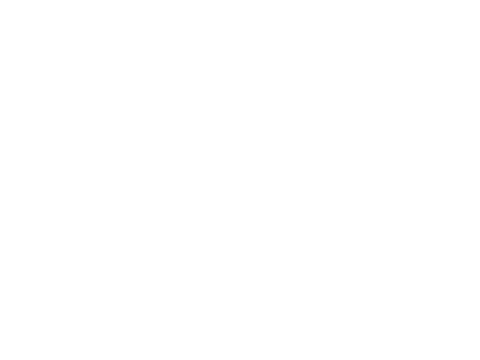

     animalid cohort                                         datasource  \
4704      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4704  20160408  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(432, 438)
N total response events:  428
N total outcome events:  428
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160408.mwk
N valid trials: 428
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.75), ('Blob_N2_y45', 0.7083333333333334), ('Blob_N1_y45', 0.4166666666666667), ('Blob_N1_y60', 0.4166666666666667), ('Blob_N2_y15', 0.7391304347826086), ('Blob_N1_y-30', 0.4782608695652174), ('Blob_N1_y-15', 0.7083333333333334), ('Blob_N1_y0', 0.9166666666666666), ('Blob_N2_y30', 0.79166666666666

<IPython.core.display.Javascript object>


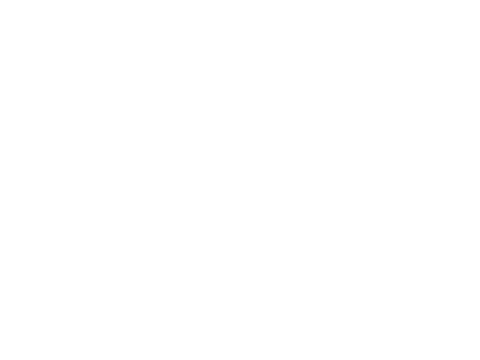

     animalid cohort                                         datasource  \
4705      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4705  20160603  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(343, 349)
N total response events:  333
N total outcome events:  333
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160603.mwk
N valid trials: 333
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.6111111111111112), ('Blob_N2_y45', 0.7777777777777778), ('Blob_N1_y45', 0.7222222222222222), ('Blob_N1_y60', 0.6842105263157895), ('Blob_N2_y15', 0.7222222222222222), ('Blob_N1_y-30', 0.6842105263157895), ('Blob_N1_y-15', 0.5789473684210527), ('Blob_N1_y0', 0.631578947368421), ('Blob_N2_y30', 0.7

<IPython.core.display.Javascript object>


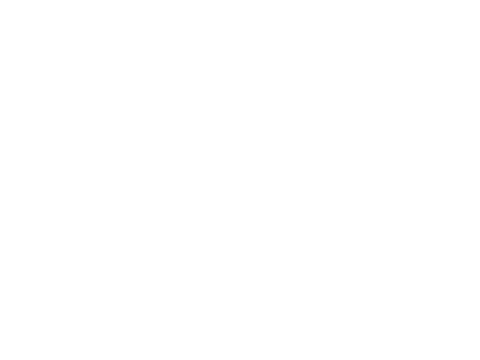

     animalid cohort                                         datasource  \
4706      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4706  20160908  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(497, 503)
N total response events:  491
N total outcome events:  491
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160908.mwk
N valid trials: 491
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7931034482758621), ('Blob_N2_y45', 0.8076923076923077), ('Blob_N1_y45', 0.5), ('Blob_N1_y60', 0.6538461538461539), ('Blob_N2_y15', 0.8076923076923077), ('Blob_N1_y-30', 0.4642857142857143), ('Blob_N1_y-15', 0.4444444444444444), ('Blob_N1_y0', 0.4642857142857143), ('Blob_N2_y30', 0.785714285714285

<IPython.core.display.Javascript object>


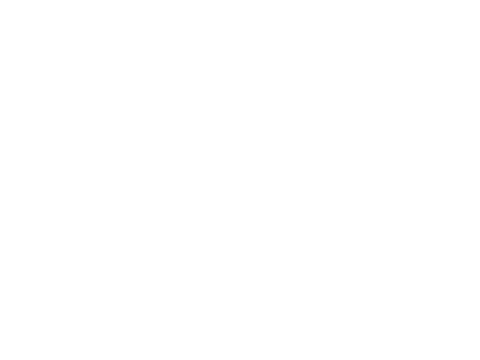

     animalid cohort                                         datasource  \
4707      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4707  20160909  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(739, 745)
N total response events:  724
N total outcome events:  724
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160909.mwk
N valid trials: 724
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.76775956284153), ('Blob_1_0', 0.6955307262569832)]


<IPython.core.display.Javascript object>


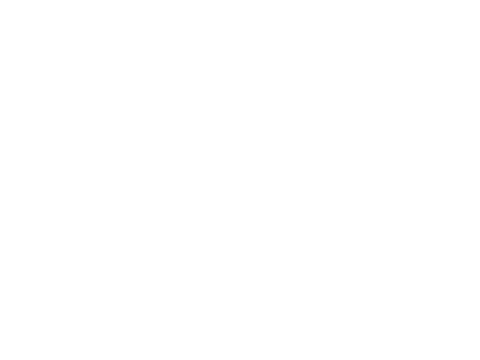

     animalid cohort                                         datasource  \
4708      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4708  20160913  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(437, 441)
N total response events:  0
N total outcome events:  0
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160913.mwk
N valid trials: 0
(437, 441)
N total response events:  0
N total outcome events:  0
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160913.mwk
N valid trials: 0
(437, 441)
N total response events:  428
N total outcome events:  428
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160913.mwk
N valid trials: 428
... Getting session summary ...
... Getti

<IPython.core.display.Javascript object>


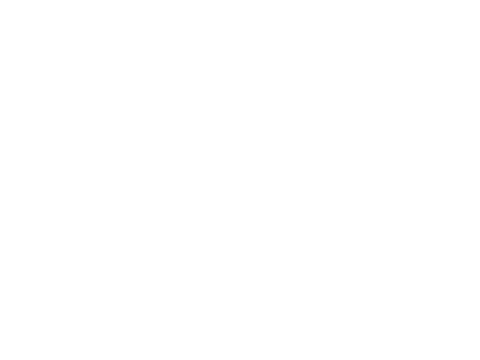

     animalid cohort                                         datasource  \
4709      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4710      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4709  20160914  
4710  20160914  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(318, 321)
N total response events:  313
N total outcome events:  313
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160914a.mwk
N valid trials: 313
***** Parsing trials *****
(256, 259)
N total response events:  250
N total outcome events:  250
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160914b.mwk
N valid trials: 250
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by

<IPython.core.display.Javascript object>


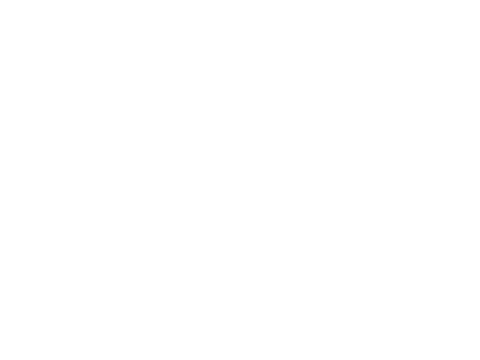

     animalid cohort                                         datasource  \
4709      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4710      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4709  20160914  
4710  20160914  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y15', 0.6666666666666666), ('Blob_N2_y45', 0.1111111111111111), ('Blob_2_0', 0.7073170731707317), ('Blob_N1_y45', 0.4444444444444444), ('Blob_N1_y60', 0.625), ('Blob_N2_y60', 0.0), ('Blob_1_0', 0.6510067114093959), ('Blob_N1_y-30', 0.1111111111111111), ('Blob_N1_y-15', 0.6666666666666666), ('Blob_N1_y0', 0.3148148148148148), ('Blob_N2_y30', 0.4444444444444444), ('Blob_N1_y-45', 0.5555555555555556), ('Blob_N2_y-45', 0.1111111111111111), ('Blob_N2_y0', 0.8679245283018868), ('Blob_N1_y30', 0.4444444444444444), (

<IPython.core.display.Javascript object>


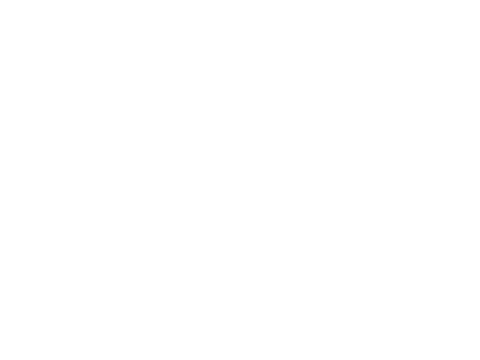

     animalid cohort                                         datasource  \
4711      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4712      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4711  20160915  
4712  20160915  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(318, 321)
N total response events:  313
N total outcome events:  313
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160915a.mwk
N valid trials: 313
***** Parsing trials *****
(256, 259)
N total response events:  250
N total outcome events:  250
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160915b.mwk
N valid trials: 250
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by

<IPython.core.display.Javascript object>


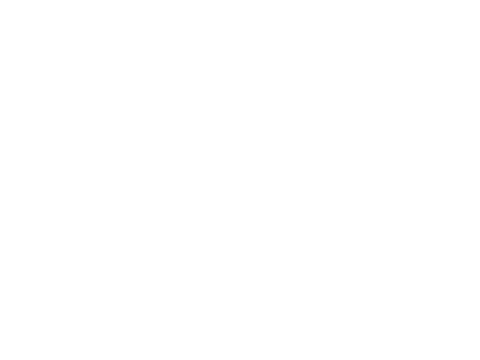

     animalid cohort                                         datasource  \
4711      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4712      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4711  20160915  
4712  20160915  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y15', 0.6666666666666666), ('Blob_N2_y45', 0.1111111111111111), ('Blob_2_0', 0.7073170731707317), ('Blob_N1_y45', 0.4444444444444444), ('Blob_N1_y60', 0.625), ('Blob_N2_y60', 0.0), ('Blob_1_0', 0.6510067114093959), ('Blob_N1_y-30', 0.1111111111111111), ('Blob_N1_y-15', 0.6666666666666666), ('Blob_N1_y0', 0.3148148148148148), ('Blob_N2_y30', 0.4444444444444444), ('Blob_N1_y-45', 0.5555555555555556), ('Blob_N2_y-45', 0.1111111111111111), ('Blob_N2_y0', 0.8679245283018868), ('Blob_N1_y30', 0.4444444444444444), (

<IPython.core.display.Javascript object>


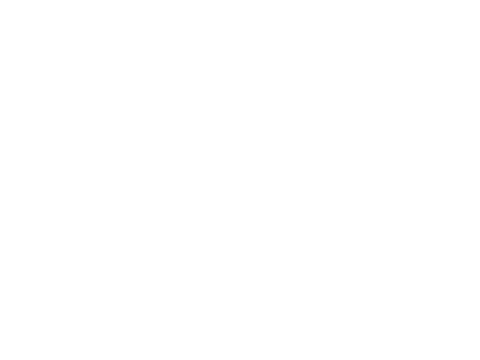

     animalid cohort                                         datasource  \
4713      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4713  20160919  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1058, 1058)
N total response events:  1051
N total outcome events:  1051
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160919.mwk
N valid trials: 1051
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8275862068965517), ('Blob_N2_y45', 0.9), ('Blob_N1_y45', 0.576271186440678), ('Blob_N1_y60', 0.5344827586206896), ('Blob_N2_y15', 0.9642857142857143), ('Blob_N1_y-30', 0.6551724137931034), ('Blob_N1_y-15', 0.5172413793103449), ('Blob_N1_y0', 0.3103448275862069), ('Blob_N2_y30', 0.93220338983

<IPython.core.display.Javascript object>


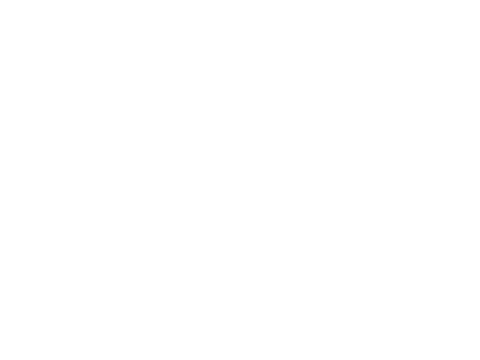

     animalid cohort                                         datasource  \
4714      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4715      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4714  20160920  
4715  20160920  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(426, 426)
N total response events:  421
N total outcome events:  421
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160920a.mwk
N valid trials: 421
***** Parsing trials *****
(302, 308)
N total response events:  302
N total outcome events:  302
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160920b.mwk
N valid trials: 302
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by

<IPython.core.display.Javascript object>


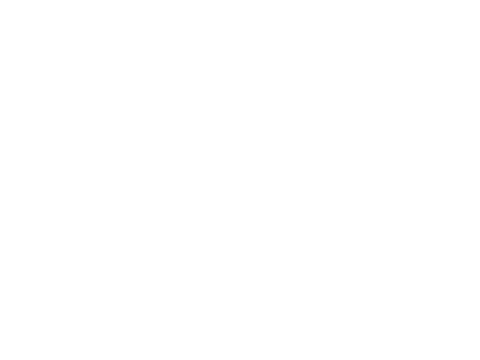

     animalid cohort                                         datasource  \
4714      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4715      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4714  20160920  
4715  20160920  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y15', 0.4), ('Blob_N2_y45', 0.36363636363636365), ('Blob_2_0', 0.39712918660287083), ('Blob_N1_y45', 0.18181818181818182), ('Blob_N1_y60', 0.09090909090909091), ('Blob_N2_y60', 0.36363636363636365), ('Blob_1_0', 0.18867924528301888), ('Blob_N1_y-30', 0.2727272727272727), ('Blob_N1_y-15', 0.36363636363636365), ('Blob_N1_y0', 0.25), ('Blob_N2_y30', 0.6363636363636364), ('Blob_N1_y-45', 0.18181818181818182), ('Blob_N2_y-45', 0.6363636363636364), ('Blob_N2_y0', 0.6153846153846154), ('Blob_N1_y30', 0.1), ('Blob_N2

<IPython.core.display.Javascript object>


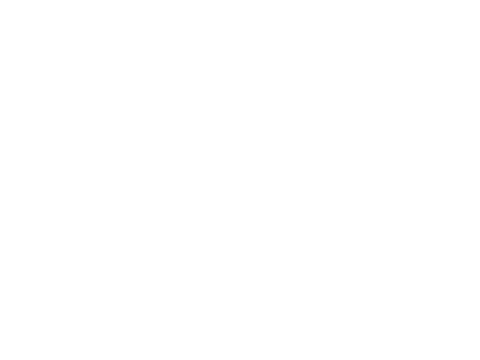

     animalid cohort                                         datasource  \
4716      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4717      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4716  20160921  
4717  20160921  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(528, 528)
N total response events:  521
N total outcome events:  521
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160921a.mwk
N valid trials: 521
***** Parsing trials *****
(393, 393)
N total response events:  387
N total outcome events:  387
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160921b.mwk
N valid trials: 387
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by

<IPython.core.display.Javascript object>


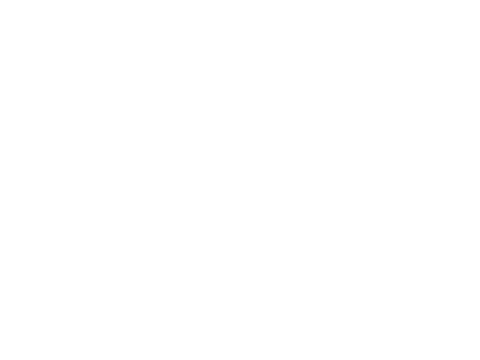

     animalid cohort                                         datasource  \
4716      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4717      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4716  20160921  
4717  20160921  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y15', 0.8571428571428571), ('Blob_N2_y45', 0.9285714285714286), ('Blob_2_0', 0.7255639097744361), ('Blob_N1_y45', 0.07142857142857142), ('Blob_N1_y60', 0.0), ('Blob_N2_y60', 0.8571428571428571), ('Blob_1_0', 0.050980392156862744), ('Blob_N1_y-30', 0.0), ('Blob_N1_y-15', 0.0), ('Blob_N1_y0', 0.0), ('Blob_N2_y30', 0.8571428571428571), ('Blob_N1_y-45', 0.0), ('Blob_N2_y-45', 0.9285714285714286), ('Blob_N2_y0', 0.9879518072289156), ('Blob_N1_y30', 0.0), ('Blob_N2_y-60', 0.7142857142857143), ('Blob_N1_y15', 0.0), 

<IPython.core.display.Javascript object>


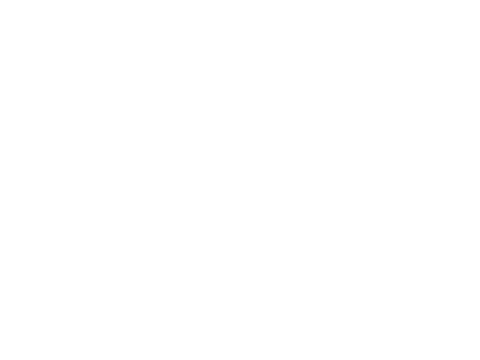

     animalid cohort                                         datasource  \
4718      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4719      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4718  20160922  
4719  20160922  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(444, 444)
N total response events:  441
N total outcome events:  441
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160922a.mwk
N valid trials: 441
***** Parsing trials *****
(183, 183)
N total response events:  183
N total outcome events:  183
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160922b.mwk
N valid trials: 183
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by

<IPython.core.display.Javascript object>


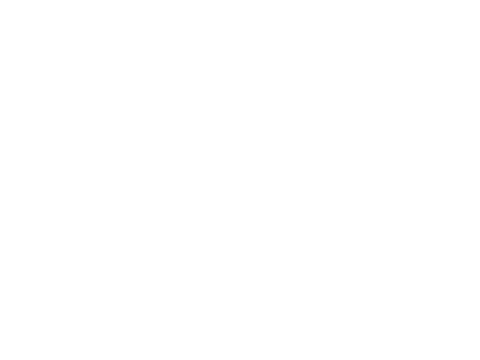

     animalid cohort                                         datasource  \
4718      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4719      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4718  20160922  
4719  20160922  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y15', 0.7142857142857143), ('Blob_N2_y45', 0.5714285714285714), ('Blob_2_0', 0.7713004484304933), ('Blob_N1_y45', 1.0), ('Blob_N1_y60', 0.5), ('Blob_N2_y60', 1.0), ('Blob_1_0', 0.6605504587155964), ('Blob_N1_y-30', 0.8571428571428571), ('Blob_N1_y-15', 0.8571428571428571), ('Blob_N1_y0', 0.6578947368421053), ('Blob_N2_y30', 0.6666666666666666), ('Blob_N1_y-45', 0.8571428571428571), ('Blob_N2_y-45', 0.5), ('Blob_N2_y0', 0.717948717948718), ('Blob_N1_y30', 0.5714285714285714), ('Blob_N2_y-60', 0.833333333333333

<IPython.core.display.Javascript object>


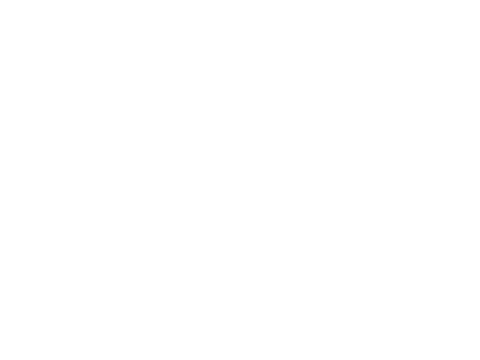

     animalid cohort                                         datasource  \
4720      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4720  20160926  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1576, 1576)
N total response events:  1572
N total outcome events:  1572
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160926.mwk
N valid trials: 1572
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.46050670640834573), ('Blob_1_0', 0.38401775804661487)]


<IPython.core.display.Javascript object>


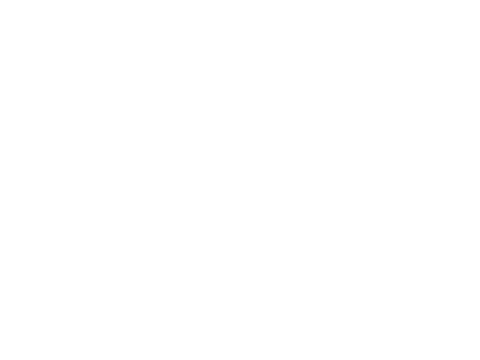

     animalid cohort                                         datasource  \
4721      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4721  20160927  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1261, 1261)
N total response events:  1254
N total outcome events:  1254
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160927.mwk
N valid trials: 1254
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.5575959933222037), ('Blob_1_0', 0.5038167938931297)]


<IPython.core.display.Javascript object>


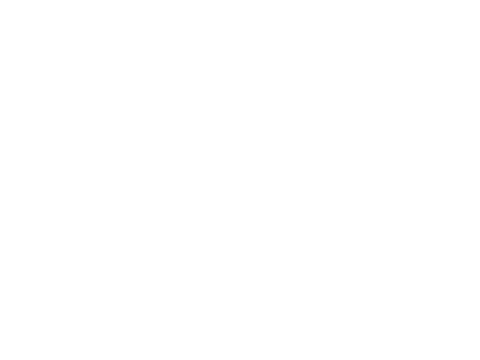

     animalid cohort                                         datasource  \
4722      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4722  20160928  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1123, 1123)
N total response events:  1116
N total outcome events:  1116
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160928.mwk
N valid trials: 1116
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.5918727915194346), ('Blob_1_0', 0.6036363636363636)]


<IPython.core.display.Javascript object>


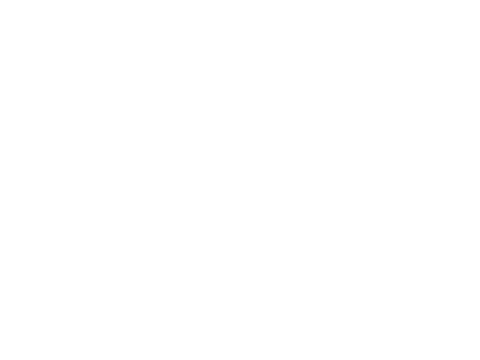

     animalid cohort                                         datasource  \
4723      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4723  20160929  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(808, 808)
N total response events:  804
N total outcome events:  804
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160929.mwk
N valid trials: 804
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.6395939086294417), ('Blob_1_0', 0.6804878048780488)]


<IPython.core.display.Javascript object>


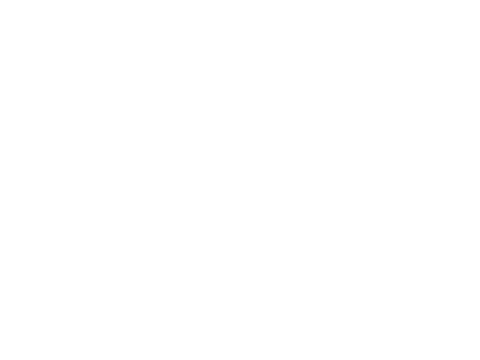

     animalid cohort                                         datasource  \
4724      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4724  20160930  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(890, 890)
N total response events:  880
N total outcome events:  880
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_160930.mwk
N valid trials: 880
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.7325581395348837), ('Blob_1_0', 0.7155555555555555)]


<IPython.core.display.Javascript object>


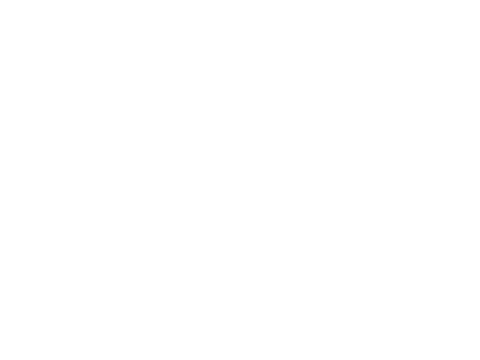

     animalid cohort                                         datasource  \
4725      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4725  20161001  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(634, 634)
N total response events:  632
N total outcome events:  632
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161001.mwk
N valid trials: 632
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.6635802469135802), ('Blob_1_0', 0.6818181818181818)]


<IPython.core.display.Javascript object>


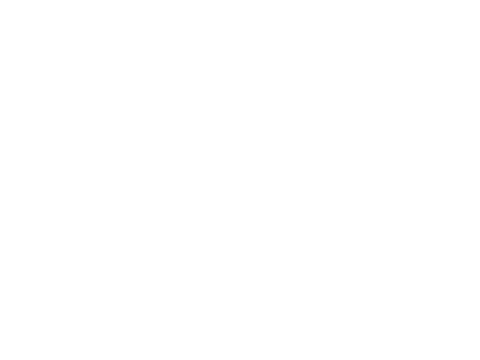

     animalid cohort                                         datasource  \
4726      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4726  20161005  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1052, 1052)
N total response events:  1047
N total outcome events:  1047
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161005.mwk
N valid trials: 1047
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.8391752577319588), ('Blob_1_0', 0.6814946619217082)]


<IPython.core.display.Javascript object>


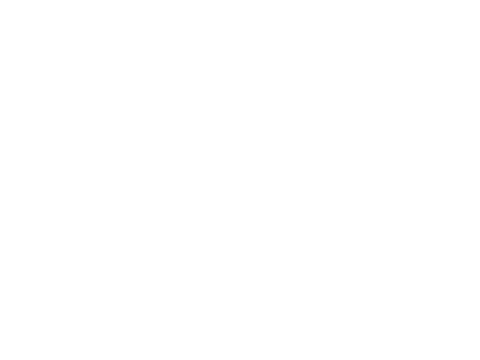

     animalid cohort                                         datasource  \
4727      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4727  20161006  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(703, 703)
N total response events:  700
N total outcome events:  700
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161006.mwk
N valid trials: 700
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.5238095238095238), ('Blob_1_0', 0.565597667638484)]


<IPython.core.display.Javascript object>


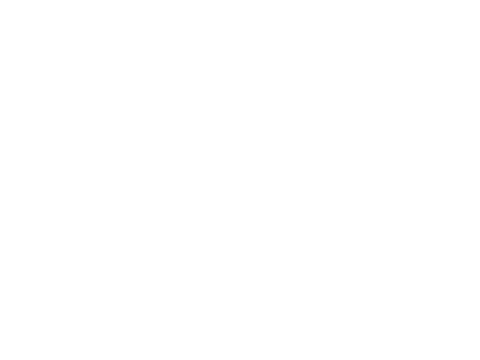

     animalid cohort                                         datasource  \
4728      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4729      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4730      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4731      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4728  20161007  
4729  20161007  
4730  20161007  
4731  20161007  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(561, 561)
N total response events:  554
N total outcome events:  554
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161007a.mwk
N valid trials: 554
***** Parsing trials *****
(533, 533)
N total response events:  530
N total outcome events:  530
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data

<IPython.core.display.Javascript object>


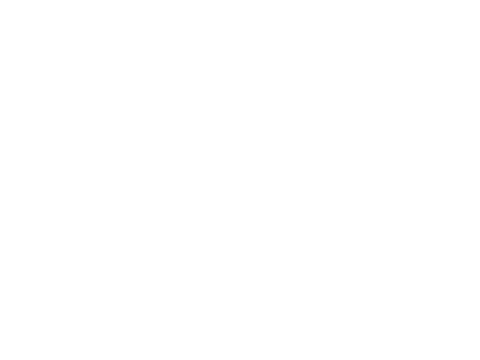

     animalid cohort                                         datasource  \
4728      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4729      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4730      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4731      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4728  20161007  
4729  20161007  
4730  20161007  
4731  20161007  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.6553755522827688), ('Blob_1_0', 0.7765273311897106)]


<IPython.core.display.Javascript object>


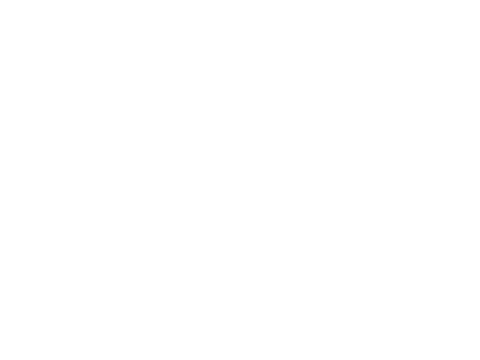

     animalid cohort                                         datasource  \
4728      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4729      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4730      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4731      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4728  20161007  
4729  20161007  
4730  20161007  
4731  20161007  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.6553755522827688), ('Blob_1_0', 0.7765273311897106)]


<IPython.core.display.Javascript object>


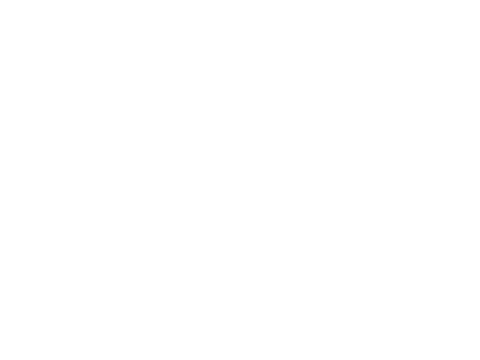

     animalid cohort                                         datasource  \
4728      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4729      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4730      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4731      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4728  20161007  
4729  20161007  
4730  20161007  
4731  20161007  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.6553755522827688), ('Blob_1_0', 0.7765273311897106)]


<IPython.core.display.Javascript object>


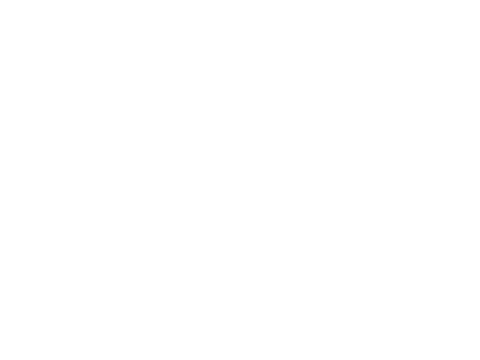

     animalid cohort                                         datasource  \
4732      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4733      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4734      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4735      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4732  20161012  
4733  20161012  
4734  20161012  
4735  20161012  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(339, 339)
N total response events:  339
N total outcome events:  339
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161012a.mwk
N valid trials: 339
***** Parsing trials *****
(361, 361)
N total response events:  358
N total outcome events:  358
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data

<IPython.core.display.Javascript object>


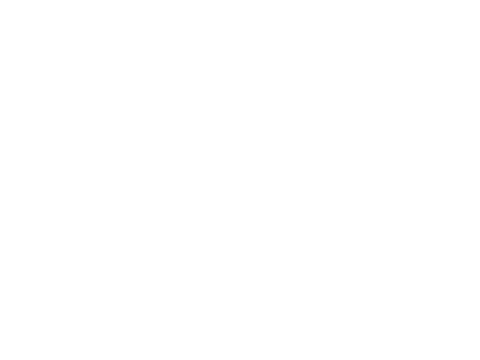

     animalid cohort                                         datasource  \
4732      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4733      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4734      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4735      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4732  20161012  
4733  20161012  
4734  20161012  
4735  20161012  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y15', 0.6842105263157895), ('Blob_N2_y45', 0.6842105263157895), ('Blob_2_0', 0.7269938650306749), ('Blob_N1_y45', 0.7894736842105263), ('Blob_N1_y60', 0.5555555555555556), ('Blob_N2_y60', 0.5), ('Blob_1_0', 0.6495956873315364), ('Blob_N1_y-30', 0.75), ('Blob_N1_y-15', 0.631578947368421), ('Blob_N1_y0', 0.46551724137931033), ('Bl

<IPython.core.display.Javascript object>


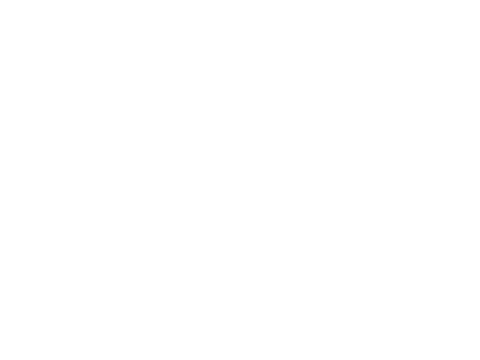

     animalid cohort                                         datasource  \
4732      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4733      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4734      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4735      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4732  20161012  
4733  20161012  
4734  20161012  
4735  20161012  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y15', 0.6842105263157895), ('Blob_N2_y45', 0.6842105263157895), ('Blob_2_0', 0.7269938650306749), ('Blob_N1_y45', 0.7894736842105263), ('Blob_N1_y60', 0.5555555555555556), ('Blob_N2_y60', 0.5), ('Blob_1_0', 0.6495956873315364), ('Blob_N1_y-30', 0.75), ('Blob_N1_y-15', 0.631578947368421), ('Blob_N1_y0', 0.46551724137931033), ('Bl

<IPython.core.display.Javascript object>


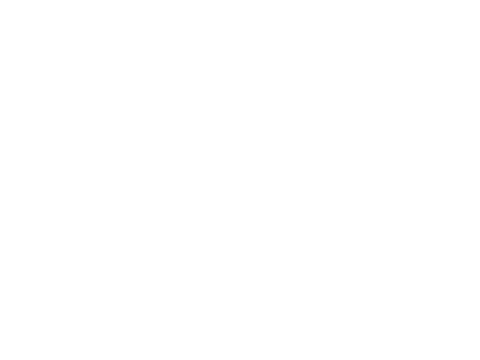

     animalid cohort                                         datasource  \
4732      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4733      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4734      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4735      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4732  20161012  
4733  20161012  
4734  20161012  
4735  20161012  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y15', 0.6842105263157895), ('Blob_N2_y45', 0.6842105263157895), ('Blob_2_0', 0.7269938650306749), ('Blob_N1_y45', 0.7894736842105263), ('Blob_N1_y60', 0.5555555555555556), ('Blob_N2_y60', 0.5), ('Blob_1_0', 0.6495956873315364), ('Blob_N1_y-30', 0.75), ('Blob_N1_y-15', 0.631578947368421), ('Blob_N1_y0', 0.46551724137931033), ('Bl

<IPython.core.display.Javascript object>


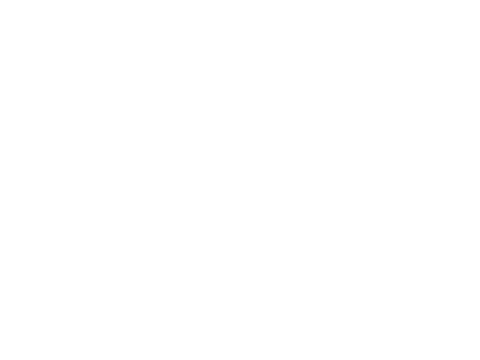

     animalid cohort                                         datasource  \
4736      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4737      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4736  20161013  
4737  20161013  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(693, 693)
N total response events:  690
N total outcome events:  690
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161013a.mwk
N valid trials: 690
***** Parsing trials *****
More than 1 value found for flag: FlagAutomaticBiasSuppression
More than 1 value found for flag: FlagStaircaseHorizSeparation
More than 1 value found for flag: FlagStaircaseProbFreeRew
More than 1 value found for flag: FlagEnrichSomeStaircases
More than 1 value found for flag: FlagShowOnlyTrainedAxes
More than 1 value found for

<IPython.core.display.Javascript object>


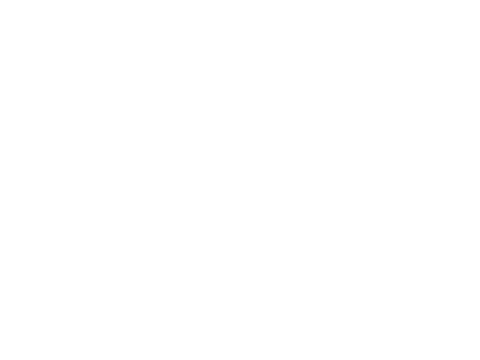

     animalid cohort                                         datasource  \
4736      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4737      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4736  20161013  
4737  20161013  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y15', 0.5862068965517241), ('Blob_N2_y45', 0.3793103448275862), ('Blob_N1_y45', 0.7777777777777778), ('Blob_N1_y60', 0.6666666666666666), ('Blob_N2_y60', 0.4827586206896552), ('Blob_N1_y-30', 0.8275862068965517), ('Blob_N1_y-15', 0.7241379310344828), ('Blob_N1_y0', 0.5502958579881657), ('Blob_N2_y30', 0.6071428571428571), ('Blob_N1_y-45', 0.7586206896551724), ('Blob_N2_y-45', 0.5172413793103449), ('Blob_N2_y0', 0.6449704142011834), ('Blob_N1_y30', 0.8275862068965517), ('Blob_N2_y-60', 0.41379310344827586), ('

<IPython.core.display.Javascript object>


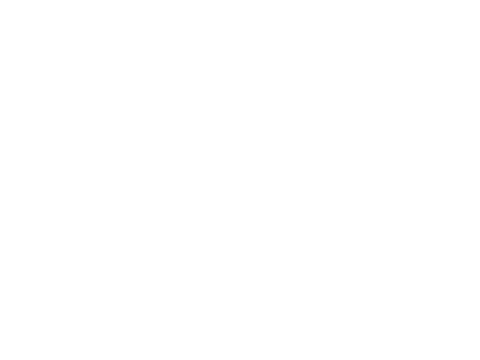

     animalid cohort                                         datasource  \
4738      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4738  20161014  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1356, 1356)
N total response events:  1336
N total outcome events:  1336
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161014.mwk
N valid trials: 1336
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.4166666666666667), ('Blob_N2_y45', 0.4657534246575342), ('Blob_N1_y45', 0.4864864864864865), ('Blob_N1_y60', 0.44594594594594594), ('Blob_N2_y15', 0.6756756756756757), ('Blob_N1_y-30', 0.6486486486486487), ('Blob_N1_y-15', 0.6), ('Blob_N1_y0', 0.5833333333333334), ('Blob_N2_y30', 0.472222222

<IPython.core.display.Javascript object>


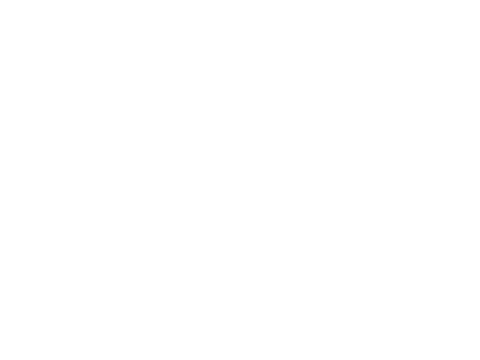

     animalid cohort                                         datasource  \
4739      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4739  20161017  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1115, 1115)
N total response events:  1110
N total outcome events:  1110
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161017.mwk
N valid trials: 1110
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.5409836065573771), ('Blob_N2_y45', 0.38333333333333336), ('Blob_N1_y45', 0.6065573770491803), ('Blob_N1_y60', 0.7), ('Blob_N2_y15', 0.6825396825396826), ('Blob_N1_y-30', 0.6129032258064516), ('Blob_N1_y-15', 0.7377049180327869), ('Blob_N1_y0', 0.5645161290322581), ('Blob_N2_y30', 0.6), ('Blo

<IPython.core.display.Javascript object>


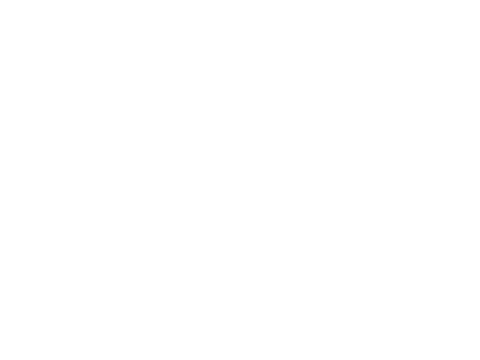

     animalid cohort                                         datasource  \
4740      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4740  20161018  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1121, 1121)
N total response events:  1113
N total outcome events:  1113
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161018.mwk
N valid trials: 1113
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.7717231222385862), ('Blob_1_0', 0.423963133640553)]


<IPython.core.display.Javascript object>


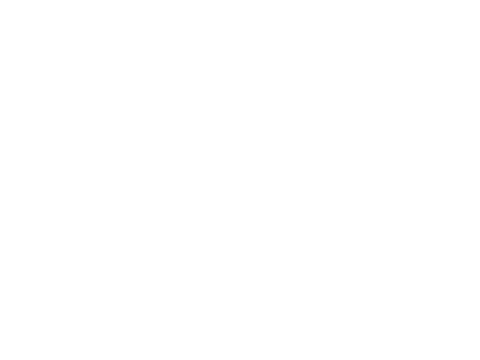

     animalid cohort                                         datasource  \
4741      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4741  20161020  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(985, 991)
N total response events:  969
N total outcome events:  969
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161020.mwk
N valid trials: 969
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.8081761006289309), ('Blob_1_0', 0.33933933933933935)]


<IPython.core.display.Javascript object>


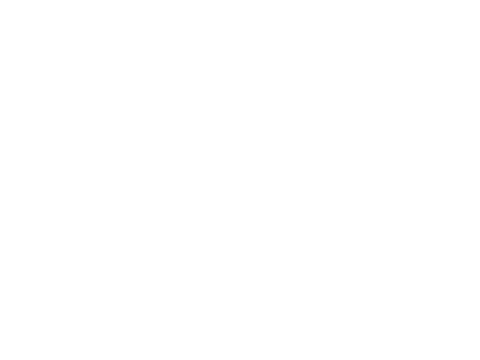

     animalid cohort                                         datasource  \
4742      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4742  20161025  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1082, 1088)
N total response events:  1072
N total outcome events:  1072
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161025.mwk
N valid trials: 1072
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.8), ('Blob_1_0', 0.41262135922330095)]


<IPython.core.display.Javascript object>


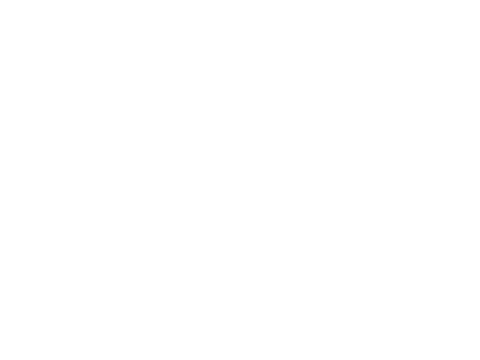

     animalid cohort                                         datasource  \
4743      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4743  20161026  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1168, 1174)
N total response events:  1158
N total outcome events:  1158
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161026.mwk
N valid trials: 1158
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.4747252747252747), ('Blob_1_0', 0.8036984352773826)]


<IPython.core.display.Javascript object>


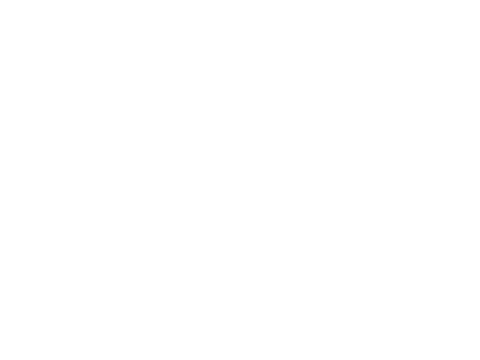

     animalid cohort                                         datasource  \
4744      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4745      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4746      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4747      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4744  20161027  
4745  20161027  
4746  20161027  
4747  20161027  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(551, 557)
N total response events:  540
N total outcome events:  540
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161027a.mwk
N valid trials: 540
***** Parsing trials *****
(389, 392)
N total response events:  378
N total outcome events:  378
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data

<IPython.core.display.Javascript object>


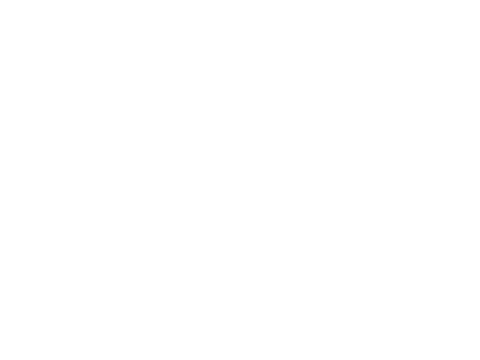

     animalid cohort                                         datasource  \
4744      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4745      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4746      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4747      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4744  20161027  
4745  20161027  
4746  20161027  
4747  20161027  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.8052851182197497), ('Blob_1_0', 0.6371841155234657)]


<IPython.core.display.Javascript object>


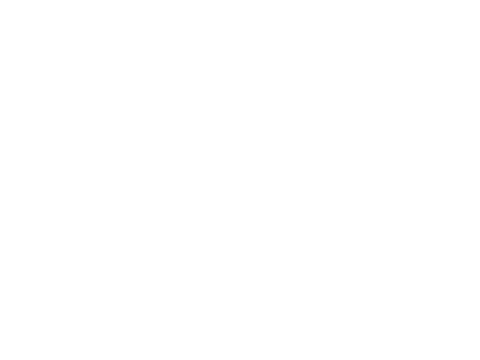

     animalid cohort                                         datasource  \
4744      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4745      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4746      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4747      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4744  20161027  
4745  20161027  
4746  20161027  
4747  20161027  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.8052851182197497), ('Blob_1_0', 0.6371841155234657)]


<IPython.core.display.Javascript object>


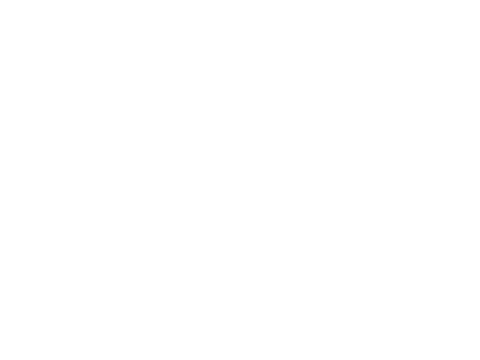

     animalid cohort                                         datasource  \
4744      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4745      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4746      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4747      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4744  20161027  
4745  20161027  
4746  20161027  
4747  20161027  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.8052851182197497), ('Blob_1_0', 0.6371841155234657)]


<IPython.core.display.Javascript object>


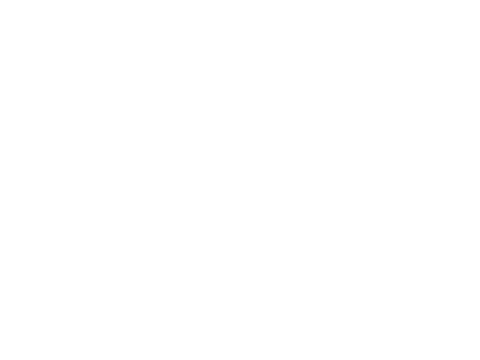

     animalid cohort                                         datasource  \
4748      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4748  20161028  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1081, 1087)
N total response events:  1062
N total outcome events:  1062
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161028a.mwk
N valid trials: 1062
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_2_0', 0.6810699588477366), ('Blob_1_0', 0.5798611111111112)]


<IPython.core.display.Javascript object>


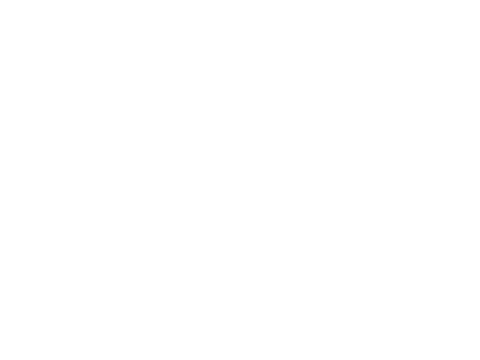

     animalid cohort                                         datasource  \
4749      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4749  20170116  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(935, 941)
N total response events:  929
N total outcome events:  929
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_170116.mwk
N valid trials: 929
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.5757575757575758), ('Blob_N2_y45', 0.7647058823529411), ('Blob_N1_y45', 0.5588235294117647), ('Blob_N1_y60', 0.5588235294117647), ('Blob_N2_y15', 0.6666666666666666), ('Blob_N1_y-30', 0.48484848484848486), ('Blob_N1_y-15', 0.5454545454545454), ('Blob_N1_y0', 0.6231155778894473), ('Blob_N2_y30', 0

<IPython.core.display.Javascript object>


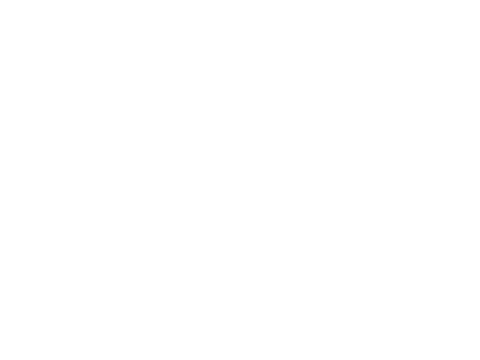

     animalid cohort                                         datasource  \
4750      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4750  20170117  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(810, 816)
N total response events:  802
N total outcome events:  802
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_170117.mwk
N valid trials: 802
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.4642857142857143), ('Blob_N2_y45', 0.5172413793103449), ('Blob_N1_y45', 0.6551724137931034), ('Blob_N1_y60', 0.6896551724137931), ('Blob_N2_y15', 0.6071428571428571), ('Blob_N1_y-30', 0.6785714285714286), ('Blob_N1_y-15', 0.6896551724137931), ('Blob_N1_y0', 0.6569767441860465), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


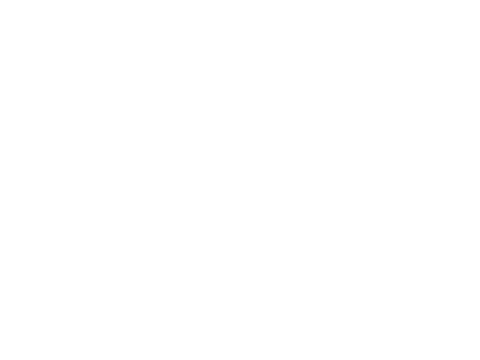

     animalid cohort                                         datasource  \
4751      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4751  20170118  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1325, 1331)
N total response events:  1313
N total outcome events:  1313
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_170118.mwk
N valid trials: 1313
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.723404255319149), ('Blob_N2_y45', 0.7446808510638298), ('Blob_N1_y45', 0.7446808510638298), ('Blob_N1_y60', 0.723404255319149), ('Blob_N2_y15', 0.723404255319149), ('Blob_N1_y-30', 0.6808510638297872), ('Blob_N1_y-15', 0.7872340425531915), ('Blob_N1_y0', 0.6219081272084805), ('Blob_N2_y30', 

<IPython.core.display.Javascript object>


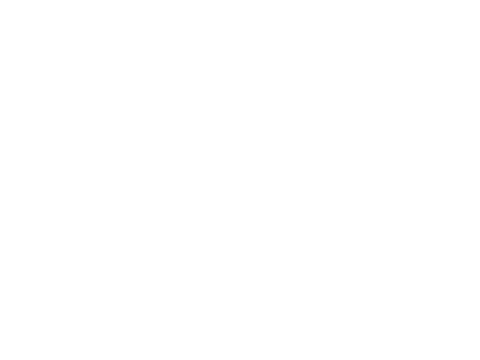

     animalid cohort                                         datasource  \
4752      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4752  20170119  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1097, 1103)
N total response events:  1085
N total outcome events:  1085
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_170119.mwk
N valid trials: 1085
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7692307692307693), ('Blob_N2_y45', 0.8717948717948718), ('Blob_N1_y45', 0.8205128205128205), ('Blob_N1_y60', 0.9230769230769231), ('Blob_N2_y15', 0.7948717948717948), ('Blob_N1_y-30', 0.7692307692307693), ('Blob_N1_y-15', 0.717948717948718), ('Blob_N1_y0', 0.6196581196581197), ('Blob_N2_y30'

<IPython.core.display.Javascript object>


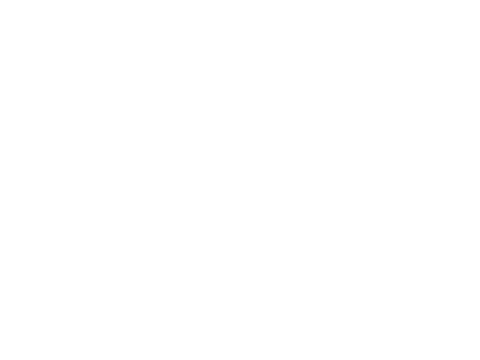

     animalid cohort                                         datasource  \
4753      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4753  20170120  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(931, 937)
N total response events:  921
N total outcome events:  921
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_170120.mwk
N valid trials: 921
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.8181818181818182), ('Blob_N2_y45', 0.7272727272727273), ('Blob_N1_y45', 0.9090909090909091), ('Blob_N1_y60', 0.9090909090909091), ('Blob_N2_y15', 0.8823529411764706), ('Blob_N1_y-30', 0.8484848484848485), ('Blob_N1_y-15', 0.7878787878787878), ('Blob_N1_y0', 0.6395939086294417), ('Blob_N2_y30', 0.

<IPython.core.display.Javascript object>


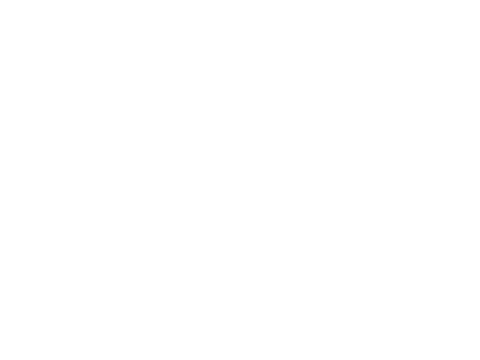

     animalid cohort                                         datasource  \
4754      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4754  20170123  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1369, 1375)
N total response events:  1358
N total outcome events:  1358
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_170123.mwk
N valid trials: 1358
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7142857142857143), ('Blob_N2_y45', 0.6875), ('Blob_N1_y45', 0.7708333333333334), ('Blob_N1_y60', 0.9183673469387755), ('Blob_N2_y15', 0.8979591836734694), ('Blob_N1_y-30', 0.7959183673469388), ('Blob_N1_y-15', 0.6326530612244898), ('Blob_N1_y0', 0.5793103448275863), ('Blob_N2_y30', 0.7551020

<IPython.core.display.Javascript object>


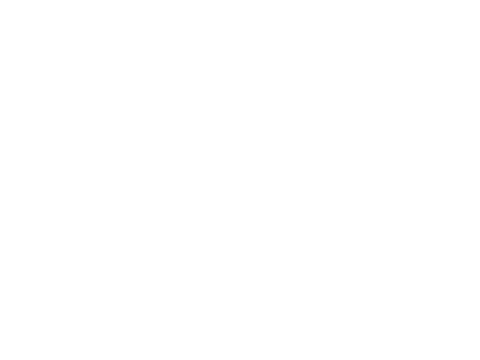

     animalid cohort                                         datasource  \
4755      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4755  20170124  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(1101, 1107)
N total response events:  1090
N total outcome events:  1090
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_170124.mwk
N valid trials: 1090
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.7948717948717948), ('Blob_N2_y45', 0.8157894736842105), ('Blob_N1_y45', 0.8974358974358975), ('Blob_N1_y60', 0.9487179487179487), ('Blob_N2_y15', 0.9230769230769231), ('Blob_N1_y-30', 0.7948717948717948), ('Blob_N1_y-15', 0.7948717948717948), ('Blob_N1_y0', 0.6239316239316239), ('Blob_N2_y30

<IPython.core.display.Javascript object>


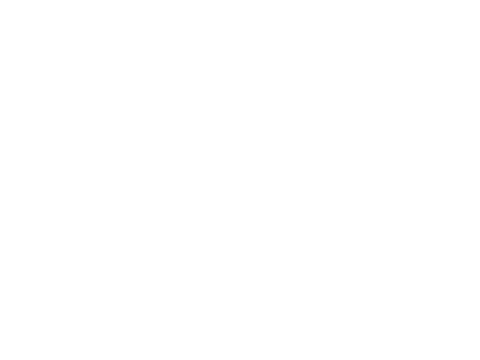

     animalid cohort                                         datasource  \
4756      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4757      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4756  20170125  
4757  20170125  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(19, 25)
N total response events:  11
N total outcome events:  11
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_170125.mwk
N valid trials: 11
***** Parsing trials *****
(317, 323)
N total response events:  308
N total outcome events:  308
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_170125b.mwk
N valid trials: 308
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by trans

<IPython.core.display.Javascript object>


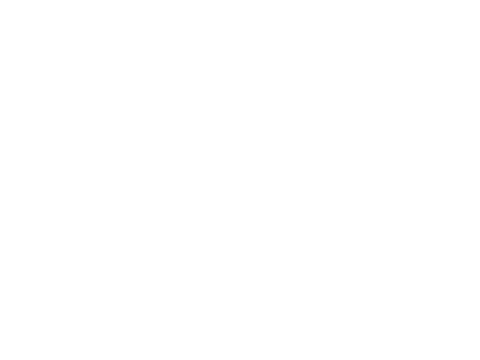

     animalid cohort                                         datasource  \
4756      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   
4757      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4756  20170125  
4757  20170125  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y15', 0.75), ('Blob_N2_y45', 0.9090909090909091), ('Blob_N1_y45', 0.9090909090909091), ('Blob_N1_y60', 1.0), ('Blob_N2_y60', 0.9090909090909091), ('Blob_N1_y-30', 0.9090909090909091), ('Blob_N1_y-15', 0.75), ('Blob_N1_y0', 0.7428571428571429), ('Blob_N2_y30', 0.75), ('Blob_N1_y-45', 1.0), ('Blob_N2_y-45', 0.8333333333333334), ('Blob_N2_y0', 0.7794117647058824), ('Blob_N1_y30', 0.9090909090909091), ('Blob_N2_y-60', 0.7272727272727273), ('Blob_N1_y15', 0.8181818181818182), ('Blob_N2_y-15', 1.0), ('Blob_N1_y-60'

<IPython.core.display.Javascript object>


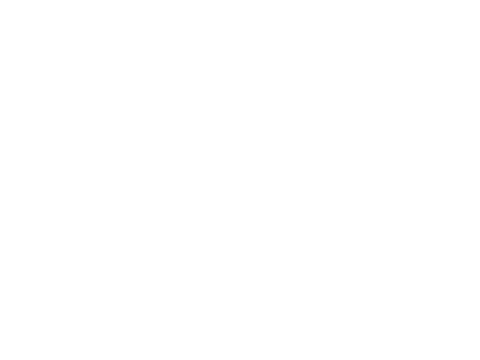

     animalid cohort                                         datasource  \
4758      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4758  20170127  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(907, 913)
N total response events:  901
N total outcome events:  901
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_170127.mwk
N valid trials: 901
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.71875), ('Blob_N2_y45', 0.6875), ('Blob_N1_y45', 0.875), ('Blob_N1_y60', 0.96875), ('Blob_N2_y15', 0.90625), ('Blob_N1_y-30', 0.8181818181818182), ('Blob_N1_y-15', 0.625), ('Blob_N1_y0', 0.5416666666666666), ('Blob_N2_y30', 0.8787878787878788), ('Blob_N1_y-45', 0.84375), ('Blob_N2_y-45', 0.84375)

<IPython.core.display.Javascript object>


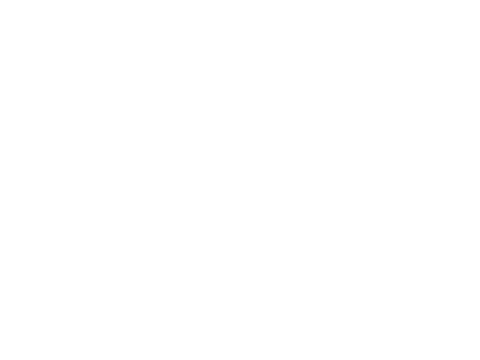

     animalid cohort                                         datasource  \
4759      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4759  20170131  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(727, 733)
N total response events:  722
N total outcome events:  722
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_170131.mwk
N valid trials: 722
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.6538461538461539), ('Blob_N2_y45', 0.68), ('Blob_N1_y45', 1.0), ('Blob_N1_y60', 0.9230769230769231), ('Blob_N2_y15', 0.7307692307692307), ('Blob_N1_y-30', 1.0), ('Blob_N1_y-15', 0.8461538461538461), ('Blob_N1_y0', 0.7662337662337663), ('Blob_N2_y30', 0.6538461538461539), ('Blob_N1_y-45', 0.961538

<IPython.core.display.Javascript object>


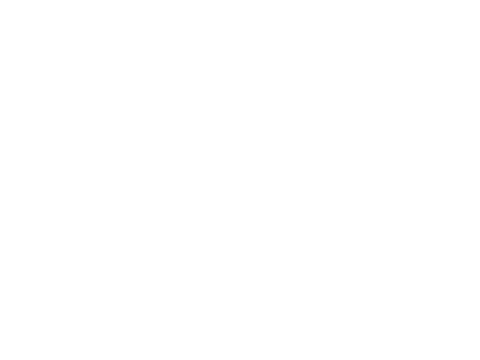

     animalid cohort                                         datasource  \
4760      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4760  20170201  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(756, 762)
N total response events:  746
N total outcome events:  746
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_170201.mwk
N valid trials: 746
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.5925925925925926), ('Blob_N2_y45', 0.8518518518518519), ('Blob_N1_y45', 0.9629629629629629), ('Blob_N1_y60', 1.0), ('Blob_N2_y15', 0.8076923076923077), ('Blob_N1_y-30', 0.9615384615384616), ('Blob_N1_y-15', 0.7037037037037037), ('Blob_N1_y0', 0.6918238993710691), ('Blob_N2_y30', 0.814814814814814

<IPython.core.display.Javascript object>


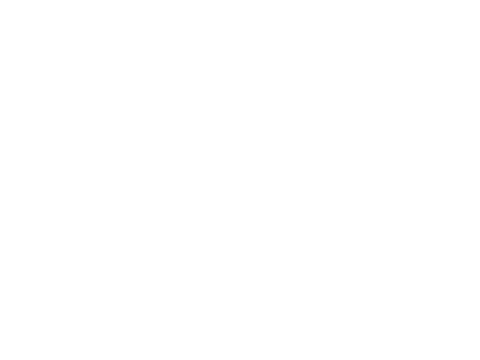

     animalid cohort                                         datasource  \
4761      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4761  20170202  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
... loading existing parsed session file
***** Parsing trials *****
(474, 480)
N total response events:  457
N total outcome events:  457
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_170202.mwk
N valid trials: 457
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting performance by transform ...
[('Blob_N2_y60', 0.875), ('Blob_N2_y45', 0.6875), ('Blob_N1_y45', 1.0), ('Blob_N1_y60', 1.0), ('Blob_N2_y15', 0.7647058823529411), ('Blob_N1_y-30', 0.8823529411764706), ('Blob_N1_y-15', 0.8125), ('Blob_N1_y0', 0.6161616161616161), ('Blob_N2_y30', 0.75), ('Blob_N1_y-45', 0.875), ('Blob_N2_y-45', 0.75), ('Blob_N2_y0'

<IPython.core.display.Javascript object>


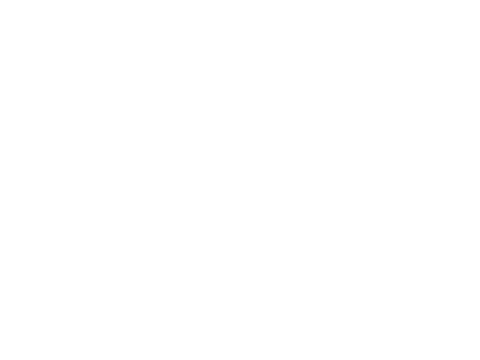

NameError: name 'animal_datafile' is not defined

In [53]:
# cohort = 'AG'
# animalid = 'AG2'
# session_meta = metadata[metadata.animalid==animalid].copy()


for (cohort, animalid), session_meta in metadata.groupby(['cohort', 'animalid']):

    print("***********************************************")
    print("ANIMAL:  %s" % animalid)
    print("***********************************************")

    A, new_sessions = processd.load_animal_data(animalid, paradigm, session_meta, rootdir=rootdir)
    
    # Process all new sessions:
    #session_meta = metadata[(metadata.animalid==animalid)] # & (metadata.session==session)]
    processed_sessions = util.process_sessions_mp(new_sessions, session_meta,
                                             #dst_dir=output_figdir,
                                             nprocesses=1,
                                             ignore_flags=ignore_flags,
                                             response_types=response_types,
                                             outcome_types=outcome_types, create_new=False)

    # Update animal sessions dict:
    for datestr, S in processed_sessions.items():
        A.sessions.update({datestr: S})


In [ ]:

# Save to disk:
try:
    with open(A.path, 'wb') as f:
        pkl.dump(A, f, protocol=pkl.HIGHEST_PROTOCOL)
except PicklingError:
    print("Unable to pkl: New sessions are not the same class as old sessions.")
    print("Reprocessing %i old sessions..." % len(processed_sessions))
    for session in old_sessions:
        curr_sessionmeta = session_meta[session_meta.session==session] #session_info[datestr]
        S = util.process_session(curr_sessionmeta)
        A.sessions[session] = S

    with open(A.path, 'wb') as f:
        pkl.dump(A, f, protocol=pkl.HIGHEST_PROTOCOL)

print("[%s] ~~~ processing complete! ~~~" % A.animalid)



In [80]:
reload(processd)

process_datafiles.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel/kernelapp.

<module 'process_datafiles' from 'process_datafiles.py'>

In [81]:
Atest, new_sessions = processd.load_animal_data(animalid, paradigm, session_meta, rootdir=rootdir)

(False, False)
outfile: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed/data/AG1.pkl
[AG1]: Loaded 185 processed sessions (+3 are None).
[AG1]: Found 0 out of 188 sessions to process.


In [82]:
new_sessions

[]

In [60]:
dforig = df.copy()

In [91]:
reload(processd)

process_datafiles.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel/kernelapp.

<module 'process_datafiles' from 'process_datafiles.py'>

In [138]:
animalid = 'AG1'
df, new_s, no_trials = processd.get_animal_df(animalid, paradigm, metadata, create_new=False, rootdir=rootdir)
    


/n/coxfs01/behavior-data/threeport/processed/data
/n/coxfs01/behavior-data/threeport/processed/data/df_AG1.pkl
... loading existing df


In [140]:
df[df['session']==20150428]

depth_rotation  duration light_position                name  no_feedback  \
0                 0   5714787              0   Blob_N2_CamRot_y0         True   
1                 0   5098325              0   Blob_N1_CamRot_y0         True   
2                 0   5098320              0   Blob_N1_CamRot_y0         True   
3                 0   5248274              0   Blob_N1_CamRot_y0         True   
4                 0    533158              0   Blob_N2_CamRot_y0         True   
5                 0   5148308              0   Blob_N1_CamRot_y0         True   
6                 0   5164969              0   Blob_N1_CamRot_y0         True   
7                 0   5431544              0   Blob_N2_CamRot_y0         True   
8                 0    816398              0   Blob_N2_CamRot_y0         True   
9                 0    649786              0   Blob_N2_CamRot_y0         True   
10                0    416530              0   Blob_N2_CamRot_y0         True   
11                0   5064999              0   Blob_N1_CamRot_y0         True   
12                0   5531514              0   Blob_N1_CamRot_y0         True   
13                0    733092              0   Blob_N1_CamRot_y0         True   
14                0    666447              0   Blob_N2_CamRot_y0         True   
15                0   1116299              0   Blob_N1_CamRot_y0         True   
16                0   5464870              0   Blob_N2_CamRot_y0         True   
17                0   5015019              0   Blob_N1_CamRot_y0         True   
18                0    949688              0   Blob_N2_CamRot_y0         True   
19                0   1016332              0   Blob_N1_CamRot_y0         True   
20                0   5348241              0   Blob_N1_CamRot_y0         True   
21                0   5065003              0   Blob_N2_CamRot_y0         True   
22                0    566480              0   Blob_N2_CamRot_y0         True   
23                0   5164966              0   Blob_N1_CamRot_y0         True   
24                0   1066315              0   Blob_N2_CamRot_y0         True   
25                0    666447              0   Blob_N1_CamRot_y0         True   
26                0   5098322              0   Blob_N2_CamRot_y0         True   
27                0   5098322              0   Blob_N2_CamRot_y0         True   
28                0   5298258              0   Blob_N2_CamRot_y0         True   
29                0   5464868              0   Blob_N1_CamRot_y0         True   
..              ...       ...            ...                 ...          ...   
283              40   5348239              0  Blob_N2_CamRot_y40         True   
284              55   5214954              0  Blob_N1_CamRot_y55         True   
285              50   1066316              0  Blob_N2_CamRot_y50         True   
286              50   1082981              0  Blob_N2_CamRot_y50         True   
287              55   5498190              0  Blob_N1_CamRot_y55         True   
288              55   5364902              0  Blob_N1_CamRot_y55         True   
289               5   5314919              0   Blob_N1_CamRot_y5         True   
290              55   5098325              0  Blob_N2_CamRot_y55         True   
291              55    833059              0  Blob_N2_CamRot_y55         True   
292              60    716431              0  Blob_N2_CamRot_y60         True   
293              60   5614818              0  Blob_N1_CamRot_y60         True   
294              55   5364903              0  Blob_N1_CamRot_y55         True   
295              60   5181627              0  Blob_N2_CamRot_y60         True   
296              35    499836              0  Blob_N2_CamRot_y35         True   
297              55   4981689              0  Blob_N1_CamRot_y55         True   
298              10    733093              0  Blob_N2_CamRot_y10         True   
299              45   5348242              0  Blob_N1_CamRot_y45         True   
300              40   5131647       

In [132]:
df, new_s, no_trials = processd.get_animal_df(animalid, paradigm, metadata, create_new=False, rootdir=rootdir)


/n/coxfs01/behavior-data/threeport/processed/data
/n/coxfs01/behavior-data/threeport/processed/data/df_AG1.pkl
... loading existing df


In [134]:
animalid

'AG1'

In [15]:
curr_processed_dir = animal_datafile.split('/data')[0]
tmp_processed_sessions = glob.glob(os.path.join(curr_processed_dir, 'figures', 
                                                'tmp_files', 'proc_%s_*.pkl' % A.animalid))
print("Found %i processed sessions in tmp dir." % len(tmp_processed_sessions))

for tmpfile in tmp_processed_sessions:
    with open(tmpfile, 'rb') as f:
        tmpS = pkl.load(f)
    session = os.path.splitext(os.path.split(tmpfile)[-1])[0].split('_')[2]
    #print datestr
    A.sessions.update({session: tmpS})
    
# Save to disk:
try:
    with open(animal_datafile, 'wb') as f:
        pkl.dump(A, f, protocol=pkl.HIGHEST_PROTOCOL)
except PicklingError:
    print("Unable to pkl: New sessions are not the same class as old sessions.")
    print("Reprocessing %i old sessions..." % len(processed_sessions))
    for session in old_sessions:
        curr_sessionmeta = session_meta[session_meta.session==session] #session_info[datestr]
        S = pd.process_session(curr_sessionmeta)
        A.sessions[session] = S

    with open(animal_datafile, 'wb') as f:
        pkl.dump(A, f, protocol=pkl.HIGHEST_PROTOCOL)

Found 70 processed sessions in tmp dir.


In [93]:
processed_sessions

NameError: name 'processed_sessions' is not defined

In [85]:
A.sessions[20150206].trials

[{'action': 'draw',
  'depth_rotation': 0,
  'duration': 5314949,
  'file_hash': '3c0f591fcbbe5741dbb1b2982cee3e696603f72d',
  'filename': '/var/folders/bq/d_40rj9j1slfyy_dz1h7_7p80000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs/tmp/Blobs_TrainingRatsD1D2/Blob_N1_CamRot_y0.png',
  'name': 'Blob_1_RotDep_0',
  'no_feedback': True,
  'outcome': 'success',
  'outcome_time': 1619996695,
  'pos_x': 10.0,
  'pos_y': 0.0,
  'response': 'Announce_AcquirePort3',
  'response_time': 1619996467,
  'rotation': 0.0,
  'size': 30.0,
  'size_x': 52.40999984741211,
  'size_y': 52.40999984741211,
  'time': 1619260929,
  'type': 'image'},
 {'action': 'draw',
  'depth_rotation': 0,
  'duration': 6397913,
  'file_hash': '3c0f591fcbbe5741dbb1b2982cee3e696603f72d',
  'filename': '/var/folders/bq/d_40rj9j1slfyy_dz1h7_7p80000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs/tmp/Blobs_TrainingRat

In [9]:

event_names = ['depth_rotation', 'size', 'light_position', 'rotation',
               'response_time', 'outcome', 'time']


In [99]:
df.columns

Index([u'depth_rotation', u'duration', u'light_position', u'name',
       u'no_feedback', u'outcome', u'pos_x', u'pos_y', u'response',
       u'response_time', u'rotation', u'size', u'time', u'session'],
      dtype='object')

In [125]:
tmpdf = df[df['size']==30].copy()


<IPython.core.display.Javascript object>


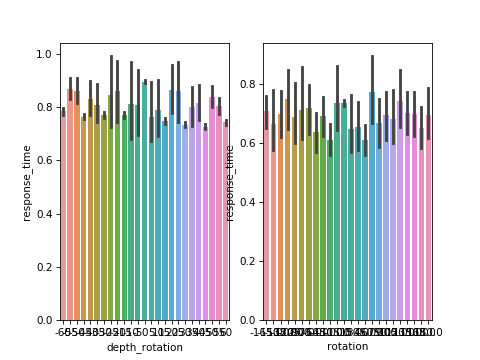

In [127]:
fig, axes = pl.subplots(1, 2)
sns.barplot(x='depth_rotation', y='response_time', data=tmpdf[tmpdf['rotation']==0], ax=axes[0])
sns.barplot(x='rotation', y='response_time', data=tmpdf[tmpdf['depth_rotation']==30], ax=axes[1])

<IPython.core.display.Javascript object>


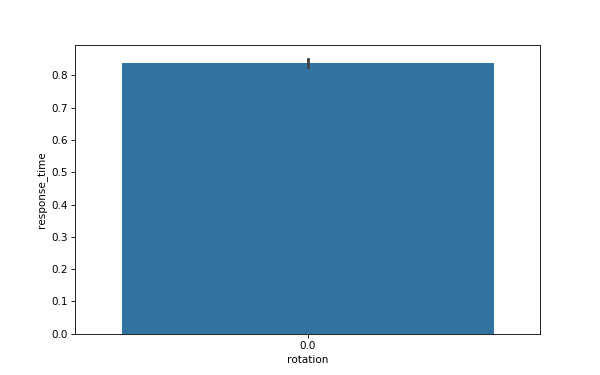

In [114]:
fig, ax = pl.subplots(figsize=(8,5))
sns.barplot(x='rotation', y='response_time', data=tmpdf[tmpdf['depth_rotation']==0], ax=ax)

In [113]:
df.groupby(['size', 'depth_rotation'])['response_time'].mean()

size  depth_rotation
5.0    0                2.500733
7.5    0                1.142763
10.0   0                1.015143
12.5   0                1.022968
15.0  -60               0.824180
      -45               0.827131
      -30               0.824851
      -15               0.798777
       0                0.838496
       15               0.800266
       30               0.762702
       45               0.768594
       60               0.791201
17.5   0                1.007619
20.0  -60               0.818609
      -45               0.787580
      -30               0.804480
      -15               0.781724
       0                0.823004
       15               0.768856
       30               0.756704
       45               0.742438
       60               0.772164
22.5   0                0.976337
25.0  -60               0.734027
      -45               0.721488
      -30               0.744629
      -15               0.750488
       0                0.804802
       15             

In [14]:
#(tmpdf['response_time']-tmpdf['time']) / 1E6

## debugging space

In [26]:
import pymworks

In [27]:
# AG2_160212

SyntaxError: invalid syntax (<ipython-input-27-01ec91d1ee21>, line 1)

In [72]:
#dfn = '/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_160408.mwk' 
dfn = '/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_160623.mwk' 

#AG2_160623.mwk
df = pymworks.open(dfn)


In [73]:
df.get_events('#stimDisplayUpdate')

[Event[code=7, name=#stimDisplayUpdate, time=238840823956, value=[None]],
 Event[code=7, name=#stimDisplayUpdate, time=238841194962, value=[None]],
 Event[code=7, name=#stimDisplayUpdate, time=239028219139, value=[None]],
 Event[code=7, name=#stimDisplayUpdate, time=239059576030, value=[{'name': 'BlankScreen', 'color_g': 0.0, 'color_b': 0.0, 'action': 'draw', 'type': 'blankscreen', 'color_r': 0.0}, {'pos_x': 0.0, 'pos_y': 0.0, 'name': 'Blob_N1_CamRot_y60.png 2', 'filename': '/var/folders/bq/d_40rj9j1slfyy_dz1h7_7p80000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs/tmp/Blobs_TrainingRatsD1D2/Blob_N1_CamRot_y60.png', 'file_hash': '43b41be240c1fac0a4385f97f9fddf709f106f2f', 'size_x': 52.40999984741211, 'size_y': 52.40999984741211, 'action': 'draw', 'rotation': 0.0, 'type': 'image'}]],
 Event[code=7, name=#stimDisplayUpdate, time=239062091869, value=[{'name': 'BlankScreen', 'color_g': 0.0, 'color_b': 0.0, 'action': 'draw', 'type': 

In [74]:
df.get_codec()

{0: '#codec',
 1: '#systemEvent',
 2: '#components',
 3: '#termination',
 4: '#allowAltFailover',
 5: '#state_system_mode',
 6: '#announceMessage',
 7: '#stimDisplayUpdate',
 8: '#beamPosition',
 9: '#experimentLoadProgress',
 10: '#announceStimulus',
 11: '#announceSound',
 12: '#announceCalibrator',
 13: '#requestCalibrator',
 14: '#announceCurrentState',
 15: '#annouceTrial',
 16: '#announceBlock',
 17: '#announceAssertion',
 18: '#serverName',
 19: '#mainScreenInfo',
 20: '#warnOnSkippedRefresh',
 21: 'debuggerActive',
 22: 'debuggerRunning',
 23: 'debuggerStep',
 24: '#serialBridgeAddress',
 25: '#syringePumpPort',
 26: 'Adjusted_Metric_Correct_Strategy',
 27: 'GainFactorCorrectMetric',
 28: 'FlagAutomaticBiasSuppression',
 29: 'WatchResponseSide',
 30: 'WatchSuccessBias',
 31: 'Metric_Correct_Strategy',
 32: 'Metric_Biased_Strategy',
 33: 'Metric_Alternation_Strategy',
 34: 'FlagStaircaseHorizSeparation',
 35: 'WatchSuccessStair_HorizSep',
 36: 'HorizSep_stair_up_criterion',
 37:

In [79]:
if 'nofeedback_depth_rotation_min' not in df.get_codec().values():
    always_feedback = True
else:
    always_feedback = False
    no_fb_params_tmp = df.get_events(['nofeedback_size_min',
                                   'nofeedback_size_max',
                                   'nofeedback_depth_rotation_min',
                                   'nofeedback_depth_rotation_max'])
    fb_info = list(set([(e.name, e.value) for e in no_fb_params_tmp]))
    no_fb = {}
    for fb in fb_info:
        param = '_'.join(fb[0].split('_')[1:-1])
        if param not in no_fb.keys():
            no_fb[param] = [fb[1]]
        else:
            no_fb[param].append(fb[1])
no_fb

{'depth_rotation': [0.0, 0.0], 'size': [15, 15.0]}

In [85]:
import pymworks
remove_orphans=True

In [86]:
stim_blacklists = [
    lambda s: (('type' in s.keys()) and (s['type'] == 'blankscreen')),
    ]

print "***** Parsing trials *****"
df = pymworks.open(dfn)

# Separate behavior-training flag states from current trial states
if ignore_flags is None or len(ignore_flags)==0:
    codec = df.get_codec()
    ignore_flags = []
    all_flags = [f for f in codec.values() if 'Flag' in f or 'flag' in f]
    for fl in all_flags:
        evs = df.get_events(fl)
        vals = list(set([v.value for v in evs]))
        if len(vals) > 1 or len(evs) > 5:
            ignore_flags.append(fl)

# Get run bounds:
bounds = pb.get_run_time(df)
# if bounds is None:
#     return None, None, df

trials = []; flag_list = []; flags = {};
for bound in bounds:

    if (bound[1]-bound[0])/1E6 < 2.0:
        continue

    # Identify no feedback conditions
    #  231: 'nofeedback_depth_rotation_min',
    #  232: 'nofeedback_depth_rotation_max',
    #  233: 'nofeedback_size_min',
    #  234: 'nofeedback_size_max',
    if 'nofeedback_depth_rotation_min' not in df.get_codec().values():
        always_feedback = True
    else:
        always_feedback = False
        no_fb_params_tmp = df.get_events(['nofeedback_size_min',
                                       'nofeedback_size_max',
                                       'nofeedback_depth_rotation_min',
                                       'nofeedback_depth_rotation_max'])
        fb_info = list(set([(e.name, e.value) for e in no_fb_params_tmp]))
        no_fb = {}
        for fb in fb_info:
            param = '_'.join(fb[0].split('_')[1:-1])
            if param not in no_fb.keys():
                no_fb[param] = [fb[1]]
            else:
                no_fb[param].append(fb[1])

    # Get display events:
    tmp_devs = df.get_events('#stimDisplayUpdate')                     
    tmp_devs = [i for i in tmp_devs if bound[0] <= i['time']<= bound[1]] 

    # Get behavior flags:
    codec = df.get_codec()
    all_flags = [f for f in codec.values() if 'Flag' in f or 'flag' in f]
    flag_names = [f for f in all_flags if f not in ignore_flags]
    tmp_flags = dict((flag, None) for flag in flag_names)
    for flag in flag_names:
        if flag == 'FlagNoFeedbackInCurrentTrial': continue
        found_values = [e.value for e in df.get_events(flag) if bound[0] <= e.time <=bound[1]]
        if (len(found_values) > 1) or (len(list(set(found_values)))) > 1:
            print("More than 1 value found for flag: %s" % flag)
            tmp_flags[flag] = int(found_values[-1])
        elif (len(found_values) == 1) or (len(list(set(found_values)))) == 1:
            tmp_flags[flag] = int(found_values[0])
        else:
            tmp_flags.pop(flag)

    # Add current flag values to flags list:
    flag_list.append(tmp_flags)

    # Add boundary time to flag info:
    tmp_flags.update({'run_bounds': bound})

    # Check for valid response types and get all response events:
    response_types = [r for r in response_types if r in codec.values()]
    response_evs = [e for e in df.get_events(response_types) if e.value==1] #if (bound[0] < e['time'] < bound[1]) and e.value==1]    
    outcome_evs = [e for e in df.get_events(outcome_types) if e.value==1] #if (bound[0] < e['time'] < bound[1]) and e.value is not None and e.value != 0] #not in [0, None]]  
    print(len(response_evs), len(outcome_evs))

    # Sync response events to true outcome events:  response occurs before outcome, outcome is the master
    outcome_key = 'response'
    responses = pb.to_trials(tmp_devs, response_evs, outcome_key=outcome_key,
                                               duration_multiplier=1.,
                                               stim_blacklists=stim_blacklists,
                                               remove_unknown=True)

    outcomes = pymworks.events.utils.sync(outcome_evs, responses, direction=1, mkey=lambda x: x['response_time'])

    print "N total response events: ", len(responses)
    print "N total outcome events: ", len(outcomes)

    assert len(responses) == len(outcomes), "**ERROR:  N responses (%i) != N outcomes (%i)" % (len(responses), len(outcomes))
    tmp_trials = copy.copy(responses)
    for trial_ix, (response, outcome) in enumerate(zip(responses, outcomes)):
        if outcome is not None:
            tmp_trials[trial_ix].update({'outcome': outcome.name, 'outcome_time': outcome.time}) #['outcome']})
        else:
            tmp_trials[trial_ix].update({'outcome': 'unknown'})

    # Get rid of display events without known outcome within 'duration_multiplier' time
    if remove_orphans:                                                  
        orphans = [(i,x) for i,x in enumerate(tmp_trials) if\
                    x['outcome']=='unknown' or x['%s' % outcome_key]=='unknown']
        tmp_trials = [t for t in tmp_trials if not t['outcome']=='unknown']
        tmp_trials = [t for t in tmp_trials if not t['%s' % outcome_key]=='unknown']

        print "Found and removed %i orphan stimulus events in file %s" % (len(orphans), df.filename)
        print "N valid trials: %i" % len(tmp_trials)

    # Add current trials in chunk to trials list:
    trials.extend(tmp_trials)


***** Parsing trials *****
(944, 950)
N total response events:  938
N total outcome events:  938
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_160623.mwk
N valid trials: 938


In [87]:

for t in trials:
    stim_aspect = [v.value for v in df.get_events('StimAspectRatio')][-1]
    assert t['response_time'] < t['outcome_time'], "**ERROR: Mismatch in response/outcome alignment"

    # Supplement trial info
    stimname = t['name'].split(' ')[0].split('.png')[0]
    t['name'] = stimname
    # Can be: Blob_1_RotDep_0, Blob_N2_CamRot_y-45

    if 'RotDep' in stimname:
        drot_str = stimname.split('_')[-1]
        depthrot_value = int(drot_str)
        t['depth_rotation'] = depthrot_value #Blob_N2_CamRot_y-45
    elif 'CamRot' in stimname and 'LighPos' in stimname:
        depthrot_value = int(stimname.split('CamRot_y')[1].split('_')[0])
        lightpos_value = tuple([int(i) for i in re.findall("[-\d]+", stimname.split('LighPos')[1])])
        t['depth_rotation'] = depthrot_value #Blob_N2_CamRot_y-45
        t['light_position'] = lightpos_value
    elif 'CamRot' in stimname:
        depthrot_value = int(stimname.split('CamRot_y')[1].split('_')[0])
        t['depth_rotation'] = depthrot_value #Blob_N2_CamRot_y-45
    elif 'morph' in stimname:
        t['depth_rotation']=0

#         if 'y' in drot_str:
#             depthrot_value = int(drot_str[1:])
#         else:
#             depthrot_value = int(drot_str)

    t['size'] = round(t['size_x']/stim_aspect, 1)

    # Check if no feedback
    if always_feedback:
        t['no_feedback'] = True
    else:
        t['no_feedback'] = all([np.min(lims) < t[k] < np.max(lims) for k, lims in no_fb.items()])


KeyError: 'depth_rotation'

In [88]:
t

{'action': 'draw',
 'duration': 416530,
 'file_hash': 'a51f86bed16f18dfa4aadad2e0489696749d1a2c',
 'filename': '/var/folders/bq/d_40rj9j1slfyy_dz1h7_7p80000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs/tmp/morphsD1D2/morph13.png',
 'name': 'morph13',
 'outcome': 'failure',
 'outcome_time': 239069203023,
 'pos_x': 0.0,
 'pos_y': 0.0,
 'response': 'Announce_AcquirePort3',
 'response_time': 239069202703,
 'rotation': 0.0,
 'size': 40.0,
 'size_x': 69.87999725341797,
 'size_y': 69.87999725341797,
 'time': 239068806327,
 'type': 'image'}

In [89]:
stimname

'morph13'

In [33]:
stimname = 'Blob_N2_CamRot_y60_LighPos_x10_y0_z-10'


In [36]:
stimname.split('CamRot_y')[1].split('_')[0]

'60'

In [42]:
stimname.split('LighPos')[1]

['_x10_y0_z-10']

In [47]:
#re.findall(r'\d+', stimname.split('LighPos')[1])
tuple([int(i) for i in re.findall("[-\d]+", stimname.split('LighPos')[1])])


(10, 0, -10)

In [78]:
[d for d in df.get_codec().values() if 'nofeedback' in d]

['nofeedback_depth_rotation_min',
 'nofeedback_depth_rotation_max',
 'nofeedback_size_min',
 'nofeedback_size_max']

# 4. Run all animals and sessions

In [ ]:
for (cohort, animalid), session_meta in metadata[metadata['cohort']=='AG'].groupby(['cohort', 'animalid']):

    
    print("***********************************************")
    print("ANIMAL:  %s" % animalid)
    print("***********************************************")

    # Get current animal session info:
    A = pb.Animal(animalid=animalid, experiment=paradigm) #, output_datadir=output_datadir)
    curr_processed_dir = os.path.join(root, paradigm, 'cohort_data', cohort, 'processed')

    # --- Create or load animal datafile:
    animal_datafile = os.path.join(curr_processed_dir, 'data', '%s.pkl' % animalid)
    print("outfile: %s" % animal_datafile)
    
    # --- Check if processed file exists -- load or create new.
    create_new = False
    if os.path.exists(animal_datafile):
        try:
            with open(animal_datafile, 'rb') as f:
                A = pkl.load(f)   
        except EOFError:
            create_new = True

    # --- Process new datafiles / sessions:
    all_sessions = metadata[metadata.animalid==animalid]['session'].values
    old_sessions = [skey for skey, sobject in A.sessions.items() if sobject is not None]
    print("[%s]: Found %i processed sessions." % (animalid, len(old_sessions)))
    new_sessions = [s for s in all_sessions if s not in old_sessions]
    print("[%s]: There are %i out of %i found session datafiles to process." % (A.animalid, len(new_sessions), len(all_sessions)))

    # Process all new sessions:
    #session_meta = metadata[(metadata.animalid==animalid)] # & (metadata.session==session)]
    processed_sessions = pb.process_sessions_mp(new_sessions, session_meta,
                                             #dst_dir=output_figdir,
                                             nprocesses=1,
                                             ignore_flags=ignore_flags,
                                             response_types=response_types,
                                             outcome_types=outcome_types) #, create_new=True)

    # Update animal sessions dict:
    for datestr, S in processed_sessions.items():
        A.sessions.update({datestr: S})

    # Save to disk:
    try:
        with open(animal_datafile, 'wb') as f:
            pkl.dump(A, f, protocol=pkl.HIGHEST_PROTOCOL)
    except PicklingError:
        print("Unable to pkl: New sessions are not the same class as old sessions.")
        print("Reprocessing %i old sessions..." % len(processed_sessions))
        for session in old_sessions:
            curr_sessionmeta = session_meta[session_meta.session==session] #session_info[datestr]
            S = pd.process_session(curr_sessionmeta)
            A.sessions[session] = S

        with open(animal_datafile, 'wb') as f:
            pkl.dump(A, f, protocol=pkl.HIGHEST_PROTOCOL)

    print("[%s] ~~~ processing complete! ~~~" % A.animalid)

